# Final Project Submission

Please fill out:
* Student name: Peder Norr
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:

# Introduction

Real estate continues to be one of the most lucrative and secure investment vehicles available. This proposal contains an analysis of Minnesota home value time series data in order to provide a real estate investment firm the identification of the best locations to invest in Minnesota. Initial analysis of the data shows that there are 5 zip codes that provide the biggest opportunity for return on investment. The real estate investment firm can use this analysis to make their entry in the Minnesotan market more effective and profitable.

# Business Problem

Due to the booming housing market in the state, a real estate investment firm has decided to invest in property in Minnesota. However, they are unfamiliar with the state. They want to identify the top 5 best zip codes in the state in which to invest. This proposal will identify the top 5 zip codes for investment by calculating future potential return on investment.

# Data Understanding

The data used in this analysis come from [Zillow Research](https://www.zillow.com/research/data/) which aggregates housing data. The data set contains 6 variables describing property sale including zip code, city, state, metro area, size rank It includes 14,723 individual entries recorded daily from 1996-2018.

In [1]:
#Import necessary packages

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as missingno

%matplotlib inline

import statsmodels.tsa.api as tsa
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


#!pip install pmdarima
import pmdarima as pmd


In [2]:
#Set pandas and seaborn options

pd.set_option('display.max_columns',0)
plt.style.use('seaborn-notebook')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
#Import dataset
df = pd.read_csv('data/zillow_data.csv')
df.head()

RegionID  RegionName      City State  ...  2018-01  2018-02  2018-03  2018-04
0     84654       60657   Chicago    IL  ...  1024400  1030700  1033800  1030600
1     90668       75070  McKinney    TX  ...   318100   319600   321100   321800
2     91982       77494      Katy    TX  ...   321200   323000   326900   329900
3     84616       60614   Chicago    IL  ...  1302700  1306400  1308500  1307000
4     93144       79936   El Paso    TX  ...   120300   120500   121000   121500

[5 rows x 272 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [5]:
df.describe()

RegionID  RegionName  ...       2018-03       2018-04
count  14723.0000  14723.0000  ...    14723.0000    14723.0000
mean   81075.0101  48222.3487  ...   286511.3768   288039.9443
std    31934.1185  29359.3254  ...   372461.2347   372054.3969
min    58196.0000   1001.0000  ...    13800.0000    13800.0000
25%    67174.5000  22101.5000  ...   131950.0000   132400.0000
50%    78007.0000  46106.0000  ...   196700.0000   198100.0000
75%    90920.5000  75205.5000  ...   318850.0000   321100.0000
max   753844.0000  99901.0000  ... 18337700.0000 17894900.0000

[8 rows x 268 columns]

In [6]:
#Narrow down to Minnesota zipcodes
minnesota_df = df.loc[df['State']== 'MN'].reset_index()
display(minnesota_df.head())
print(f'Number of zipcodes: {len(minnesota_df)}')

index  RegionID  RegionName  ... 2018-02 2018-03 2018-04
0    291     82474       55901  ...  212800  213800  214400
1    500     82125       55124  ...  265600  268400  270800
2    686     82547       56001  ...  188900  188800  189100
3    745     82189       55337  ...  261200  263900  266600
4    859     82063       55044  ...  333700  338000  341700

[5 rows x 273 columns]

Number of zipcodes: 375


# Data Preprocessing

In [7]:
#Rename RegionName as ZipCode
minnesota_df.rename({'RegionName': 'ZipCode'}, axis=1, inplace=True)
minnesota_df.head()

index  RegionID  ZipCode          City  ... 2018-01 2018-02 2018-03  2018-04
0    291     82474    55901     Rochester  ...  211500  212800  213800   214400
1    500     82125    55124  Apple Valley  ...  264200  265600  268400   270800
2    686     82547    56001       Mankato  ...  189000  188900  188800   189100
3    745     82189    55337    Burnsville  ...  260000  261200  263900   266600
4    859     82063    55044     Lakeville  ...  331300  333700  338000   341700

[5 rows x 273 columns]

In [8]:
#Drop unnecessary columns
minnesota_df.drop(['index', 'RegionID', 'State', 'CountyName'], axis=1, inplace=True)
minnesota_df.head()

ZipCode          City                Metro  ...  2018-02  2018-03  2018-04
0    55901     Rochester            Rochester  ...   212800   213800   214400
1    55124  Apple Valley  Minneapolis-St Paul  ...   265600   268400   270800
2    56001       Mankato              Mankato  ...   188900   188800   189100
3    55337    Burnsville  Minneapolis-St Paul  ...   261200   263900   266600
4    55044     Lakeville  Minneapolis-St Paul  ...   333700   338000   341700

[5 rows x 269 columns]

In [9]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[4:], format='%Y-%m')

In [10]:
get_datetimes(minnesota_df)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [11]:
#Change ZipCode dtype to 'str'
minnesota_df['ZipCode'] = minnesota_df['ZipCode'].astype(str)
minnesota_df.dtypes

ZipCode      object
City         object
Metro        object
SizeRank      int64
1996-04     float64
             ...   
2017-12       int64
2018-01       int64
2018-02       int64
2018-03       int64
2018-04       int64
Length: 269, dtype: object

In [12]:
#Calculate ROI percentages since 1996
minnesota_df['ROI'] = round(((minnesota_df['2018-04'] - minnesota_df['1996-04'])/ minnesota_df['1996-04'])*100,4)
minnesota_df.head()

ZipCode          City                Metro  ...  2018-03  2018-04      ROI
0   55901     Rochester            Rochester  ...   213800   214400 134.8302
1   55124  Apple Valley  Minneapolis-St Paul  ...   268400   270800 121.2418
2   56001       Mankato              Mankato  ...   188800   189100 120.9112
3   55337    Burnsville  Minneapolis-St Paul  ...   263900   266600 116.3961
4   55044     Lakeville  Minneapolis-St Paul  ...   338000   341700 146.1816

[5 rows x 270 columns]

In [13]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['ZipCode', 'City', 'Metro', 'SizeRank', 'ROI'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted#.groupby('time').aggregate({'value':'mean'})

In [14]:
#Reshape dataset from Wide to Long Format
melted_minnesota_df = melt_data(minnesota_df)
display(melted_minnesota_df.head())
display(melted_minnesota_df.info())

ZipCode          City                Metro  ...      ROI       time       value
0   55901     Rochester            Rochester  ... 134.8302 1996-04-01  91300.0000
1   55124  Apple Valley  Minneapolis-St Paul  ... 121.2418 1996-04-01 122400.0000
2   56001       Mankato              Mankato  ... 120.9112 1996-04-01  85600.0000
3   55337    Burnsville  Minneapolis-St Paul  ... 116.3961 1996-04-01 123200.0000
4   55044     Lakeville  Minneapolis-St Paul  ... 146.1816 1996-04-01 138800.0000

[5 rows x 7 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94384 entries, 0 to 99374
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ZipCode   94384 non-null  object        
 1   City      94384 non-null  object        
 2   Metro     85345 non-null  object        
 3   SizeRank  94384 non-null  int64         
 4   ROI       91160 non-null  float64       
 5   time      94384 non-null  datetime64[ns]
 6   value     94384 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 5.8+ MB


None

In [15]:
#Set 'time' column as index to create time series
melted_minnesota_df.set_index('time', inplace=True)

In [16]:
display(melted_minnesota_df.head())
display(melted_minnesota_df.tail())
display(melted_minnesota_df.info())
melted_minnesota_df.index

ZipCode          City  ...      ROI       value
time                              ...                     
1996-04-01   55901     Rochester  ... 134.8302  91300.0000
1996-04-01   55124  Apple Valley  ... 121.2418 122400.0000
1996-04-01   56001       Mankato  ... 120.9112  85600.0000
1996-04-01   55337    Burnsville  ... 116.3961 123200.0000
1996-04-01   55044     Lakeville  ... 146.1816 138800.0000

[5 rows x 6 columns]

ZipCode         City  ...      ROI       value
time                             ...                     
2018-04-01   56314       Bowlus  ... 348.4076 211200.0000
2018-04-01   56010        Amboy  ...      nan 118300.0000
2018-04-01   55065     Randolph  ... 151.3146 277200.0000
2018-04-01   56578      Rochert  ... 330.9091 237000.0000
2018-04-01   56120  Butterfield  ...      nan 133600.0000

[5 rows x 6 columns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94384 entries, 1996-04-01 to 2018-04-01
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ZipCode   94384 non-null  object 
 1   City      94384 non-null  object 
 2   Metro     85345 non-null  object 
 3   SizeRank  94384 non-null  int64  
 4   ROI       91160 non-null  float64
 5   value     94384 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 5.0+ MB


None

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', length=94384, freq=None)

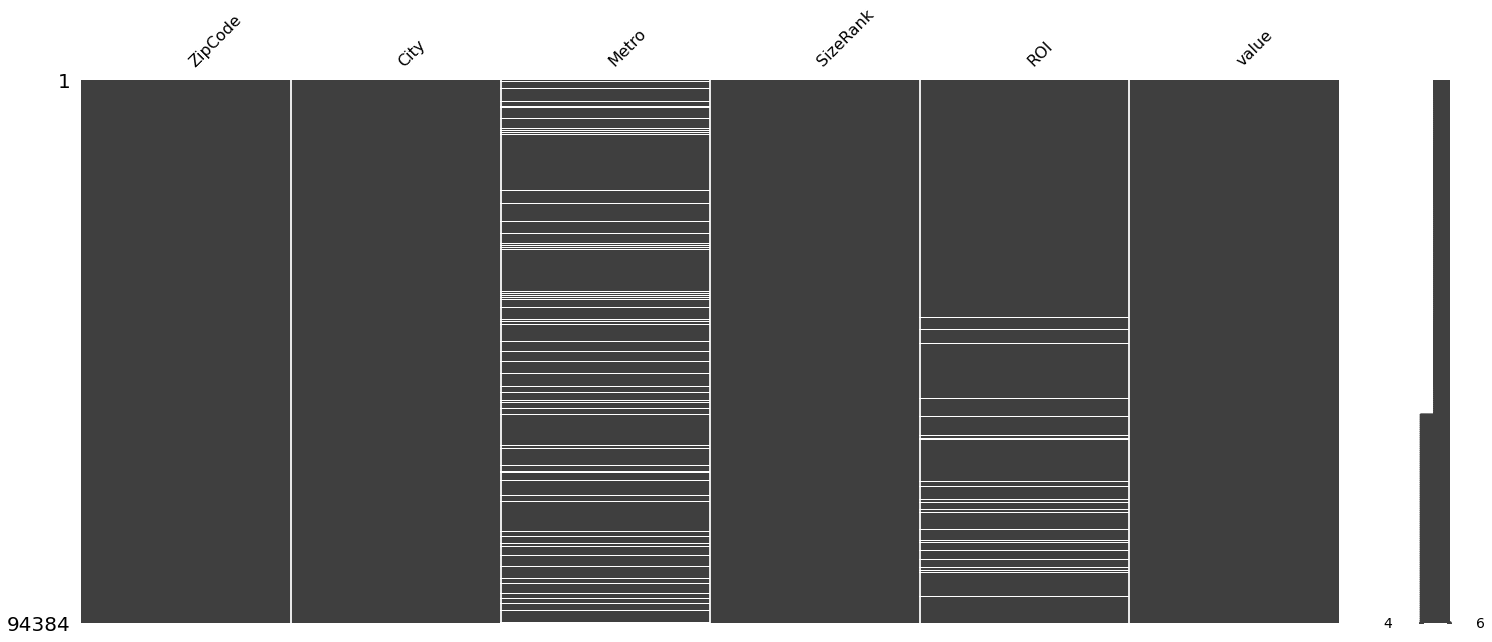

#null  %null
ZipCode       0 0.0000
City          0 0.0000
Metro      9039 9.5800
SizeRank      0 0.0000
ROI        3224 3.4200
value         0 0.0000

In [17]:
#Check for null values

#Original source https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/blob/master/Phase_3/topic_30_ensemble_methods/topic_30_ensemble_methods-SG.ipynb

missingno.matrix(melted_minnesota_df)
plt.show()
null_check = pd.DataFrame({
    '#null':melted_minnesota_df.isna().sum(),
    '%null':round(melted_minnesota_df.isna().sum()/len(melted_minnesota_df)*100,2)
})
null_check

In [18]:
#Fill 'Metro' nulls with 'Missing'
melted_minnesota_df['Metro'].fillna('Missing', inplace = True)

In [19]:
#Fill in 'ROI' nulls
#melted_minnesota_df['ROI'].fillna(melted_minnesota_df['ROI'].mean(), inplace=True)

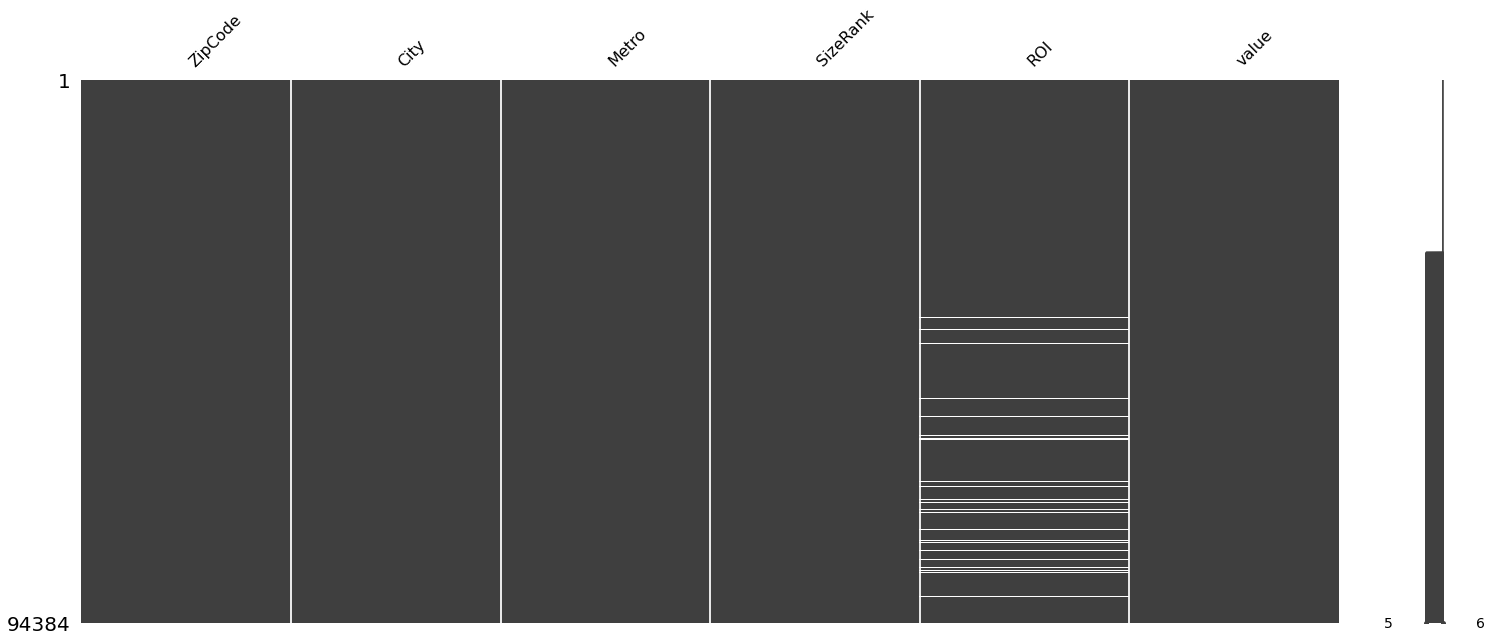

#null  %null
ZipCode       0 0.0000
City          0 0.0000
Metro         0 0.0000
SizeRank      0 0.0000
ROI        3224 3.4200
value         0 0.0000

In [20]:
missingno.matrix(melted_minnesota_df)
plt.show()
null_check = pd.DataFrame({
    '#null':melted_minnesota_df.isna().sum(),
    '%null':round(melted_minnesota_df.isna().sum()/len(melted_minnesota_df)*100,2)
})
null_check

In [21]:
display(melted_minnesota_df['ZipCode'].unique())
melted_minnesota_df['ZipCode'].nunique()

array(['55901', '55124', '56001', '55337', '55044', '55106', '55303',
       '55104', '55113', '55112', '56560', '55408', '55416', '55125',
       '55117', '55406', '55304', '55379', '55110', '55119', '55423',
       '55407', '55330', '55369', '55987', '55082', '55414', '56601',
       '55433', '55418', '55122', '55109', '56401', '55311', '55404',
       '55432', '55118', '55343', '55422', '56308', '55372', '56301',
       '55016', '55116', '55443', '55421', '55426', '55060', '55428',
       '55912', '55024', '55128', '55033', '56303', '55021', '55403',
       '55904', '55105', '55434', '55347', '55126', '55417', '55811',
       '55419', '55448', '55318', '55429', '55449', '55902', '55068',
       '55427', '55378', '55305', '55102', '55014', '55411', '56201',
       '55025', '55420', '55123', '55446', '55744', '55076', '55313',
       '55345', '55447', '55316', '55410', '55412', '56501', '55437',
       '55075', '55431', '55057', '55038', '55066', '55317', '55746',
       '55430', '554

375

# EDA and Visualization

<AxesSubplot:xlabel='time'>

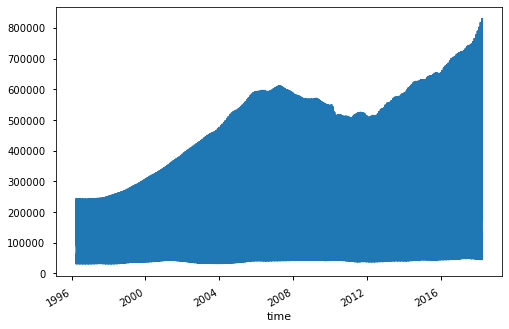

In [22]:
melted_minnesota_df['value'].plot()

In [23]:
#Select the top 2.5% performing ZipCodes based on calculated ROI
bottom_ninety_five_percent_zipcodes = melted_minnesota_df['ROI'].quantile(q=0.975)
top_5_percent_zipcodes = melted_minnesota_df.loc[melted_minnesota_df['ROI']>=bottom_ninety_five_percent_zipcodes]
top_5_percent_zipcodes.head()

ZipCode         City  ...      ROI       value
time                             ...                     
1996-04-01   55449       Blaine  ... 547.0703  51200.0000
1996-04-01   55415  Minneapolis  ... 314.1026 101400.0000
1996-04-01   56466       Motley  ... 316.3636  38500.0000
1996-04-01   56554    Lake Park  ... 345.3901  56400.0000
1996-04-01   56511      Audubon  ... 380.2365  59200.0000

[5 rows x 6 columns]

In [24]:
top_5_percent_zipcodes.drop(['Metro', 'SizeRank'], axis=1, inplace=True)
top_5_percent_zipcodes.head()

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ZipCode         City      ROI       value
time                                                
1996-04-01   55449       Blaine 547.0703  51200.0000
1996-04-01   55415  Minneapolis 314.1026 101400.0000
1996-04-01   56466       Motley 316.3636  38500.0000
1996-04-01   56554    Lake Park 345.3901  56400.0000
1996-04-01   56511      Audubon 380.2365  59200.0000

In [25]:
top_5_percent_zipcodes['ZipCode'].nunique()

9

In [26]:
#Create list of top 5% zipcodes
top_5_percent_zipcodes_list = top_5_percent_zipcodes['ZipCode'].unique().tolist()
top_5_percent_zipcodes_list

['55449',
 '55415',
 '56466',
 '56554',
 '56511',
 '56443',
 '56570',
 '56314',
 '56578']

In [27]:
#Create Time Series DataFrames for each ZipCode
all_time_series = {}
for zipcode in top_5_percent_zipcodes_list:
    zipcode_df = top_5_percent_zipcodes.groupby('ZipCode').get_group(zipcode).sort_index()['value']
    all_time_series[zipcode] = zipcode_df

In [28]:
all_time_series.keys()

dict_keys(['55449', '55415', '56466', '56554', '56511', '56443', '56570', '56314', '56578'])

In [29]:
all_time_series_df = pd.DataFrame(all_time_series)
all_time_series_df.head()

55449       55415      56466  ...      56570      56314      56578
time                                          ...                                 
1996-04-01 51200.0000 101400.0000 38500.0000  ... 44200.0000 47100.0000 55000.0000
1996-05-01 53300.0000 102800.0000 38800.0000  ... 44100.0000 47400.0000 54800.0000
1996-06-01 55300.0000 104100.0000 39100.0000  ... 44100.0000 47700.0000 54700.0000
1996-07-01 57200.0000 105400.0000 39500.0000  ... 44100.0000 48000.0000 54600.0000
1996-08-01 59100.0000 106500.0000 39900.0000  ... 44100.0000 48400.0000 54500.0000

[5 rows x 9 columns]

In [30]:
#Resample timeseries as Monthyly
all_time_series_df = all_time_series_df.resample('MS').asfreq()
all_time_series_df.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', length=265, freq='MS')

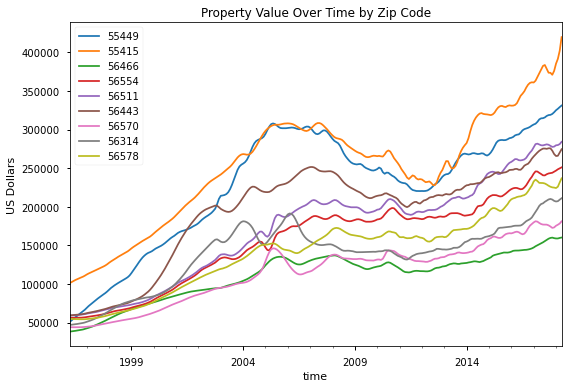

In [31]:
#Create plot
all_time_series_df.plot()
plt.title('Property Value Over Time by Zip Code')
plt.ylabel('US Dollars')
plt.tight_layout()
plt.savefig('images/all_zipcodes.png')

# ARIMA Modeling

In order to forecast property values, I will use ARIMA and SARIMA time series models. Below I fit models for each of the top 9 zip codes by ROI and make forecasts for future property values in each zip code.

## Zipcode 55449

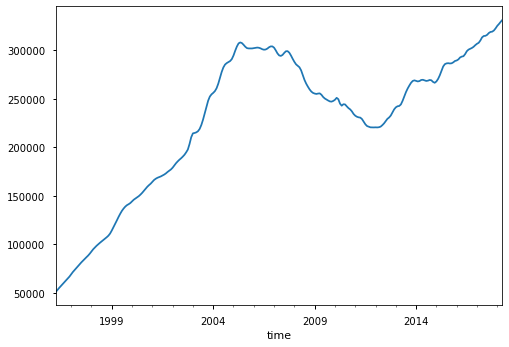

In [32]:
#Create and visualize time series for zipcode 5549
ts = all_time_series_df['55449']
ts.plot();

In [33]:
#Create train test split cutoff
tts_cutoff = round(len(ts)*0.80)
display(tts_cutoff)
    
## Use the tts cutoff to do Train test split and plot
train = ts.iloc[:tts_cutoff]
test = ts.iloc[tts_cutoff:]

212

In [34]:
#Create function to plot train test split for the time series
def plot_train_test_split(train, test):
    
    ## Plot
    ax = train.plot(label='train')
    test.plot(label='test')
    ax.legend()
    
    return ax

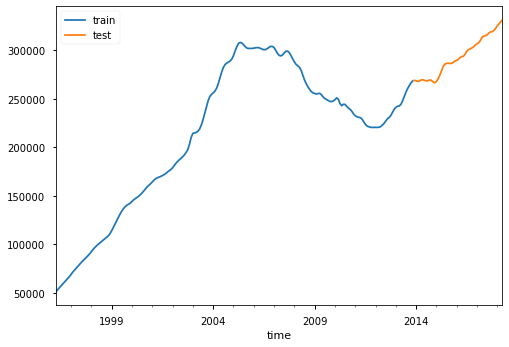

In [35]:
plot_train_test_split(train, test);

In [36]:
#Create Dickey Fuller Test test function
def adfuller_test_df(ts,index=['AD Fuller Results']):
    """Returns the AD Fuller Test Results and p-values for the null hypothesis
    that there the data is non-stationary (that there is a unit root in the data)"""
    
    df_res = tsa.stattools.adfuller(ts)

    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,df_res[:4]))
    
    res['p<.05'] = res['p-value']<.05
    res['Stationary?'] = res['p<.05']
    
    if isinstance(index,str):
        index = [index]
    res_df = pd.DataFrame(res,index=index)
    res_df = res_df[['Test Statistic','#Lags Used',
                     '# of Observations Used','p-value','p<.05',
                    'Stationary?']]
    return res_df

In [37]:
#Create Stationarity evaluation function
def stationarity_check(TS,window=4,plot=True,index=['AD Fuller Results']):
    """Adapted from https://github.com/learn-co-curriculum/dsc-removing-trends-lab/tree/solution"""
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=window, center=False).mean()
    roll_std = TS.rolling(window=window, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller_test_df(TS,index=index)
    
    if plot:
        
        ## Building in contingency if not a series with a freq
        try: 
            freq = TS.index.freq
        except:
            freq = 'N/A'
            
        # Plot rolling statistics:
        fig = plt.figure(figsize=(12,6))
        plt.plot(TS, color='blue',label=f'Original (freq={freq}')
        plt.plot(roll_mean, color='red', label=f'Rolling Mean (window={window})')
        plt.plot(roll_std, color='black', label = f'Rolling Std (window={window})')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        display(dftest)
        plt.show(block=False)
        
    return dftest

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.8173          11  ...  False        False

[1 rows x 6 columns]

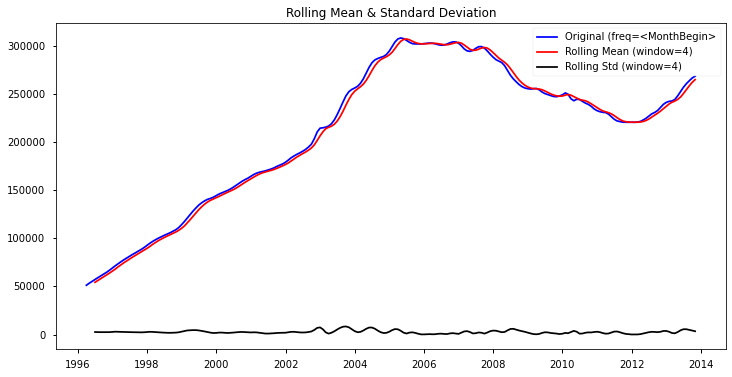

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.8173          11  ...  False        False

[1 rows x 6 columns]

In [38]:
#Check time series for stationarity
stationarity_check(train)

From the high p value shown above, we can conclude that the time series is not stationary and will require transformation.

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.8820          10  ...  False        False

[1 rows x 6 columns]

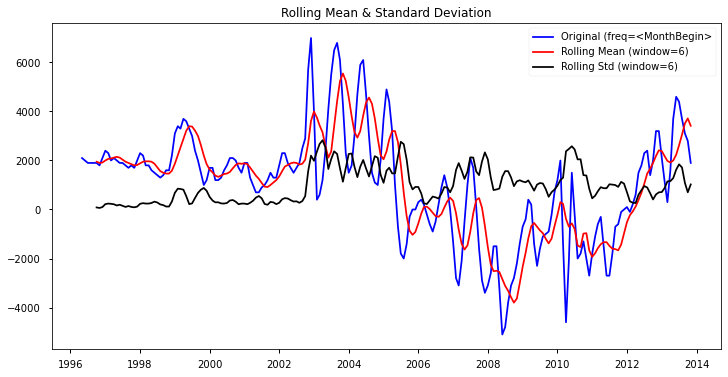

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.8820          10  ...  False        False

[1 rows x 6 columns]

In [39]:
#Check if differencing time series will result in stationarity
stationarity_check(train.diff().dropna(), window=6)

From the high p value shown above, we can conclude that the time series is not stationary and will require transformation.

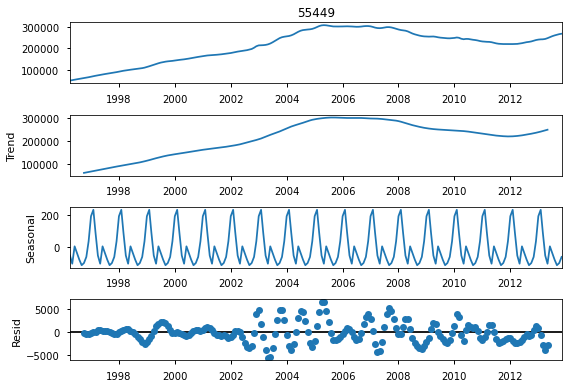

In [40]:
#Create seasonal decomposition of time series to check for seasonality
decompose = tsa.seasonal_decompose(train)
decompose.plot();

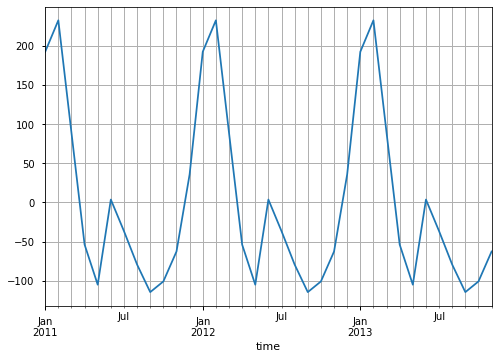

In [41]:
#Zoom in on shorter time period
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

From the figures above, we can determine that there is some seasonality in the data

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3484.797, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3464.275, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3460.168, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=3462.068, Time=0.04 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=3458.380, Time=0.23 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=3462.129, Time=0.05 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=3454.264, Time=0.26 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=3453.127, Time=0.11 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=3477.166, Time=0.06 sec
 ARIMA(1,2,1)(2,0,0)[12]             : AIC=3455.126, Time=0.15 sec
 ARIMA(0,2,2)(2,0,0)[12]             : AIC=3456.077, Time=0.23 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=3457.476, Time=0.08 sec
 ARIMA(1,2,2)(2,0,0)[12]             : AIC=3442.625, Time=0.29 sec
 ARIMA(1,2,2)(1,0,0)[12]             : AIC=3450.103, Time=0.25 sec
 ARIMA(1,2,2)(2,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  212
Model:             SARIMAX(4, 2, 3)x(1, 0, [1], 12)   Log Likelihood               -1703.906
Date:                              Tue, 29 Jun 2021   AIC                           3427.812
Time:                                      23:52:10   BIC                           3461.284
Sample:                                           0   HQIC                          3441.344
                                              - 212                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.3902      0.088     27.315      0.000       2.219       2.562
ar.L2         -2.6388      0.148    -17.837      0.000      -2.929      -2.349
ar.L3          1.3655      0.107     12.806      0.000       1.156       1.574
ar.L4         -0.3289      0.022    -14.919      0.000      -0.372      -0.286
ma.L1         -2.2213      0.092    -24.203      0.000      -2.401      -2.041
ma.L2          2.0599      0.143     14.416      0.000       1.780       2.340
ma.L3         -0.7124      0.087     -8.217      0.000      -0.882      -0.543
ar.S.L12       0.5833      0.163      3.572      0.000       0.263       0.903
ma.S.L12      -0.7041      0.151     -4.649      0.000      -1.001      -0.407
sigma2      4.078e+05   8.23e-08   4.96e+12      0.000    4.08e+05    4.08e+05
===================================================================================
Ljung-Box (L1) (Q):                  12.92   Jarque-Bera (JB):                73.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.32e+29. Standard errors may be unstable.
"""

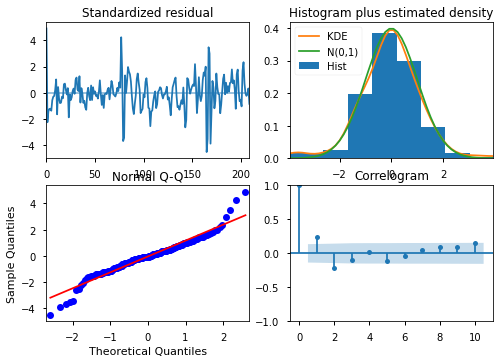

In [42]:
#Create first ARIMA model using auto arima to gridsearch for parameters
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

The above model performed well as shown by significant p values and an AIC of 3427.812. The diagnostics plots also look acceptable.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3666.392, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3578.969, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3605.623, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3585.677, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3566.873, Time=0.28 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=3568.859, Time=0.68 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=3564.470, Time=0.94 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=3570.835, Time=2.23 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=3569.803, Time=0.92 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=3568.357, Time=0.45 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=3572.388, Time=1.92 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=3647.013, Time=0.26 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=3563.559, Time=1.11 sec
 ARIMA(2,1,0)(1,1,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  212
Model:             SARIMAX(2, 1, 1)x(2, 1, [], 12)   Log Likelihood               -1768.388
Date:                             Tue, 29 Jun 2021   AIC                           3548.775
Time:                                     23:52:46   BIC                           3568.535
Sample:                                          0   HQIC                          3556.773
                                             - 212                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3437      0.061     22.141      0.000       1.225       1.463
ar.L2         -0.3437      0.051     -6.724      0.000      -0.444      -0.244
ma.L1         -0.9003      0.039    -22.963      0.000      -0.977      -0.823
ar.S.L12      -0.2821      0.027    -10.582      0.000      -0.334      -0.230
ar.S.L24      -0.2214      0.013    -16.845      0.000      -0.247      -0.196
sigma2      2.557e+06    4.6e-09   5.55e+14      0.000    2.56e+06    2.56e+06
===================================================================================
Ljung-Box (L1) (Q):                  37.21   Jarque-Bera (JB):               212.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.36
Prob(H) (two-sided):                  0.81   Kurtosis:                         8.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.8e+30. Standard errors may be unstable.
"""

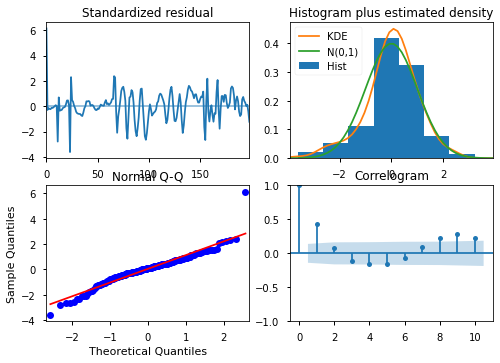

In [43]:
#Create new model and expand parameter search
model = pmd.auto_arima(train, 
                       start_p=0, max_p=10,
                       start_P=0, max_P=10,
                       start_q=0, max_q=10,
                       start_Q=0, max_Q=10,
                       d=1, D=1,
                       m=12, 
                       trace=True)
display(model.summary())
model.plot_diagnostics();

The above model performed well as shown by significant p values and an AIC of 3548.775. The diagnostics plots also look improved.

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               55449   No. Observations:                  212
Model:             SARIMAX(2, 1, 1)x(2, 1, [], 12)   Log Likelihood               -1768.388
Date:                             Tue, 29 Jun 2021   AIC                           3548.775
Time:                                     23:52:48   BIC                           3568.535
Sample:                                 04-01-1996   HQIC                          3556.773
                                      - 11-01-2013                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3437      0.061     22.141      0.000       1.225       1.463
ar.L2         -0.3437      0.051     -6.724      0.000      -0.444      -0.244
ma.L1         -0.9003      0.039    -22.963      0.000      -0.977      -0.823
ar.S.L12      -0.2821      0.027    -10.582      0.000      -0.334      -0.230
ar.S.L24      -0.2214      0.013    -16.845      0.000      -0.247      -0.196
sigma2      2.557e+06    4.6e-09   5.55e+14      0.000    2.56e+06    2.56e+06
===================================================================================
Ljung-Box (L1) (Q):                  37.21   Jarque-Bera (JB):               212.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.36
Prob(H) (two-sided):                  0.81   Kurtosis:                         8.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.8e+30. Standard errors may be unstable.
"""

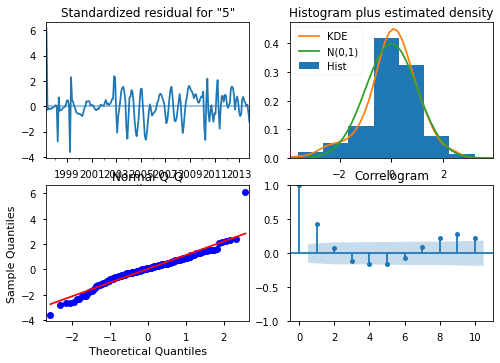

In [44]:
#Create SARIMAX model using determined parameters
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

The above model performed well as shown by significant p values and an AIC of 3548.775. The diagnostics plots also look improved.

In [45]:
#Create function to retrieve forecast and create data frame
def retrieve_forecast(model, steps):
    
    global forecast_df
    
    forecast = model.get_forecast(steps=len(test))
    forecast_df = forecast.conf_int()
    forecast_df.columns = ['Lower CI','Upper CI']
    forecast_df['Forecast'] = forecast.predicted_mean
    
    return forecast_df

In [46]:
retrieve_forecast(sarimax_model, steps=len(test))

Lower CI    Upper CI    Forecast
2013-12-01 268219.1831 274486.9345 271353.0588
2014-01-01 268631.8063 279637.8176 274134.8119
2014-02-01 268833.8240 284132.8923 276483.3582
2014-03-01 268776.3933 288093.9143 278435.1538
2014-04-01 269835.3163 293019.7287 281427.5225
2014-05-01 272232.6074 299211.6161 285722.1118
2014-06-01 275041.6826 305792.7369 290417.2098
2014-07-01 277733.6190 312265.5959 294999.6074
2014-08-01 280113.8247 318455.8225 299284.8236
2014-09-01 282224.7307 324419.1254 303321.9280
2014-10-01 284153.0781 330251.1212 307202.0996
2014-11-01 285590.1069 335649.0573 310619.5821
2014-12-01 286845.3582 342784.6401 314814.9991
2015-01-01 287584.4699 350100.6382 318842.5540
2015-02-01 287783.8292 357123.9720 322453.9006
2015-03-01 287659.0364 363937.0383 325798.0374
2015-04-01 288407.1938 371705.8755 330056.5346
2015-05-01 290376.1637 380776.8552 335576.5094
2015-06-01 292710.0953 390299.7248 341504.9101
2015-07-01 295014.9088 399886.5782 347450.7435
2015-08-01 297036.6821 409288.6230 353162.6525
2015-09-01 298571.2868 418305.6221 358438.4545
2015-10-01 300055.1575 427376.8311 363715.9943
2015-11-01 301364.1634 436380.0905 368872.1270
2015-12-01 302632.4905 446668.5707 374650.5306
2016-01-01 303245.5953 456863.1043 380054.3498
2016-02-01 303167.6617 466655.3811 384911.5214
2016-03-01 302598.1265 476152.8638 389375.4951
2016-04-01 302952.5987 486740.7523 394846.6755
2016-05-01 304678.2515 498856.2131 401767.2323
2016-06-01 306843.9916 511564.7287 409204.3602
2016-07-01 308895.1683 524310.2342 416602.7013
2016-08-01 310529.8953 536789.9542 423659.9247
2016-09-01 311628.5574 548883.4465 430256.0020
2016-10-01 312577.8707 560976.5347 436777.2027
2016-11-01 313138.5325 572828.9368 442983.7346
2016-12-01 313726.2452 586108.0884 449917.1668
2017-01-01 313679.4716 599387.3024 456533.3870
2017-02-01 312938.5693 612333.0536 462635.8114
2017-03-01 311678.9741 625024.4715 468351.7228
2017-04-01 311313.4409 638839.3623 475076.4016
2017-05-01 312245.3948 654167.1721 483206.2834
2017-06-01 313557.1486 670083.4341 491820.2914
2017-07-01 314714.7876 686049.9804 500382.3840
2017-08-01 315446.8212 701792.0061 508619.4136
2017-09-01 315667.1178 717220.4624 516443.7901
2017-10-01 315701.1179 732658.0787 524179.5983
2017-11-01 315302.8019 747856.2627 531579.5323
2017-12-01 314970.1137 764452.1308 539711.1222
2018-01-01 314027.7878 781081.9908 547554.8893
2018-02-01 312391.8468 797416.7174 554904.2821
2018-03-01 310239.8113 813546.1488 561892.9800
2018-04-01 308936.5881 830801.9519 569869.2700

In [47]:
#Create function to plot training data and forecast

def plot_train_test_forecast(train, test, forecast, forecast_df, LowerCI, UpperCI):
    ### Plot training data, test data, and forecast (with upper/,lower ci) 
    fig,ax = plt.subplots(figsize=(10,6))


    # Plotting Training and test data
    train.plot(label='Training Data')
    test.plot(label='Test Data')

    ## Plotting Forefcast and CI
    forecast.plot(ax=ax,label='Forecast')
    ax.fill_between(forecast_df.index,
                        LowerCI, 
                        UpperCI,color='g',alpha=0.3)

    ax.set(ylabel='Value')
    ax.legend()
    
    return fig, ax

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

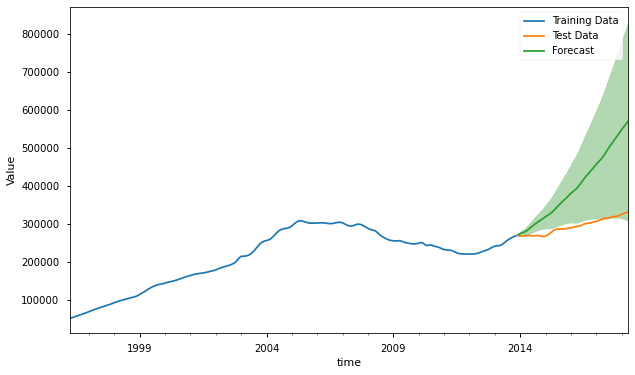

In [48]:
plot_train_test_forecast(train, test, forecast_df['Forecast'], forecast_df, forecast_df['Lower CI'], forecast_df['Upper CI'])

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               55449   No. Observations:                  265
Model:             SARIMAX(2, 1, 1)x(2, 1, [], 12)   Log Likelihood               -2233.415
Date:                             Tue, 29 Jun 2021   AIC                           4478.830
Time:                                     23:52:50   BIC                           4500.007
Sample:                                 04-01-1996   HQIC                          4487.351
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4795      1.786     -0.269      0.788      -3.979       3.020
ar.L2          0.5102      0.926      0.551      0.582      -1.305       2.325
ma.L1          0.9933      1.778      0.559      0.576      -2.492       4.478
ar.S.L12      -0.2890      0.024    -11.929      0.000      -0.336      -0.241
ar.S.L24      -0.2154      0.017    -12.849      0.000      -0.248      -0.183
sigma2      2.288e+06   7.23e-07   3.17e+12      0.000    2.29e+06    2.29e+06
===================================================================================
Ljung-Box (L1) (Q):                  38.16   Jarque-Bera (JB):              2226.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             1.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.4e+29. Standard errors may be unstable.
"""

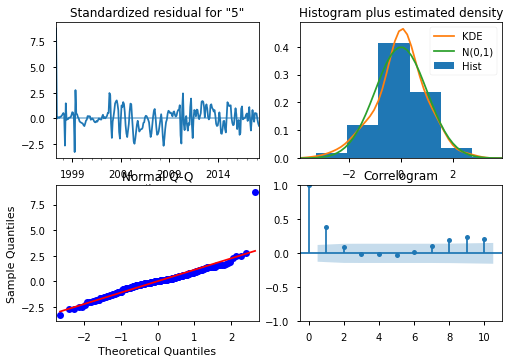

In [49]:
#Create and train SARIMAX model on the full time series
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

The above model performed well as shown by significant p values and an AIC of 4478.830. The diagnostics plots also look improved.

In [50]:
#Retrieve forecast for the next three years
retrieve_forecast(sarimax_model_full, steps=36)

Lower CI    Upper CI    Forecast
2018-05-01 329644.1526 335573.9125 332609.0326
2018-06-01 327699.6658 338457.8431 333078.7544
2018-07-01 326471.0658 341532.6309 334001.8484
2018-08-01 325993.0380 344849.4685 335421.2532
2018-09-01 325038.6753 347260.5552 336149.6152
2018-10-01 323827.7104 349068.5659 336448.1381
2018-11-01 323601.0157 351583.1932 337592.1044
2018-12-01 324326.7923 354827.0791 339576.9357
2019-01-01 325214.5123 358050.8238 341632.6681
2019-02-01 325781.7634 360803.8558 343292.8096
2019-03-01 326922.3955 364004.0269 345463.2112
2019-04-01 327797.5801 366831.5509 347314.5655
2019-05-01 327262.7089 369605.1523 348433.9306
2019-06-01 326137.6942 372375.6452 349256.6697
2019-07-01 325504.6518 375759.8944 350632.2731
2019-08-01 325033.3784 379219.1661 352126.2722
2019-09-01 323920.4262 381873.6590 352897.0426
2019-10-01 322555.0116 384096.0921 353325.5519
2019-11-01 322007.5712 386963.1347 354485.3529
2019-12-01 322319.2170 390530.8421 356425.0296
2020-01-01 322716.7574 394041.7593 358379.2583
2020-02-01 322759.6597 397070.8092 359915.2345
2020-03-01 323545.3352 400728.4978 362136.9165
2020-04-01 324313.5205 404266.4591 364289.9898
2020-05-01 323701.7131 407265.1128 365483.4130
2020-06-01 322379.5675 409913.2215 366146.3945
2020-07-01 321610.3962 413204.5427 367407.4694
2020-08-01 321176.2759 416791.2120 368983.7439
2020-09-01 320052.2665 419591.6632 369821.9649
2020-10-01 318539.5192 421887.5977 370213.5584
2020-11-01 317861.7583 424899.2943 371380.5263
2020-12-01 318073.7387 428686.0833 373379.9110
2021-01-01 318440.8168 432519.9042 375480.3605
2021-02-01 318381.3172 435827.0593 377104.1883
2021-03-01 318957.4107 439676.8103 379317.1105
2021-04-01 319461.6949 443368.9547 381415.3248
2021-05-01 318647.1146 446608.6499 382627.8823
2021-06-01 317057.1134 449465.5123 383261.3129
2021-07-01 315968.1837 452947.2646 384457.7241
2021-08-01 315225.0103 456763.9209 385994.4656
2021-09-01 313791.2979 459816.2218 386803.7599
2021-10-01 311972.3837 462384.2736 387178.3287
2021-11-01 310993.7362 465685.2963 388339.5162
2021-12-01 310899.2514 469764.0871 390331.6693
2022-01-01 310943.7311 473879.1310 392411.4310
2022-02-01 310582.3632 477491.4490 394036.9061
2022-03-01 310845.3980 481636.6517 396241.0248
2022-04-01 310996.4810 485584.3263 398290.4037
2022-05-01 309898.8477 489063.5444 399481.1961
2022-06-01 308111.7678 492203.9434 400157.8556
2022-07-01 306831.4364 495963.2295 401397.3329
2022-08-01 305846.2790 500009.8428 402928.0609
2022-09-01 304165.9013 503295.9155 403730.9084

In [51]:
#Create function to plot whole time series data and forecast

def plot_time_series_forecast(ts, forecast, forecast_df, LowerCI, UpperCI):
    ### Plot training data, test data, and forecast (with upper/,lower ci) 
    fig,ax = plt.subplots(figsize=(10,6))


    # Plotting time series data
    ts.plot(label='Training Data')
    ax.axvline(ts.index[-1],ls=':')

    ## Plotting Forefcast and CI
    forecast.plot(ax=ax,label='Forecast')
    ax.fill_between(forecast_df.index,
                        LowerCI, 
                        UpperCI,color='g',alpha=0.3)

    ax.set(ylabel='Value')
    ax.legend()
    
    return fig, ax

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

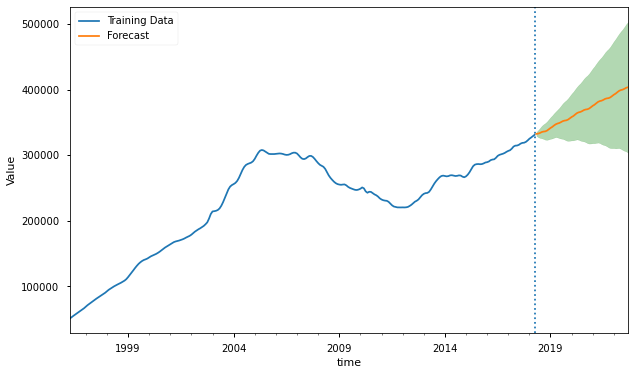

In [52]:
plot_time_series_forecast(ts, forecast_df['Forecast'], forecast_df, forecast_df['Lower CI'], forecast_df['Upper CI'])

In [53]:
#Create function to calculate and plot ROI of forecast and create dataframe
def calculate_roi(forecast):
    
    investment = forecast_df['Forecast'].iloc[0]
    roi = (forecast_df - investment)/investment
    roi.plot()
    plt.title('Forecasted ROI for next 3 Years')
    plt.xlabel('Time')
    plt.ylabel('ROI Percentage')
    plt.tight_layout()
    
    return roi


Lower CI  Upper CI  Forecast
2018-05-01   -0.0089    0.0089    0.0000
2018-06-01   -0.0148    0.0176    0.0014
2018-07-01   -0.0185    0.0268    0.0042
2018-08-01   -0.0199    0.0368    0.0085
2018-09-01   -0.0228    0.0441    0.0106
2018-10-01   -0.0264    0.0495    0.0115
2018-11-01   -0.0271    0.0570    0.0150
2018-12-01   -0.0249    0.0668    0.0209
2019-01-01   -0.0222    0.0765    0.0271
2019-02-01   -0.0205    0.0848    0.0321
2019-03-01   -0.0171    0.0944    0.0386
2019-04-01   -0.0145    0.1029    0.0442
2019-05-01   -0.0161    0.1112    0.0476
2019-06-01   -0.0195    0.1196    0.0501
2019-07-01   -0.0214    0.1297    0.0542
2019-08-01   -0.0228    0.1401    0.0587
2019-09-01   -0.0261    0.1481    0.0610
2019-10-01   -0.0302    0.1548    0.0623
2019-11-01   -0.0319    0.1634    0.0658
2019-12-01   -0.0309    0.1741    0.0716
2020-01-01   -0.0297    0.1847    0.0775
2020-02-01   -0.0296    0.1938    0.0821
2020-03-01   -0.0273    0.2048    0.0888
2020-04-01   -0.0249    0.2154    0.0952
2020-05-01   -0.0268    0.2245    0.0988
2020-06-01   -0.0308    0.2324    0.1008
2020-07-01   -0.0331    0.2423    0.1046
2020-08-01   -0.0344    0.2531    0.1094
2020-09-01   -0.0378    0.2615    0.1119
2020-10-01   -0.0423    0.2684    0.1131
2020-11-01   -0.0443    0.2775    0.1166
2020-12-01   -0.0437    0.2889    0.1226
2021-01-01   -0.0426    0.3004    0.1289
2021-02-01   -0.0428    0.3103    0.1338
2021-03-01   -0.0410    0.3219    0.1404
2021-04-01   -0.0395    0.3330    0.1467
2021-05-01   -0.0420    0.3427    0.1504
2021-06-01   -0.0468    0.3513    0.1523
2021-07-01   -0.0500    0.3618    0.1559
2021-08-01   -0.0523    0.3733    0.1605
2021-09-01   -0.0566    0.3825    0.1629
2021-10-01   -0.0620    0.3902    0.1641
2021-11-01   -0.0650    0.4001    0.1676
2021-12-01   -0.0653    0.4124    0.1735
2022-01-01   -0.0651    0.4247    0.1798
2022-02-01   -0.0662    0.4356    0.1847
2022-03-01   -0.0654    0.4481    0.1913
2022-04-01   -0.0650    0.4599    0.1975
2022-05-01   -0.0683    0.4704    0.2011
2022-06-01   -0.0737    0.4798    0.2031
2022-07-01   -0.0775    0.4911    0.2068
2022-08-01   -0.0805    0.5033    0.2114
2022-09-01   -0.0855    0.5132    0.2138

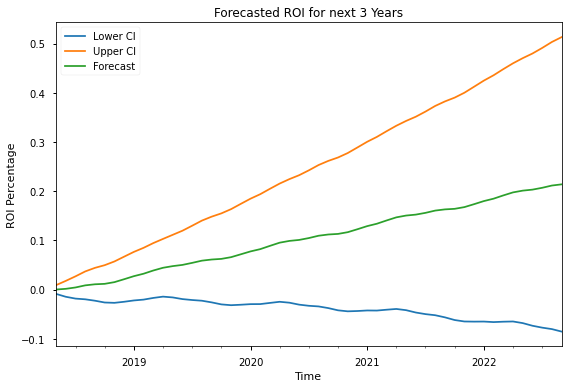

In [54]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 55449 has a predicted ROI of 21.4% after three years. However, the confidence interval ranges from -8% to 51.3%.

## Zipcode 55415

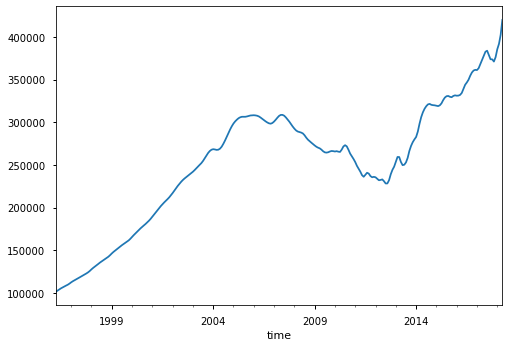

In [55]:
ts = all_time_series_df['55415']
ts.plot();

In [56]:
#Create train test split cutoff
tts_cutoff = round(len(ts)*0.80)
display(tts_cutoff)
    
## Use the tts cutoff to do Train test split and plot
train = ts.iloc[:tts_cutoff]
test = ts.iloc[tts_cutoff:]

212

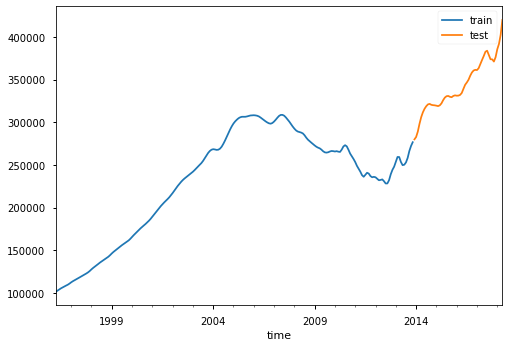

In [57]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.9241          15  ...  False        False

[1 rows x 6 columns]

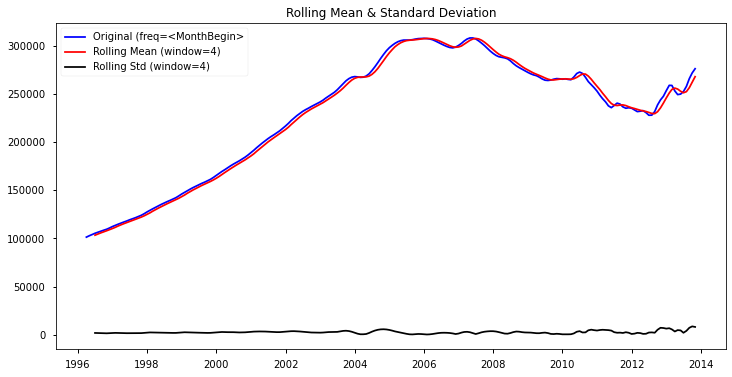

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.9241          15  ...  False        False

[1 rows x 6 columns]

In [58]:
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.6639          15  ...  False        False

[1 rows x 6 columns]

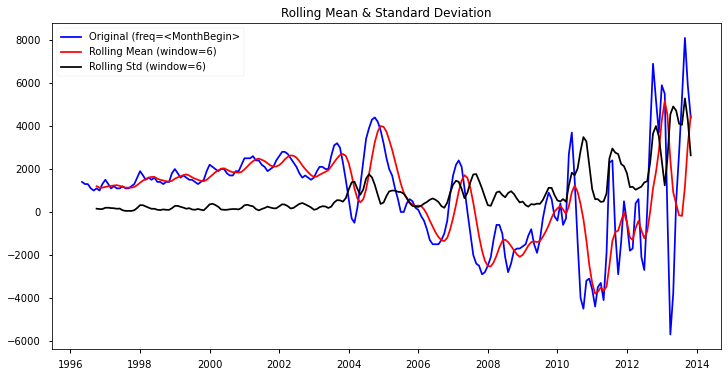

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.6639          15  ...  False        False

[1 rows x 6 columns]

In [59]:
stationarity_check(train.diff().dropna(), window=6)

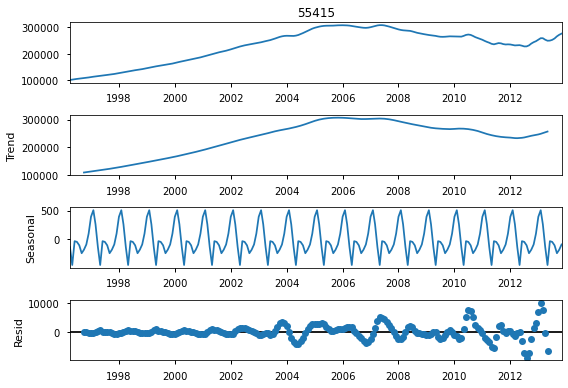

In [60]:
decompose = tsa.seasonal_decompose(train)
decompose.plot();

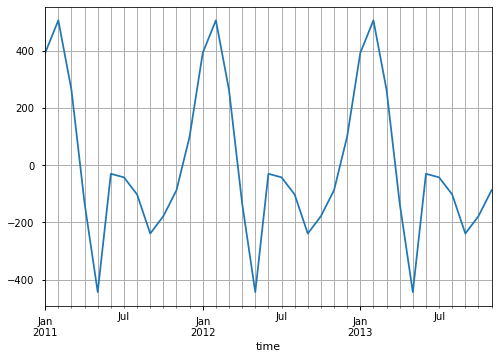

In [61]:
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3556.354, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3556.829, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3554.750, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=3553.213, Time=0.05 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=3554.755, Time=0.13 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=3555.127, Time=0.14 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=3555.016, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=3553.371, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=3555.129, Time=0.08 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 1.204 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1774.607
Date:                Tue, 29 Jun 2021   AIC                           3553.213
Time:                        23:52:54   BIC                           3559.907
Sample:                             0   HQIC                          3555.919
                                - 212                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0562      0.011      5.048      0.000       0.034       0.078
sigma2      1.253e+06   5.95e+04     21.055      0.000    1.14e+06    1.37e+06
===================================================================================
Ljung-Box (L1) (Q):                  31.77   Jarque-Bera (JB):               400.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              31.60   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

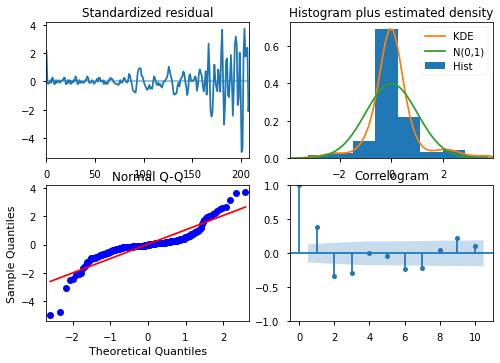

In [62]:
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3667.046, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3643.705, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3646.150, Time=0.27 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3645.536, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3643.339, Time=0.59 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=3644.919, Time=1.34 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.45 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3665.145, Time=0.15 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=3641.706, Time=0.77 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=3642.120, Time=0.36 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=3643.237, Time=1.46 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(2,1,0)(1,1,1)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  212
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1815.853
Date:                            Tue, 29 Jun 2021   AIC                           3641.706
Time:                                    23:53:14   BIC                           3658.172
Sample:                                         0   HQIC                          3648.370
                                            - 212                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1391      0.007     19.527      0.000       0.125       0.153
ar.L2          0.0547      0.017      3.227      0.001       0.021       0.088
ar.S.L12      -0.0883      0.023     -3.770      0.000      -0.134      -0.042
ar.S.L24      -0.0430      0.020     -2.177      0.029      -0.082      -0.004
sigma2      4.646e+06   4.53e-10   1.03e+16      0.000    4.65e+06    4.65e+06
===================================================================================
Ljung-Box (L1) (Q):                  87.25   Jarque-Bera (JB):                79.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.96   Skew:                             0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.05e+31. Standard errors may be unstable.
"""

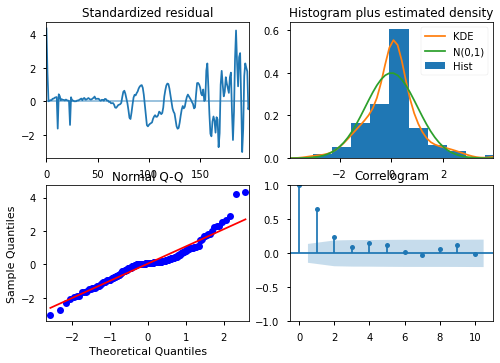

In [63]:
model = pmd.auto_arima(train, 
                       start_p=0, max_p=10,
                       start_P=0, max_P=10,
                       start_q=0, max_q=10,
                       start_Q=0, max_Q=10,
                       d=1, D=1,
                       m=12, 
                       trace=True)
display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              55415   No. Observations:                  212
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1815.853
Date:                            Tue, 29 Jun 2021   AIC                           3641.706
Time:                                    23:53:15   BIC                           3658.172
Sample:                                04-01-1996   HQIC                          3648.370
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1391      0.007     19.527      0.000       0.125       0.153
ar.L2          0.0547      0.017      3.227      0.001       0.021       0.088
ar.S.L12      -0.0883      0.023     -3.770      0.000      -0.134      -0.042
ar.S.L24      -0.0430      0.020     -2.177      0.029      -0.082      -0.004
sigma2      4.646e+06   4.53e-10   1.03e+16      0.000    4.65e+06    4.65e+06
===================================================================================
Ljung-Box (L1) (Q):                  87.25   Jarque-Bera (JB):                79.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.96   Skew:                             0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.05e+31. Standard errors may be unstable.
"""

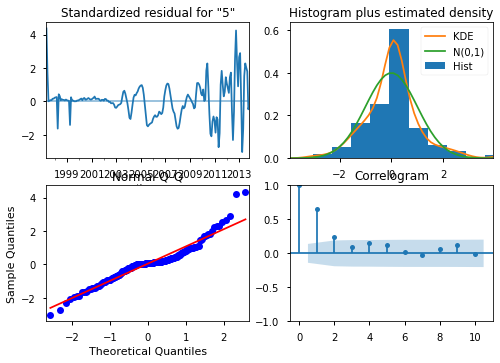

In [64]:
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [65]:
retrieve_forecast(sarimax_model, steps=len(test))

Lower CI    Upper CI    Forecast
2013-12-01 275614.9148 284064.0296 279839.4722
2014-01-01 278626.5341 291433.6803 285030.1072
2014-02-01 281568.8412 297972.9043 289770.8727
2014-03-01 279739.1871 299163.1209 289451.1540
2014-04-01 273100.3126 295160.1875 284130.2501
2014-05-01 268306.5551 292726.2429 280516.3990
2014-06-01 267508.9998 294081.8077 280795.4037
2014-07-01 268951.4276 297516.1029 283233.7652
2014-08-01 272960.2973 303386.8962 288173.5968
2014-09-01 279596.8329 311777.8598 295687.3463
2014-10-01 284331.5728 318176.2195 301253.8962
2014-11-01 287725.3791 323155.6211 305440.5001
2014-12-01 288670.9497 328494.8949 308582.9223
2015-01-01 291443.3577 335678.1734 313560.7655
2015-02-01 293817.1285 342291.6932 318054.4108
2015-03-01 291472.9381 343897.5339 317685.2360
2015-04-01 284535.8105 340650.9396 312593.3751
2015-05-01 279361.2530 338943.6340 309152.4435
2015-06-01 277908.9720 340769.1668 309339.0694
2015-07-01 278580.2398 344556.0432 311568.1415
2015-08-01 281840.5364 350791.4449 316315.9907
2015-09-01 287795.0082 359597.8963 323696.4522
2015-10-01 292062.5561 366608.4046 329335.4803
2015-11-01 294979.6529 372171.0571 333575.3550
2015-12-01 295784.2199 377708.1110 336746.1655
2016-01-01 298408.1712 385138.4799 341773.3256
2016-02-01 300593.2057 392049.7242 346321.4650
2016-03-01 297970.9055 393961.3198 345966.1127
2016-04-01 290670.8629 391004.5635 340837.7132
2016-05-01 285123.2370 389623.7676 337373.5023
2016-06-01 283323.4436 391832.1478 337577.7957
2016-07-01 283649.4223 396023.7922 339836.6072
2016-08-01 286561.1476 402672.6683 344616.9080
2016-09-01 292168.3101 411900.4261 352034.3681
2016-10-01 296058.1439 419304.5496 357681.3467
2016-11-01 298594.0855 425257.3171 361925.7013
2016-12-01 299163.7765 431032.5870 365098.1818
2017-01-01 301550.8718 438709.4179 370130.1449
2017-02-01 303484.4685 445883.7466 374684.1075
2017-03-01 300585.3503 448073.9759 374329.6631
2017-04-01 292984.4165 445404.8494 369194.6329
2017-05-01 287124.5154 444325.5563 365725.0358
2017-06-01 285010.9461 446852.5434 365931.7448
2017-07-01 285020.3977 451373.4769 368196.9373
2017-08-01 287609.8844 458355.3850 372982.6347
2017-09-01 292888.6855 467916.4426 380402.5641
2017-10-01 296441.8587 475649.5844 386045.7215
2017-11-01 298641.1889 481933.5871 390287.3880
2017-12-01 298976.2062 487940.7924 393458.4993
2018-01-01 301128.0849 495847.7470 398487.9160
2018-02-01 302819.0360 503259.0025 403039.0192
2018-03-01 299667.6908 505700.1088 402683.8998
2018-04-01 291806.9998 503295.0553 397551.0276

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

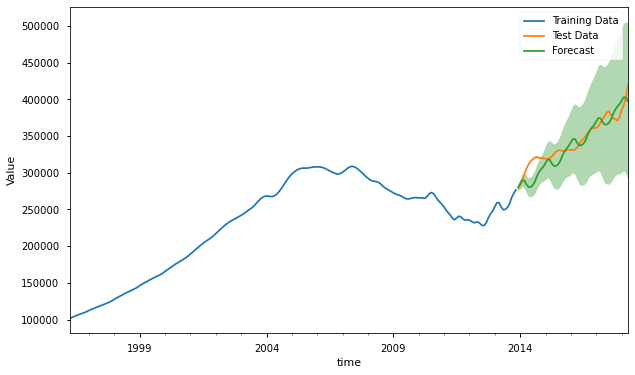

In [66]:
plot_train_test_forecast(train, test, forecast_df['Forecast'], forecast_df, forecast_df['Lower CI'], forecast_df['Upper CI'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              55415   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2354.096
Date:                            Tue, 29 Jun 2021   AIC                           4718.192
Time:                                    23:53:17   BIC                           4735.839
Sample:                                04-01-1996   HQIC                          4725.292
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2131      0.007     31.215      0.000       0.200       0.226
ar.L2          0.0788      0.017      4.737      0.000       0.046       0.111
ar.S.L12      -0.1504      0.017     -8.667      0.000      -0.184      -0.116
ar.S.L24      -0.0812      0.013     -6.156      0.000      -0.107      -0.055
sigma2      7.193e+06   6.94e-11   1.04e+17      0.000    7.19e+06    7.19e+06
===================================================================================
Ljung-Box (L1) (Q):                  81.88   Jarque-Bera (JB):               398.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.41   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+32. Standard errors may be unstable.
"""

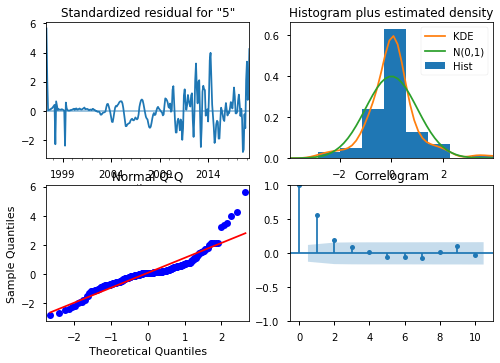

In [67]:
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [68]:
retrieve_forecast(sarimax_model_full, steps=36)

Lower CI    Upper CI    Forecast
2018-05-01 422489.3103 433002.5670 427745.9386
2018-06-01 426030.3029 442558.4190 434294.3609
2018-07-01 425409.4759 447108.3746 436258.9252
2018-08-01 419474.4163 445579.9863 432527.2013
2018-09-01 413647.2735 443613.9159 428630.5947
2018-10-01 412102.9025 445521.6451 428812.2738
2018-11-01 408622.5065 445181.8598 426902.1832
2018-12-01 411626.7593 451082.4146 431354.5869
2019-01-01 418127.8475 460283.1544 439205.5010
2019-02-01 422380.0379 467072.9404 444726.4892
2019-03-01 430582.7964 477677.0361 454129.9162
2019-04-01 444827.4680 494206.5120 469516.9900
2019-05-01 449496.0461 504302.2403 476899.1432
2019-06-01 452927.8062 513452.8940 483190.3501
2019-07-01 452066.8588 518256.5200 485161.6894
2019-08-01 446128.7520 517680.9007 481904.8264
2019-09-01 440329.4880 516929.7844 478629.6362
2019-10-01 438406.4451 519764.5998 479085.5224
2019-11-01 434538.6339 520400.1851 477469.4095
2019-12-01 436598.3623 526741.9886 481670.1754
2020-01-01 441843.4682 536076.1073 488959.7878
2020-02-01 445197.2726 543349.2390 494273.2558
2020-03-01 452425.4115 554346.3024 503385.8570
2020-04-01 465282.1371 570837.5456 518059.8414
2020-05-01 469521.3976 580975.1437 525248.2707
2020-06-01 472647.9825 590256.9686 531452.4756
2020-07-01 471472.8239 595248.6444 533360.7342
2020-08-01 465050.9108 594808.0863 529929.4985
2020-09-01 458711.1639 594231.3889 526471.2764
2020-10-01 456330.4506 597395.6590 526863.0548
2020-11-01 451943.1265 598350.3199 525146.7232
2020-12-01 453656.0607 605219.7489 529437.9048
2021-01-01 458653.8237 615205.3124 536929.5681
2021-02-01 461644.6704 623030.2965 542337.4835
2021-03-01 468551.3170 634630.5958 551590.9564
2021-04-01 481221.7355 651865.6797 566543.7076
2021-05-01 485200.5355 662397.3073 573798.9214
2021-06-01 488038.3798 672035.8023 580037.0910
2021-07-01 486537.2469 677371.3283 581954.2876
2021-08-01 479746.1519 677275.3150 578510.7334
2021-09-01 473006.9682 677052.2297 575029.5990
2021-10-01 470221.2074 680596.3159 575408.7616
2021-11-01 465420.5303 681946.7515 573683.6409
2021-12-01 466726.7475 689236.5510 577981.6493
2022-01-01 471319.6775 699657.2917 585488.4846
2022-02-01 473888.6762 707909.4023 590899.0392
2022-03-01 480370.3241 719939.5376 600154.9309
2022-04-01 492627.5693 737619.7035 615123.6364
2022-05-01 496290.2587 748478.8019 622384.5303
2022-06-01 498818.6839 758430.6231 628624.6535
2022-07-01 497007.4569 764083.7954 630545.6261
2022-08-01 489906.8147 764329.3434 627118.0791
2022-09-01 482848.4539 764462.0422 623655.2480

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

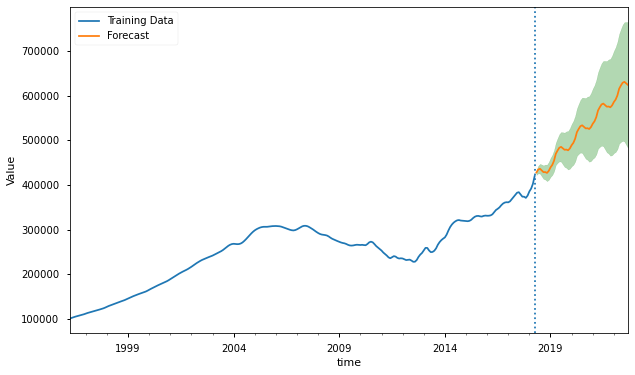

In [69]:
plot_time_series_forecast(ts, forecast_df['Forecast'], forecast_df, forecast_df['Lower CI'], forecast_df['Upper CI'])

Lower CI  Upper CI  Forecast
2018-05-01   -0.0123    0.0123    0.0000
2018-06-01   -0.0040    0.0346    0.0153
2018-07-01   -0.0055    0.0453    0.0199
2018-08-01   -0.0193    0.0417    0.0112
2018-09-01   -0.0330    0.0371    0.0021
2018-10-01   -0.0366    0.0416    0.0025
2018-11-01   -0.0447    0.0408   -0.0020
2018-12-01   -0.0377    0.0546    0.0084
2019-01-01   -0.0225    0.0761    0.0268
2019-02-01   -0.0125    0.0919    0.0397
2019-03-01    0.0066    0.1167    0.0617
2019-04-01    0.0399    0.1554    0.0977
2019-05-01    0.0508    0.1790    0.1149
2019-06-01    0.0589    0.2004    0.1296
2019-07-01    0.0569    0.2116    0.1342
2019-08-01    0.0430    0.2103    0.1266
2019-09-01    0.0294    0.2085    0.1190
2019-10-01    0.0249    0.2151    0.1200
2019-11-01    0.0159    0.2166    0.1162
2019-12-01    0.0207    0.2314    0.1261
2020-01-01    0.0330    0.2533    0.1431
2020-02-01    0.0408    0.2703    0.1555
2020-03-01    0.0577    0.2960    0.1768
2020-04-01    0.0878    0.3345    0.2111
2020-05-01    0.0977    0.3582    0.2279
2020-06-01    0.1050    0.3799    0.2424
2020-07-01    0.1022    0.3916    0.2469
2020-08-01    0.0872    0.3906    0.2389
2020-09-01    0.0724    0.3892    0.2308
2020-10-01    0.0668    0.3966    0.2317
2020-11-01    0.0566    0.3988    0.2277
2020-12-01    0.0606    0.4149    0.2377
2021-01-01    0.0723    0.4382    0.2553
2021-02-01    0.0792    0.4565    0.2679
2021-03-01    0.0954    0.4837    0.2895
2021-04-01    0.1250    0.5240    0.3245
2021-05-01    0.1343    0.5486    0.3414
2021-06-01    0.1410    0.5711    0.3560
2021-07-01    0.1374    0.5836    0.3605
2021-08-01    0.1216    0.5834    0.3525
2021-09-01    0.1058    0.5828    0.3443
2021-10-01    0.0993    0.5911    0.3452
2021-11-01    0.0881    0.5943    0.3412
2021-12-01    0.0911    0.6113    0.3512
2022-01-01    0.1019    0.6357    0.3688
2022-02-01    0.1079    0.6550    0.3814
2022-03-01    0.1230    0.6831    0.4031
2022-04-01    0.1517    0.7244    0.4381
2022-05-01    0.1602    0.7498    0.4550
2022-06-01    0.1662    0.7731    0.4696
2022-07-01    0.1619    0.7863    0.4741
2022-08-01    0.1453    0.7869    0.4661
2022-09-01    0.1288    0.7872    0.4580

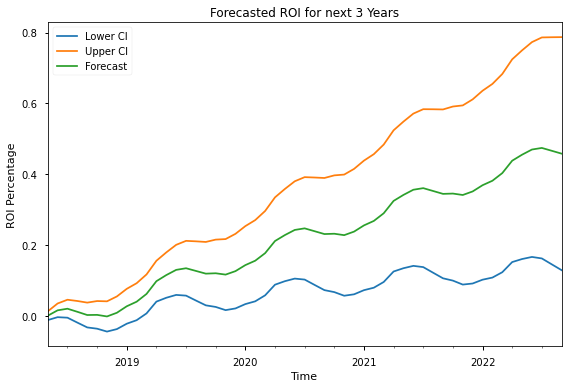

In [70]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 55415 has a predicted ROI of 45.8% after three years. However, the confidence interval ranges from 12.8% to 78.7%

## Zipcode 56466

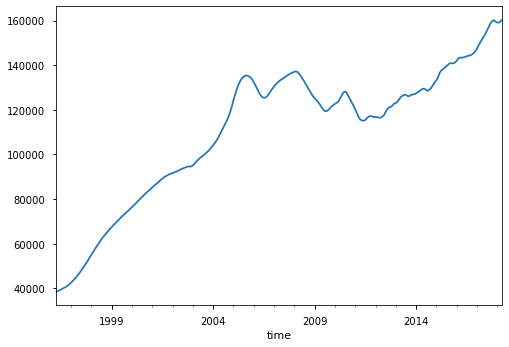

In [71]:
ts = all_time_series_df['56466']
ts.plot();

In [72]:
#Create train test split cutoff
tts_cutoff = round(len(ts)*0.80)
display(tts_cutoff)
    
## Use the tts cutoff to do Train test split and plot
train = ts.iloc[:tts_cutoff]
test = ts.iloc[tts_cutoff:]

212

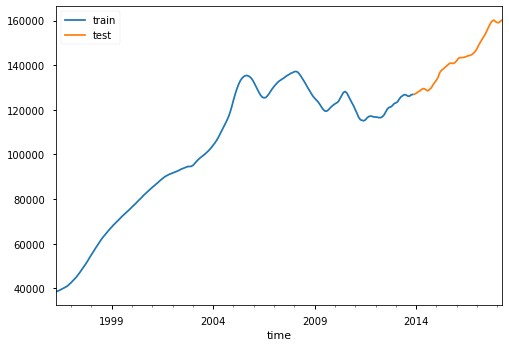

In [73]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.7173           7  ...  False        False

[1 rows x 6 columns]

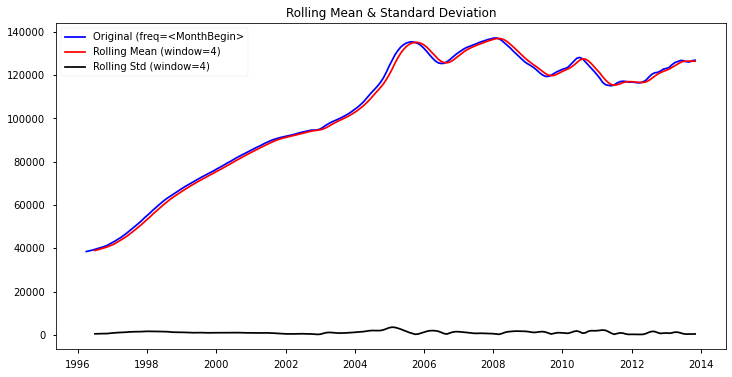

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.7173           7  ...  False        False

[1 rows x 6 columns]

In [74]:
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -4.2442           6  ...   True         True

[1 rows x 6 columns]

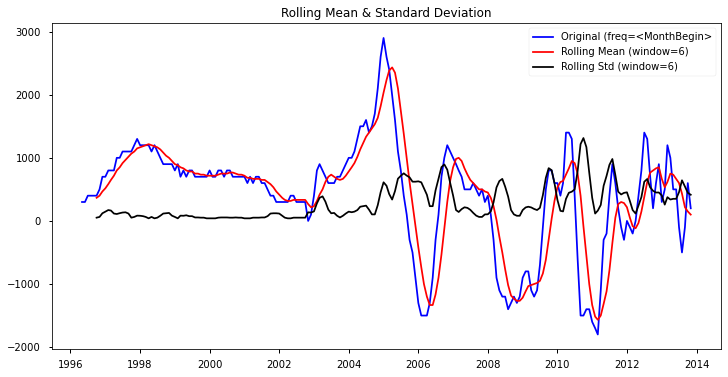

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -4.2442           6  ...   True         True

[1 rows x 6 columns]

In [75]:
stationarity_check(train.diff().dropna(), window=6)

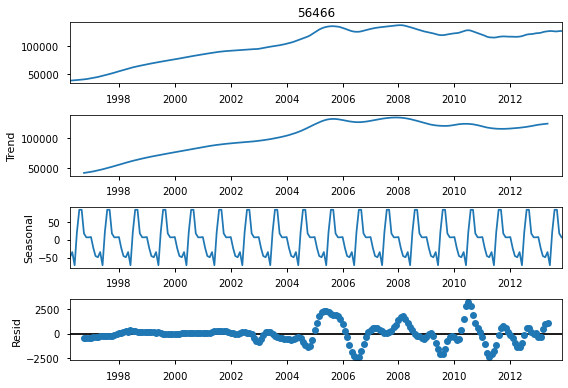

In [76]:
decompose = tsa.seasonal_decompose(train)
decompose.plot();

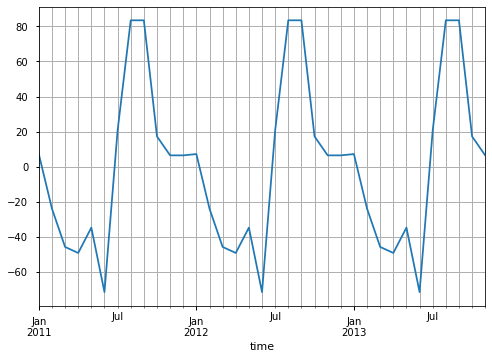

In [77]:
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=2962.335, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=2913.332, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=2907.291, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=2917.668, Time=0.03 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=2905.733, Time=0.25 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=2909.382, Time=0.07 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=2909.851, Time=0.43 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=2908.918, Time=0.72 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=2907.750, Time=0.26 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=2908.378, Time=0.14 sec
 ARIMA(0,2,1)(2,0,2)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=2946.719, Time=0.19 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=2906.256, Time=0.26 sec
 ARIMA(0,2,2)(1,0,1)[12]             : AIC=2906.101, Time=0.36 sec
 ARIMA(1,2,0)(1,0,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  212
Model:             SARIMAX(1, 2, 2)x(1, 0, [1], 12)   Log Likelihood               -1443.399
Date:                              Tue, 29 Jun 2021   AIC                           2898.798
Time:                                      23:53:33   BIC                           2918.880
Sample:                                           0   HQIC                          2906.916
                                              - 212                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9463      0.047    -20.099      0.000      -1.039      -0.854
ma.L1          1.4259      0.048     29.616      0.000       1.331       1.520
ma.L2          0.5026      0.038     13.088      0.000       0.427       0.578
ar.S.L12       0.4979      0.084      5.914      0.000       0.333       0.663
ma.S.L12      -0.8135      0.071    -11.509      0.000      -0.952      -0.675
sigma2      4.534e+04   3427.993     13.227      0.000    3.86e+04    5.21e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.71   Jarque-Bera (JB):                 9.39
Prob(Q):                              0.19   Prob(JB):                         0.01
Heteroskedasticity (H):               5.51   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

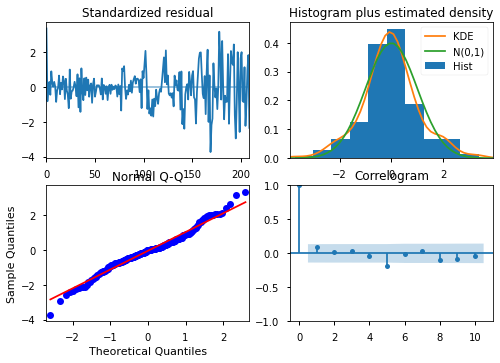

In [78]:
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3412.750, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3124.054, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3283.933, Time=0.36 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3165.480, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3102.745, Time=0.40 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=3103.672, Time=0.74 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=3093.970, Time=1.36 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=3090.383, Time=0.42 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=3088.596, Time=0.27 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=3090.374, Time=0.83 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=1.45 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3366.099, Time=0.16 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=3074.527, Time=0.47 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=3156.356, Time=0.09 sec
 ARIMA(2,1,0)(1,1,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  212
Model:             SARIMAX(4, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -1529.323
Date:                              Tue, 29 Jun 2021   AIC                           3072.645
Time:                                      23:54:08   BIC                           3095.698
Sample:                                           0   HQIC                          3081.975
                                              - 212                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -7.2308      2.356     -3.069      0.002     -11.848      -2.613
ar.L1          1.1770      0.027     43.963      0.000       1.125       1.229
ar.L2         -0.4564      0.053     -8.613      0.000      -0.560      -0.353
ar.L3          0.2333      0.060      3.885      0.000       0.116       0.351
ar.L4         -0.1005      0.039     -2.592      0.010      -0.176      -0.024
ma.S.L12      -0.8738      0.050    -17.328      0.000      -0.973      -0.775
sigma2      4.834e+04   4258.576     11.351      0.000       4e+04    5.67e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.64   Jarque-Bera (JB):              6727.66
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             3.33
Prob(H) (two-sided):                  0.32   Kurtosis:                        30.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

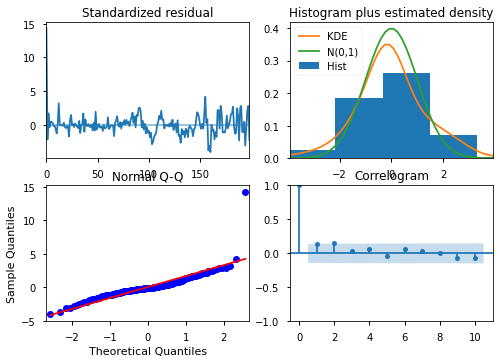

In [79]:
model = pmd.auto_arima(train, 
                       start_p=0, max_p=10,
                       start_P=0, max_P=10,
                       start_q=0, max_q=10,
                       start_Q=0, max_Q=10,
                       d=1, D=1,
                       m=12, 
                       trace=True)
display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                56466   No. Observations:                  212
Model:             SARIMAX(4, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -1531.009
Date:                              Tue, 29 Jun 2021   AIC                           3074.019
Time:                                      23:54:09   BIC                           3093.779
Sample:                                  04-01-1996   HQIC                          3082.016
                                       - 11-01-2013                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1700      0.026     44.382      0.000       1.118       1.222
ar.L2         -0.4475      0.052     -8.526      0.000      -0.550      -0.345
ar.L3          0.2278      0.061      3.757      0.000       0.109       0.347
ar.L4         -0.0904      0.040     -2.285      0.022      -0.168      -0.013
ma.S.L12      -0.8136      0.041    -19.781      0.000      -0.894      -0.733
sigma2      5.223e+04   4018.999     12.995      0.000    4.44e+04    6.01e+04
===================================================================================
Ljung-Box (L1) (Q):                   4.03   Jarque-Bera (JB):              7305.36
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             3.41
Prob(H) (two-sided):                  0.32   Kurtosis:                        31.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

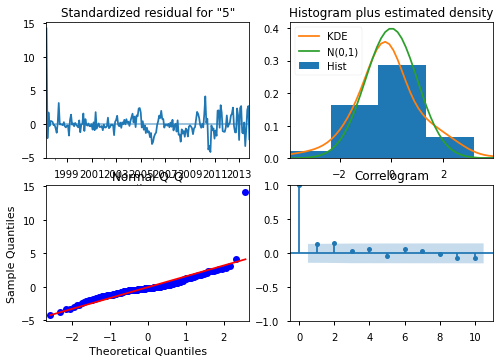

In [80]:
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [81]:
retrieve_forecast(sarimax_model, steps=len(test))

Lower CI    Upper CI    Forecast
2013-12-01 126447.1127 127343.0769 126895.0948
2014-01-01 125851.4671 127992.2206 126921.8439
2014-02-01 125186.9505 128687.5954 126937.2730
2014-03-01 124562.6258 129492.1393 127027.3826
2014-04-01 124003.9508 130402.3339 127203.1424
2014-05-01 123478.6888 131341.9176 127410.3032
2014-06-01 123037.9796 132334.1241 127686.0518
2014-07-01 122636.6234 133321.5727 127979.0980
2014-08-01 122172.8368 134196.1828 128184.5098
2014-09-01 121663.1025 134971.4487 128317.2756
2014-10-01 121217.6013 135757.4308 128487.5161
2014-11-01 120771.1415 136490.5473 128630.8444
2014-12-01 120285.9896 137196.4578 128741.2237
2015-01-01 119750.5613 137867.9788 128809.2700
2015-02-01 119186.8720 138507.8456 128847.3588
2015-03-01 118720.9389 139232.8348 128976.8868
2015-04-01 118345.1584 140030.0726 129187.6155
2015-05-01 118002.2186 140836.7425 129419.4805
2015-06-01 117736.8920 141693.9427 129715.4174
2015-07-01 117500.0159 142550.8501 130025.4330
2015-08-01 117186.4840 143301.7813 130244.1327
2015-09-01 116811.9429 143962.4937 130387.2183
2015-10-01 116487.0040 144644.2524 130565.6282
2015-11-01 116147.1965 145283.5840 130715.3903
2015-12-01 115765.1208 145896.4623 130830.7916
2016-01-01 115328.9057 146476.6203 130902.7630
2016-02-01 114857.1788 147030.6697 130943.9243
2016-03-01 114474.7770 147676.9297 131075.8533
2016-04-01 114173.8304 148403.0829 131288.4566
2016-05-01 113896.9362 149146.6353 131521.7858
2016-06-01 113689.1300 149948.6022 131818.8661
2016-07-01 113501.7895 150757.7595 132129.7745
2016-08-01 113230.4488 151467.8935 132349.1711
2016-09-01 112891.4179 152094.1837 132492.8008
2016-10-01 112595.9647 152747.3064 132671.6356
2016-11-01 112280.2405 153363.2180 132821.7293
2016-12-01 111920.9954 153953.7834 132937.3894
2017-01-01 111506.8023 154512.3236 133009.5629
2017-02-01 111055.2734 155046.4906 133050.8820
2017-03-01 110690.8141 155675.0542 133182.9342
2017-04-01 110405.3566 156385.9105 133395.6336
2017-05-01 110141.2980 157116.7776 133629.0378
2017-06-01 109943.5914 157908.7620 133926.1767
2017-07-01 109763.6549 158710.6067 134237.1308
2017-08-01 109497.1254 159416.0009 134456.5631
2017-09-01 109160.4507 160039.9908 134600.2207
2017-10-01 108865.0598 160693.0946 134779.0772
2017-11-01 108547.2748 161311.1010 134929.1879
2017-12-01 108185.9694 161903.7532 135044.8613
2018-01-01 107769.9574 162464.1329 135117.0452
2018-02-01 107316.2732 163000.4713 135158.3723
2018-03-01 106949.0298 163631.8317 135290.4308
2018-04-01 106659.9819 164346.2883 135503.1351

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

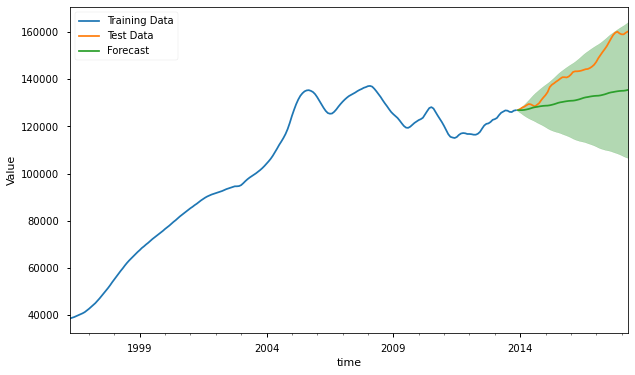

In [82]:
plot_train_test_forecast(train, test, forecast_df['Forecast'], forecast_df, forecast_df['Lower CI'], forecast_df['Upper CI'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                56466   No. Observations:                  265
Model:             SARIMAX(4, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -1943.494
Date:                              Tue, 29 Jun 2021   AIC                           3898.988
Time:                                      23:54:10   BIC                           3920.164
Sample:                                  04-01-1996   HQIC                          3907.509
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0314      0.024     43.324      0.000       0.985       1.078
ar.L2         -0.2627      0.051     -5.142      0.000      -0.363      -0.163
ar.L3          0.0812      0.059      1.374      0.169      -0.035       0.197
ar.L4         -0.0042      0.039     -0.106      0.916      -0.081       0.073
ma.S.L12      -0.8832      0.039    -22.482      0.000      -0.960      -0.806
sigma2       7.38e+04   4865.378     15.168      0.000    6.43e+04    8.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   5.09   Jarque-Bera (JB):              8228.35
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             3.06
Prob(H) (two-sided):                  0.15   Kurtosis:                        30.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

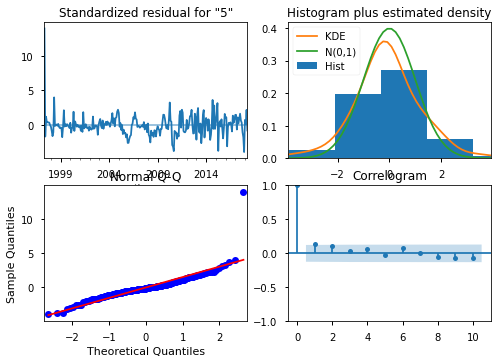

In [83]:
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [84]:
retrieve_forecast(sarimax_model_full, steps=36)

Lower CI    Upper CI    Forecast
2018-05-01 160123.0303 161188.4758 160655.7530
2018-06-01 159821.1600 162233.4643 161027.3121
2018-07-01 159502.3227 163365.7147 161434.0187
2018-08-01 159152.2184 164498.7306 161825.4745
2018-09-01 158820.2255 165653.8289 162237.0272
2018-10-01 158430.2146 166735.5316 162582.8731
2018-11-01 158045.0743 167793.0572 162919.0657
2018-12-01 157599.7550 168752.9125 163176.3337
2019-01-01 157293.8599 169810.0450 163551.9525
2019-02-01 157152.2391 170987.1411 164069.6901
2019-03-01 157097.6482 172206.4234 164652.0358
2019-04-01 156971.1135 173309.4521 165140.2828
2019-05-01 156768.3355 174338.9508 165553.6431
2019-06-01 156574.9213 175377.0568 165975.9891
2019-07-01 156409.6285 176429.3346 166419.4816
2019-08-01 156232.4239 177448.1099 166840.2669
2019-09-01 156083.1557 178469.4299 167276.2928
2019-10-01 155877.7544 179407.1510 167642.4527
2019-11-01 155673.3764 180317.4196 167995.3980
2019-12-01 155401.4815 181131.4675 168266.4745
2020-01-01 155259.7129 182047.2529 168653.4829
2020-02-01 155271.9292 183089.3048 169180.6170
2020-03-01 155360.5223 184180.9062 169770.7143
2020-04-01 155366.5636 185164.1478 170265.3557
2020-05-01 155293.3282 186074.6537 170683.9909
2020-06-01 155224.9047 186996.4718 171110.6883
2020-07-01 155177.5494 187937.9914 171557.7704
2020-08-01 155110.1213 188852.9125 171981.5169
2020-09-01 155062.2093 189777.7616 172419.9855
2020-10-01 154949.8661 190626.4547 172788.1604
2020-11-01 154830.5769 191454.9591 173142.7680
2020-12-01 154636.2498 192194.1816 173415.2157
2021-01-01 154565.0346 193041.6761 173803.3553
2021-02-01 154641.3141 194021.5311 174331.4226
2021-03-01 154787.9973 195056.5819 174922.2896
2021-04-01 154846.6510 195988.4811 175417.5661
2021-05-01 154823.9179 196849.5324 175836.7251
2021-06-01 154803.8644 197723.8448 176263.8546
2021-07-01 154802.0750 198620.5114 176711.2932
2021-08-01 154777.0836 199493.5838 177135.3337
2021-09-01 154768.3932 200379.6966 177574.0449
2021-10-01 154692.0757 201192.7642 177942.4199
2021-11-01 154605.6987 201988.6865 178297.1926
2021-12-01 154441.2961 202698.2569 178569.7765
2022-01-01 154397.1697 203518.8872 178958.0285
2022-02-01 154497.8679 204474.5089 179486.1884
2022-03-01 154666.4705 205487.7932 180077.1318
2022-04-01 154744.7134 206400.2293 180572.4713
2022-05-01 154740.9653 207242.3995 180991.6824
2022-06-01 154739.2891 208098.4205 181418.8548
2022-07-01 154754.8897 208977.7678 181866.3288
2022-08-01 154746.0810 209834.7161 182290.3985
2022-09-01 154752.2635 210706.0041 182729.1338

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

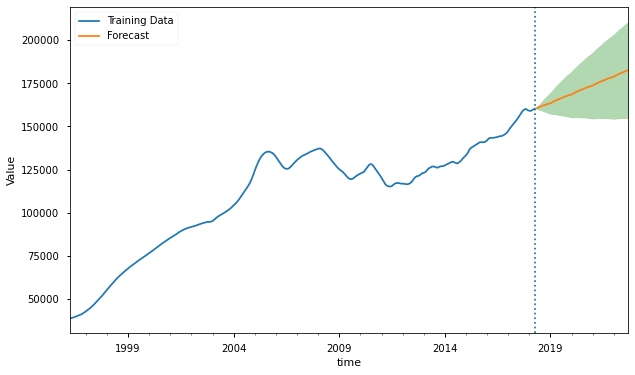

In [85]:
plot_time_series_forecast(ts, forecast_df['Forecast'], forecast_df, forecast_df['Lower CI'], forecast_df['Upper CI'])

Lower CI  Upper CI  Forecast
2018-05-01   -0.0033    0.0033    0.0000
2018-06-01   -0.0052    0.0098    0.0023
2018-07-01   -0.0072    0.0169    0.0048
2018-08-01   -0.0094    0.0239    0.0073
2018-09-01   -0.0114    0.0311    0.0098
2018-10-01   -0.0139    0.0378    0.0120
2018-11-01   -0.0163    0.0444    0.0141
2018-12-01   -0.0190    0.0504    0.0157
2019-01-01   -0.0209    0.0570    0.0180
2019-02-01   -0.0218    0.0643    0.0213
2019-03-01   -0.0221    0.0719    0.0249
2019-04-01   -0.0229    0.0788    0.0279
2019-05-01   -0.0242    0.0852    0.0305
2019-06-01   -0.0254    0.0916    0.0331
2019-07-01   -0.0264    0.0982    0.0359
2019-08-01   -0.0275    0.1045    0.0385
2019-09-01   -0.0285    0.1109    0.0412
2019-10-01   -0.0297    0.1167    0.0435
2019-11-01   -0.0310    0.1224    0.0457
2019-12-01   -0.0327    0.1275    0.0474
2020-01-01   -0.0336    0.1332    0.0498
2020-02-01   -0.0335    0.1396    0.0531
2020-03-01   -0.0330    0.1464    0.0567
2020-04-01   -0.0329    0.1526    0.0598
2020-05-01   -0.0334    0.1582    0.0624
2020-06-01   -0.0338    0.1640    0.0651
2020-07-01   -0.0341    0.1698    0.0679
2020-08-01   -0.0345    0.1755    0.0705
2020-09-01   -0.0348    0.1813    0.0732
2020-10-01   -0.0355    0.1866    0.0755
2020-11-01   -0.0363    0.1917    0.0777
2020-12-01   -0.0375    0.1963    0.0794
2021-01-01   -0.0379    0.2016    0.0818
2021-02-01   -0.0374    0.2077    0.0851
2021-03-01   -0.0365    0.2141    0.0888
2021-04-01   -0.0362    0.2199    0.0919
2021-05-01   -0.0363    0.2253    0.0945
2021-06-01   -0.0364    0.2307    0.0972
2021-07-01   -0.0364    0.2363    0.0999
2021-08-01   -0.0366    0.2417    0.1026
2021-09-01   -0.0366    0.2473    0.1053
2021-10-01   -0.0371    0.2523    0.1076
2021-11-01   -0.0377    0.2573    0.1098
2021-12-01   -0.0387    0.2617    0.1115
2022-01-01   -0.0390    0.2668    0.1139
2022-02-01   -0.0383    0.2727    0.1172
2022-03-01   -0.0373    0.2791    0.1209
2022-04-01   -0.0368    0.2847    0.1240
2022-05-01   -0.0368    0.2900    0.1266
2022-06-01   -0.0368    0.2953    0.1292
2022-07-01   -0.0367    0.3008    0.1320
2022-08-01   -0.0368    0.3061    0.1347
2022-09-01   -0.0367    0.3115    0.1374

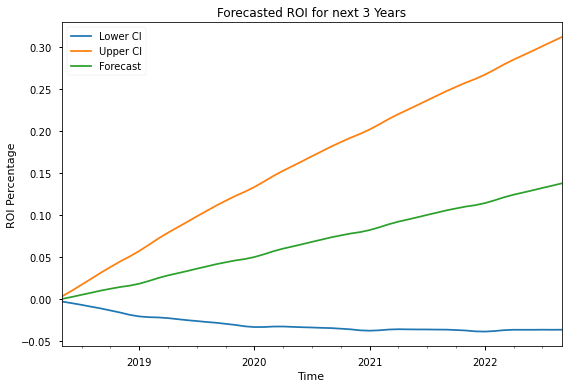

In [86]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 56466 has a predicted ROI of 13.7% after three years. However, the confidence interval ranges from -3.7% to 31.5%

## Zipcode 56554

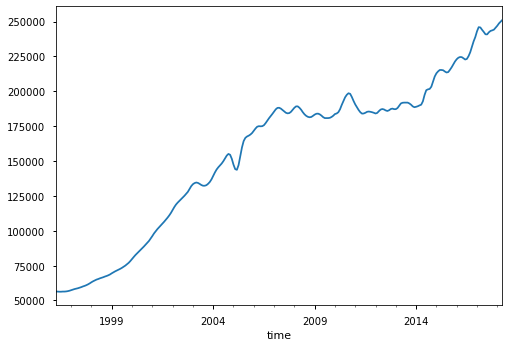

In [87]:
ts = all_time_series_df['56554']
ts.plot();

In [88]:
#Create train test split cutoff
tts_cutoff = round(len(ts)*0.80)
display(tts_cutoff)
    
## Use the tts cutoff to do Train test split and plot
train = ts.iloc[:tts_cutoff]
test = ts.iloc[tts_cutoff:]

212

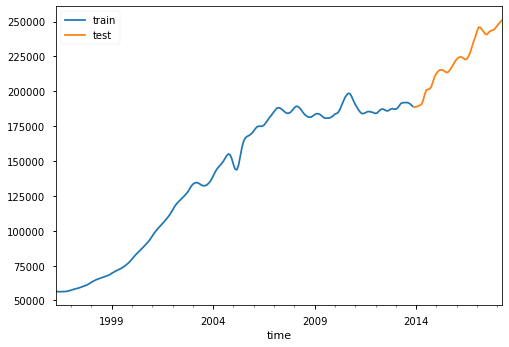

In [89]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.0561           5  ...  False        False

[1 rows x 6 columns]

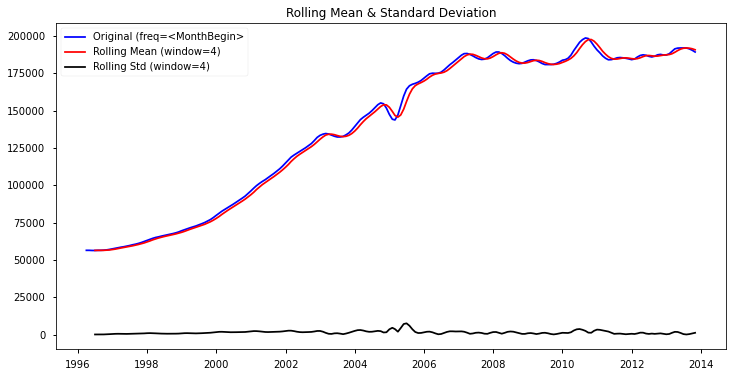

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.0561           5  ...  False        False

[1 rows x 6 columns]

In [90]:
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -5.1395           4  ...   True         True

[1 rows x 6 columns]

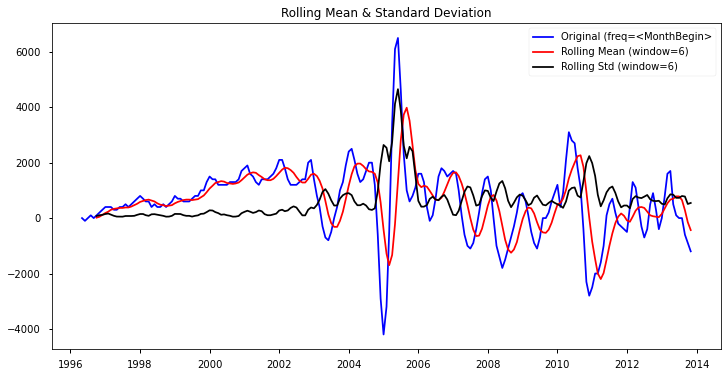

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -5.1395           4  ...   True         True

[1 rows x 6 columns]

In [91]:
stationarity_check(train.diff().dropna(), window=6)

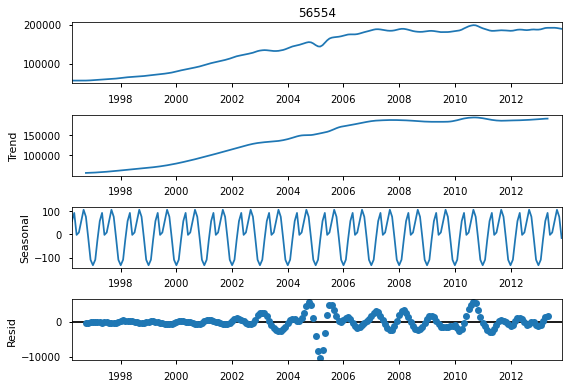

In [92]:
decompose = tsa.seasonal_decompose(train)
decompose.plot();

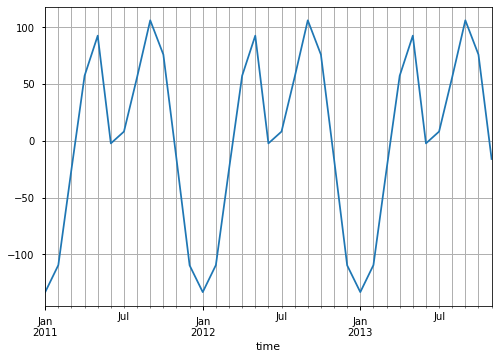

In [93]:
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3325.304, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3274.428, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3279.800, Time=0.15 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=3274.250, Time=0.04 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=3274.846, Time=0.04 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=3271.363, Time=0.11 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=3272.914, Time=0.25 sec
 ARIMA(1,2,0)(1,0,2)[12]             : AIC=3272.991, Time=0.32 sec
 ARIMA(1,2,0)(0,0,2)[12]             : AIC=3274.795, Time=0.13 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=3275.930, Time=0.08 sec
 ARIMA(1,2,0)(2,0,2)[12]             : AIC=3273.119, Time=0.99 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=3324.574, Time=0.21 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=3256.054, Time=0.14 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=3261.937, Time=0.05 sec
 ARIMA(2,2,0)(1,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  212
Model:             SARIMAX(2, 2, 1)x(1, 0, 1, 12)   Log Likelihood               -1601.543
Date:                            Tue, 29 Jun 2021   AIC                           3215.086
Time:                                    23:54:32   BIC                           3235.169
Sample:                                         0   HQIC                          3223.205
                                            - 212                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3140      0.027     49.402      0.000       1.262       1.366
ar.L2         -0.5525      0.014    -39.961      0.000      -0.580      -0.525
ma.L1         -0.9001      0.042    -21.463      0.000      -0.982      -0.818
ar.S.L12       0.6219      0.137      4.549      0.000       0.354       0.890
ma.S.L12      -0.7724      0.126     -6.135      0.000      -1.019      -0.526
sigma2      1.298e+05   1.07e+04     12.108      0.000    1.09e+05    1.51e+05
===================================================================================
Ljung-Box (L1) (Q):                  20.61   Jarque-Bera (JB):               663.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             1.28
Prob(H) (two-sided):                  0.62   Kurtosis:                        11.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

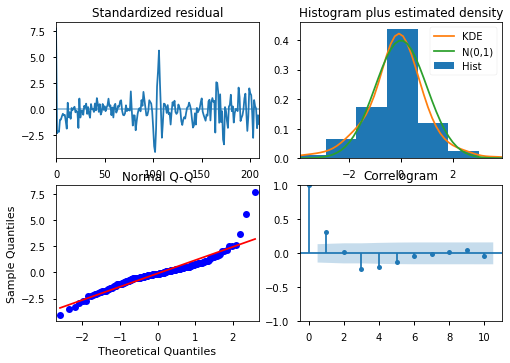

In [94]:
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3550.337, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3479.564, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3493.910, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3488.408, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3475.352, Time=0.69 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=3473.027, Time=1.52 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=3470.325, Time=2.57 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=3471.826, Time=4.50 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=3472.146, Time=4.88 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.68 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=6.33 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=3521.250, Time=0.58 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=3469.228, Time=1.99 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=3472.017, Time=1.21 sec
 ARIMA(2,1,0)(5,1,0)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  212
Model:             SARIMAX(4, 1, 0)x(4, 1, 0, 12)   Log Likelihood               -1723.213
Date:                            Tue, 29 Jun 2021   AIC                           3464.425
Time:                                    23:56:46   BIC                           3494.065
Sample:                                         0   HQIC                          3476.421
                                            - 212                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3056      0.007     41.697      0.000       0.291       0.320
ar.L2          0.1069      0.020      5.439      0.000       0.068       0.145
ar.L3         -0.0343      0.040     -0.863      0.388      -0.112       0.044
ar.L4         -0.0950      0.023     -4.075      0.000      -0.141      -0.049
ar.S.L12      -0.2370      0.026     -9.243      0.000      -0.287      -0.187
ar.S.L24      -0.1872      0.030     -6.297      0.000      -0.245      -0.129
ar.S.L36      -0.1345      0.033     -4.088      0.000      -0.199      -0.070
ar.S.L48      -0.0775      0.028     -2.752      0.006      -0.133      -0.022
sigma2       1.49e+06   1.16e+05     12.864      0.000    1.26e+06    1.72e+06
===================================================================================
Ljung-Box (L1) (Q):                  70.23   Jarque-Bera (JB):               597.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             0.87
Prob(H) (two-sided):                  0.09   Kurtosis:                        11.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

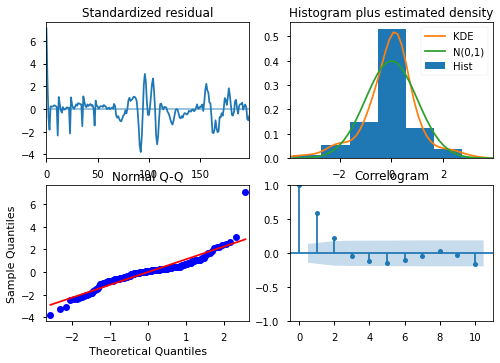

In [95]:
model = pmd.auto_arima(train, 
                       start_p=0, max_p=10,
                       start_P=0, max_P=10,
                       start_q=0, max_q=10,
                       start_Q=0, max_Q=10,
                       d=1, D=1,
                       m=12, 
                       trace=True)
display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              56554   No. Observations:                  212
Model:             SARIMAX(4, 1, 0)x(4, 1, 0, 12)   Log Likelihood               -1723.213
Date:                            Tue, 29 Jun 2021   AIC                           3464.425
Time:                                    23:56:50   BIC                           3494.065
Sample:                                04-01-1996   HQIC                          3476.421
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3056      0.007     41.697      0.000       0.291       0.320
ar.L2          0.1069      0.020      5.439      0.000       0.068       0.145
ar.L3         -0.0343      0.040     -0.863      0.388      -0.112       0.044
ar.L4         -0.0950      0.023     -4.075      0.000      -0.141      -0.049
ar.S.L12      -0.2370      0.026     -9.243      0.000      -0.287      -0.187
ar.S.L24      -0.1872      0.030     -6.297      0.000      -0.245      -0.129
ar.S.L36      -0.1345      0.033     -4.088      0.000      -0.199      -0.070
ar.S.L48      -0.0775      0.028     -2.752      0.006      -0.133      -0.022
sigma2       1.49e+06   1.16e+05     12.864      0.000    1.26e+06    1.72e+06
===================================================================================
Ljung-Box (L1) (Q):                  70.23   Jarque-Bera (JB):               597.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             0.87
Prob(H) (two-sided):                  0.09   Kurtosis:                        11.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

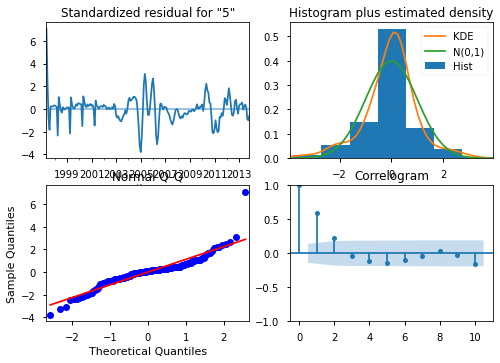

In [96]:
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [97]:
retrieve_forecast(sarimax_model, steps=len(test))

Lower CI    Upper CI    Forecast
2013-12-01 185882.7015 190666.8468 188274.7741
2014-01-01 184153.3247 192021.2876 188087.3061
2014-02-01 183427.9902 194096.1284 188762.0593
2014-03-01 183637.3761 196672.0207 190154.6984
2014-04-01 184178.8171 199057.5602 191618.1887
2014-05-01 183930.3765 200346.8566 192138.6165
2014-06-01 183427.4343 201169.9193 192298.6768
2014-07-01 182914.4141 201853.5184 192383.9662
2014-08-01 182461.0349 202520.1975 192490.6162
2014-09-01 181557.5663 202681.6999 192119.6331
2014-10-01 180380.7479 202526.3677 191453.5578
2014-11-01 178886.5684 202014.2914 190450.4299
2014-12-01 176949.4801 202278.5057 189613.9929
2015-01-01 175498.6607 203294.0505 189396.3556
2015-02-01 174717.4955 205062.9921 189890.2438
2015-03-01 174668.4569 207446.5328 191057.4949
2015-04-01 174910.0232 209867.3370 192388.6801
2015-05-01 174540.5983 211489.6231 193015.1107
2015-06-01 173953.9645 212744.2273 193349.0959
2015-07-01 173352.6318 213877.3909 193615.0114
2015-08-01 172762.3626 214947.0001 193854.6814
2015-09-01 171772.4935 215556.9300 193664.7118
2015-10-01 170450.2019 215783.1043 193116.6531
2015-11-01 168694.8820 215528.8782 192111.8801
2015-12-01 166609.2581 215724.0397 191166.6489
2016-01-01 164984.4367 216553.4606 190768.9486
2016-02-01 164043.7656 218134.8022 191089.2839
2016-03-01 163776.3833 220328.7729 192052.5781
2016-04-01 163741.7796 222596.9457 193169.3627
2016-05-01 163129.3126 224160.3863 193644.8495
2016-06-01 162354.2583 225452.8881 193903.5732
2016-07-01 161567.4461 226651.7306 194109.5884
2016-08-01 160824.8759 227833.6110 194329.2435
2016-09-01 159737.4720 228618.9181 194178.1951
2016-10-01 158361.0773 229069.3279 193715.2026
2016-11-01 156583.3115 229075.1074 192829.2094
2016-12-01 154527.8135 229399.7733 191963.7934
2017-01-01 152907.4936 230294.2545 191600.8741
2017-02-01 152002.7827 231961.2949 191982.0388
2017-03-01 151795.6384 234285.3644 193040.5014
2017-04-01 151766.9746 236669.3615 194218.1681
2017-05-01 151090.6078 238307.5772 194699.0925
2017-06-01 150181.3745 239626.6460 194904.0103
2017-07-01 149221.4677 240827.8752 195024.6715
2017-08-01 148320.9167 242036.7130 195178.8149
2017-09-01 147148.9554 242929.3161 195039.1357
2017-10-01 145739.8072 243544.1462 194641.9767
2017-11-01 143923.1848 243712.7134 193817.9491
2017-12-01 141833.4499 244132.0617 192982.7558
2018-01-01 140199.4226 245128.3556 192663.8891
2018-02-01 139290.2614 246904.0561 193097.1587
2018-03-01 139083.6025 249351.6622 194217.6324
2018-04-01 139046.1992 251868.0651 195457.1321

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

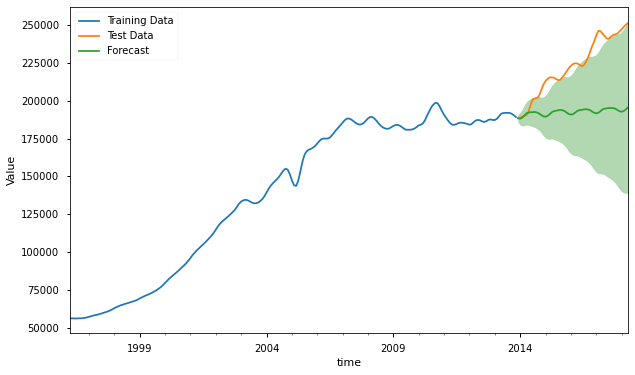

In [98]:
plot_train_test_forecast(train, test, forecast_df['Forecast'], forecast_df, forecast_df['Lower CI'], forecast_df['Upper CI'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              56554   No. Observations:                  265
Model:             SARIMAX(4, 1, 0)x(4, 1, 0, 12)   Log Likelihood               -2187.989
Date:                            Tue, 29 Jun 2021   AIC                           4393.978
Time:                                    23:56:57   BIC                           4425.743
Sample:                                04-01-1996   HQIC                          4406.760
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3574      0.008     47.227      0.000       0.343       0.372
ar.L2          0.0850      0.024      3.484      0.000       0.037       0.133
ar.L3         -0.0388      0.042     -0.925      0.355      -0.121       0.043
ar.L4         -0.0686      0.030     -2.254      0.024      -0.128      -0.009
ar.S.L12      -0.2758      0.023    -12.201      0.000      -0.320      -0.232
ar.S.L24      -0.2056      0.027     -7.523      0.000      -0.259      -0.152
ar.S.L36      -0.1498      0.029     -5.173      0.000      -0.207      -0.093
ar.S.L48      -0.0776      0.028     -2.802      0.005      -0.132      -0.023
sigma2        1.6e+06    1.1e+05     14.535      0.000    1.38e+06    1.82e+06
===================================================================================
Ljung-Box (L1) (Q):                  69.21   Jarque-Bera (JB):              1250.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             1.25
Prob(H) (two-sided):                  0.31   Kurtosis:                        13.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

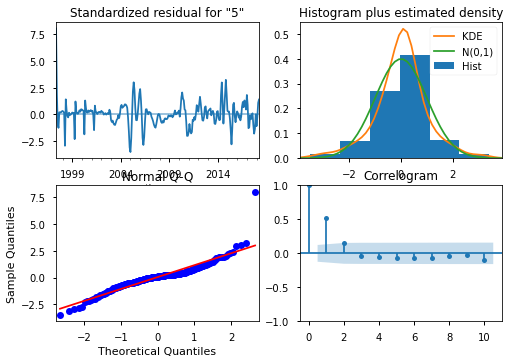

In [99]:
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [100]:
retrieve_forecast(sarimax_model_full, steps=36)

Lower CI    Upper CI    Forecast
2018-05-01 248844.8698 253803.8593 251324.3645
2018-06-01 246716.7474 255077.6830 250897.2152
2018-07-01 245474.3351 256899.7258 251187.0305
2018-08-01 245362.2713 259380.6398 252371.4556
2018-09-01 245184.0335 261286.6725 253235.3530
2018-10-01 244912.9282 262769.7815 253841.3549
2018-11-01 245033.6559 264418.1637 254725.9098
2018-12-01 245890.8544 266656.6719 256273.7631
2019-01-01 246831.0707 268882.6185 257856.8446
2019-02-01 247866.7506 271134.0208 259500.3857
2019-03-01 248368.1497 272795.0989 260581.6243
2019-04-01 248599.7512 274137.5640 261368.6576
2019-05-01 247569.4340 275394.9371 261482.1856
2019-06-01 246076.7432 276514.0020 261295.3726
2019-07-01 245165.0231 278301.6962 261733.3596
2019-08-01 245014.7035 280736.6531 262875.6783
2019-09-01 244825.2986 282907.1211 263866.2099
2019-10-01 244671.5935 284926.7577 264799.1756
2019-11-01 244997.8597 287275.7613 266136.8105
2019-12-01 245866.0504 290054.0496 267960.0500
2020-01-01 246720.9176 292734.2598 269727.5887
2020-02-01 247507.8426 295277.4162 271392.6294
2020-03-01 247636.3621 297102.5808 272369.4714
2020-04-01 247367.1243 298476.0730 272921.5986
2020-05-01 246106.6396 299604.4648 272855.5522
2020-06-01 244414.1066 300507.0602 272460.5834
2020-07-01 243388.5889 302145.5946 272767.0917
2020-08-01 243247.6618 304610.1389 273928.9003
2020-09-01 243174.6462 307003.5038 275089.0750
2020-10-01 243158.2253 309329.2586 276243.7420
2020-11-01 243551.0783 311957.5643 277754.3213
2020-12-01 244369.7159 314926.9286 279648.3223
2021-01-01 245217.6811 317858.0946 281537.8878
2021-02-01 245922.9814 320588.9100 283255.9457
2021-03-01 245816.1919 322456.0668 284136.1293
2021-04-01 245244.6239 323810.5743 284527.5991
2021-05-01 243793.5387 324854.9404 284324.2396
2021-06-01 241950.8647 325666.3860 283808.6254
2021-07-01 240887.7109 327314.9377 284101.3243
2021-08-01 240802.5317 329902.4820 285352.5069
2021-09-01 240765.2080 332434.6735 286599.9408
2021-10-01 240787.4007 334931.0541 287859.2274
2021-11-01 241176.1902 337709.7051 289442.9476
2021-12-01 241943.3106 340797.8582 291370.5844
2022-01-01 242811.0650 343930.2832 293370.6741
2022-02-01 243511.7396 346846.3400 295179.0398
2022-03-01 243271.1936 348776.2406 296023.7171
2022-04-01 242528.0554 350161.1781 296344.6168
2022-05-01 240953.8153 351229.4155 296091.6154
2022-06-01 238984.6251 352049.9420 295517.2836
2022-07-01 237831.9492 353744.7939 295788.3715
2022-08-01 237676.0156 356407.3756 297041.6956
2022-09-01 237490.9954 358952.5343 298221.7649

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

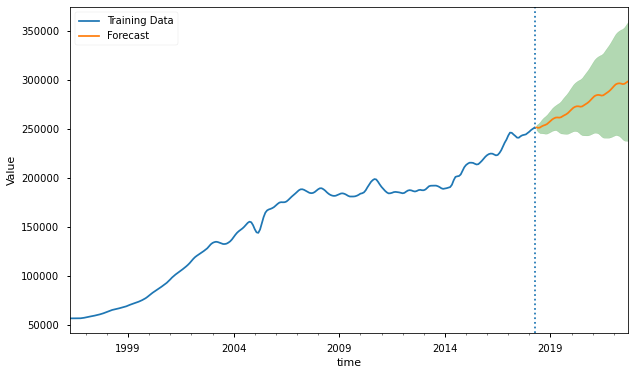

In [101]:
plot_time_series_forecast(ts, forecast_df['Forecast'], forecast_df, forecast_df['Lower CI'], forecast_df['Upper CI'])

Lower CI  Upper CI  Forecast
2018-05-01   -0.0099    0.0099    0.0000
2018-06-01   -0.0183    0.0149   -0.0017
2018-07-01   -0.0233    0.0222   -0.0005
2018-08-01   -0.0237    0.0321    0.0042
2018-09-01   -0.0244    0.0396    0.0076
2018-10-01   -0.0255    0.0455    0.0100
2018-11-01   -0.0250    0.0521    0.0135
2018-12-01   -0.0216    0.0610    0.0197
2019-01-01   -0.0179    0.0699    0.0260
2019-02-01   -0.0138    0.0788    0.0325
2019-03-01   -0.0118    0.0854    0.0368
2019-04-01   -0.0108    0.0908    0.0400
2019-05-01   -0.0149    0.0958    0.0404
2019-06-01   -0.0209    0.1002    0.0397
2019-07-01   -0.0245    0.1073    0.0414
2019-08-01   -0.0251    0.1170    0.0460
2019-09-01   -0.0259    0.1257    0.0499
2019-10-01   -0.0265    0.1337    0.0536
2019-11-01   -0.0252    0.1430    0.0589
2019-12-01   -0.0217    0.1541    0.0662
2020-01-01   -0.0183    0.1648    0.0732
2020-02-01   -0.0152    0.1749    0.0799
2020-03-01   -0.0147    0.1821    0.0837
2020-04-01   -0.0157    0.1876    0.0859
2020-05-01   -0.0208    0.1921    0.0857
2020-06-01   -0.0275    0.1957    0.0841
2020-07-01   -0.0316    0.2022    0.0853
2020-08-01   -0.0321    0.2120    0.0899
2020-09-01   -0.0324    0.2215    0.0946
2020-10-01   -0.0325    0.2308    0.0992
2020-11-01   -0.0309    0.2413    0.1052
2020-12-01   -0.0277    0.2531    0.1127
2021-01-01   -0.0243    0.2647    0.1202
2021-02-01   -0.0215    0.2756    0.1271
2021-03-01   -0.0219    0.2830    0.1306
2021-04-01   -0.0242    0.2884    0.1321
2021-05-01   -0.0300    0.2926    0.1313
2021-06-01   -0.0373    0.2958    0.1293
2021-07-01   -0.0415    0.3024    0.1304
2021-08-01   -0.0419    0.3127    0.1354
2021-09-01   -0.0420    0.3227    0.1404
2021-10-01   -0.0419    0.3327    0.1454
2021-11-01   -0.0404    0.3437    0.1517
2021-12-01   -0.0373    0.3560    0.1593
2022-01-01   -0.0339    0.3685    0.1673
2022-02-01   -0.0311    0.3801    0.1745
2022-03-01   -0.0320    0.3878    0.1779
2022-04-01   -0.0350    0.3933    0.1791
2022-05-01   -0.0413    0.3975    0.1781
2022-06-01   -0.0491    0.4008    0.1758
2022-07-01   -0.0537    0.4075    0.1769
2022-08-01   -0.0543    0.4181    0.1819
2022-09-01   -0.0550    0.4282    0.1866

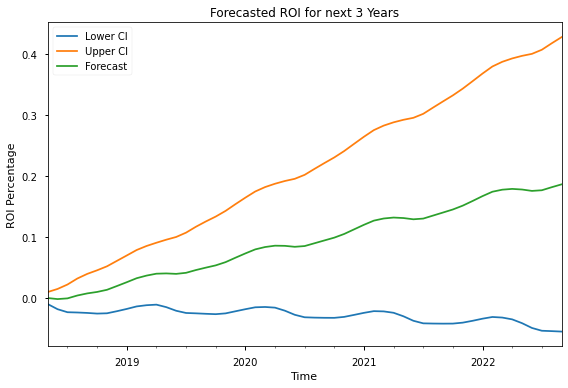

In [102]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 56554 has a predicted ROI of 18.6% after three years. However, the confidence interval ranges from -5.5% to 42.8%

## Zipcode 56511

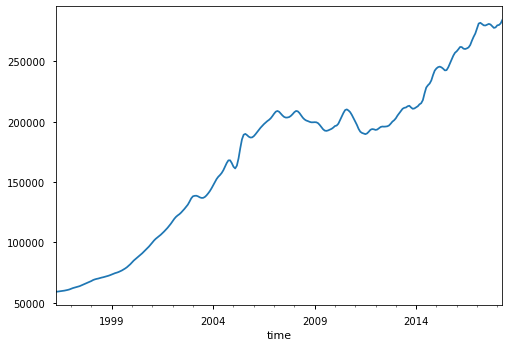

In [103]:
ts = all_time_series_df['56511']
ts.plot();

In [104]:
#Create train test split cutoff
tts_cutoff = round(len(ts)*0.80)
display(tts_cutoff)
    
## Use the tts cutoff to do Train test split and plot
train = ts.iloc[:tts_cutoff]
test = ts.iloc[tts_cutoff:]

212

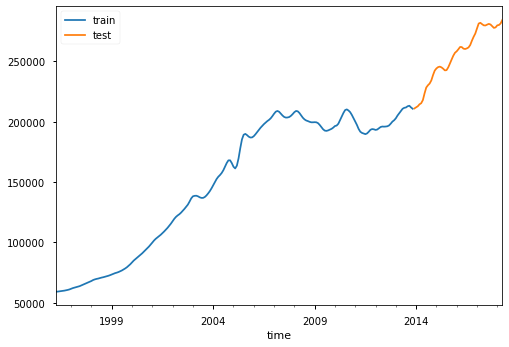

In [105]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.5757          10  ...  False        False

[1 rows x 6 columns]

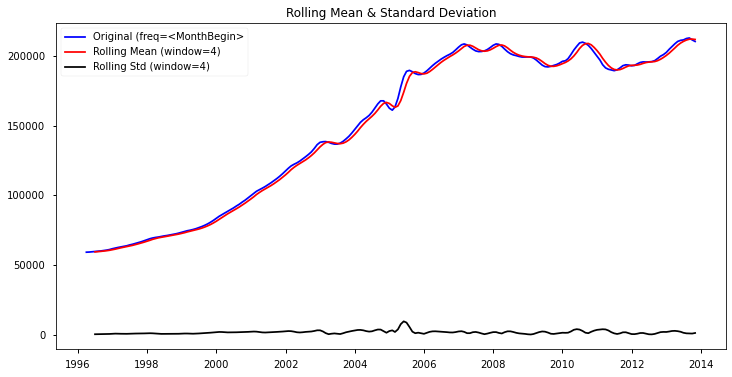

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.5757          10  ...  False        False

[1 rows x 6 columns]

In [106]:
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -3.5084           9  ...   True         True

[1 rows x 6 columns]

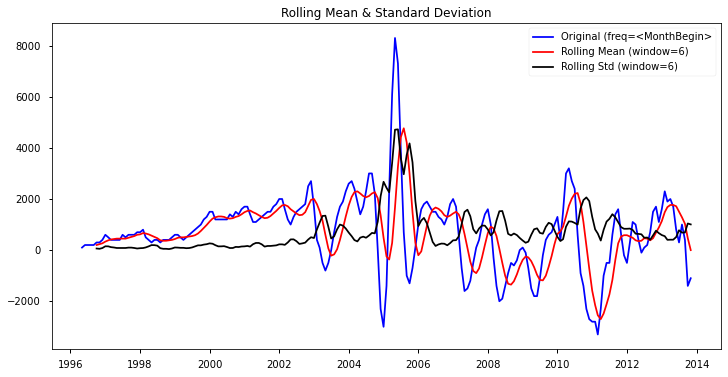

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -3.5084           9  ...   True         True

[1 rows x 6 columns]

In [107]:
stationarity_check(train.diff().dropna(), window=6)

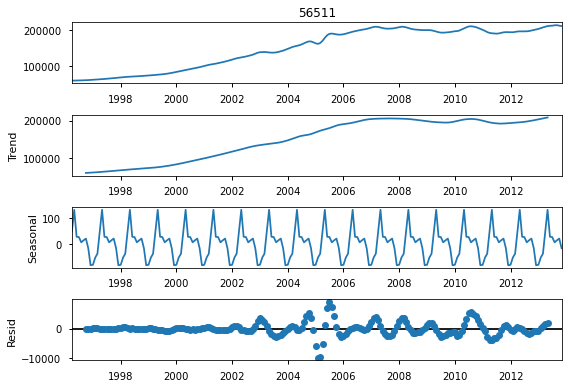

In [108]:
decompose = tsa.seasonal_decompose(train)
decompose.plot();

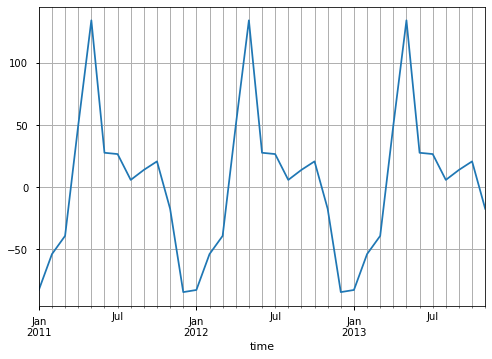

In [109]:
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3684.389, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3654.398, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3658.970, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3726.783, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3652.081, Time=0.08 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3649.738, Time=0.31 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3651.575, Time=0.48 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3655.870, Time=0.41 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3676.077, Time=0.92 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3686.130, Time=0.04 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=3650.539, Time=0.24 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3651.009, Time=0.34 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=3650.879, Time=0.43 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=3677.067, Time=0.13 sec

Best model:  ARIMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  212
Model:             SARIMAX(1, 1, 0)x(0, 0, [1], 12)   Log Likelihood               -1820.869
Date:                              Tue, 29 Jun 2021   AIC                           3649.738
Time:                                      23:57:03   BIC                           3663.146
Sample:                                           0   HQIC                          3655.158
                                              - 212                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    521.1510     98.932      5.268      0.000     327.248     715.054
ar.L1          0.2115      0.006     34.831      0.000       0.200       0.223
ma.S.L12       0.0133      0.053      0.249      0.803      -0.091       0.118
sigma2      1.587e+06   8.56e+04     18.546      0.000    1.42e+06    1.75e+06
===================================================================================
Ljung-Box (L1) (Q):                 105.55   Jarque-Bera (JB):               750.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                            -0.41
Prob(H) (two-sided):                  0.12   Kurtosis:                        12.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

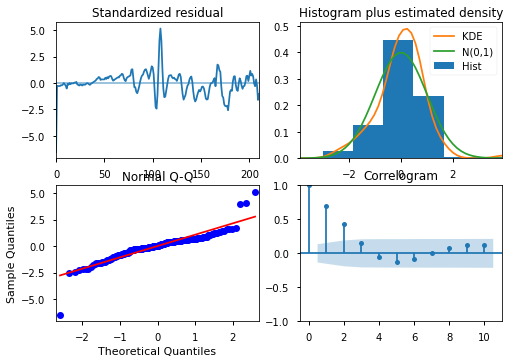

In [110]:
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3597.717, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3532.169, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3545.866, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3538.515, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3526.928, Time=0.62 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=3523.381, Time=1.49 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=3521.308, Time=2.42 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=3523.097, Time=5.34 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=4.37 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=3.05 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=8.14 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=3571.968, Time=0.59 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=3518.801, Time=2.12 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=3521.029, Time=1.45 sec
 ARIMA(2,1,0)(5,1,0)[12]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  212
Model:             SARIMAX(3, 1, 1)x(4, 1, [], 12)   Log Likelihood               -1749.071
Date:                             Wed, 30 Jun 2021   AIC                           3516.142
Time:                                     00:00:12   BIC                           3545.781
Sample:                                          0   HQIC                          3528.138
                                             - 212                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0304      0.186      5.538      0.000       0.666       1.395
ar.L2         -0.1057      0.061     -1.721      0.085      -0.226       0.015
ar.L3         -0.1296      0.026     -5.072      0.000      -0.180      -0.080
ma.L1         -0.7410      0.193     -3.836      0.000      -1.120      -0.362
ar.S.L12      -0.2217      0.027     -8.202      0.000      -0.275      -0.169
ar.S.L24      -0.1930      0.028     -6.913      0.000      -0.248      -0.138
ar.S.L36      -0.1350      0.030     -4.518      0.000      -0.194      -0.076
ar.S.L48      -0.0733      0.023     -3.132      0.002      -0.119      -0.027
sigma2      2.058e+06   3.09e-08   6.67e+13      0.000    2.06e+06    2.06e+06
===================================================================================
Ljung-Box (L1) (Q):                  73.01   Jarque-Bera (JB):               418.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             1.06
Prob(H) (two-sided):                  0.75   Kurtosis:                         9.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.93e+29. Standard errors may be unstable.
"""

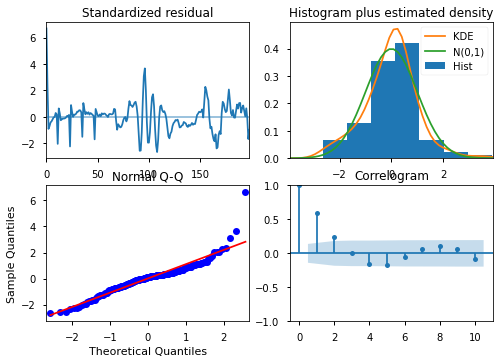

In [111]:
model = pmd.auto_arima(train, 
                       start_p=0, max_p=10,
                       start_P=0, max_P=10,
                       start_q=0, max_q=10,
                       start_Q=0, max_Q=10,
                       d=1, D=1,
                       m=12, 
                       trace=True)
display(model.summary())
model.plot_diagnostics();

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               56511   No. Observations:                  212
Model:             SARIMAX(3, 1, 1)x(4, 1, [], 12)   Log Likelihood               -1749.071
Date:                             Wed, 30 Jun 2021   AIC                           3516.142
Time:                                     00:00:18   BIC                           3545.781
Sample:                                 04-01-1996   HQIC                          3528.138
                                      - 11-01-2013                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0304      0.186      5.538      0.000       0.666       1.395
ar.L2         -0.1057      0.061     -1.721      0.085      -0.226       0.015
ar.L3         -0.1296      0.026     -5.072      0.000      -0.180      -0.080
ma.L1         -0.7410      0.193     -3.836      0.000      -1.120      -0.362
ar.S.L12      -0.2217      0.027     -8.202      0.000      -0.275      -0.169
ar.S.L24      -0.1930      0.028     -6.913      0.000      -0.248      -0.138
ar.S.L36      -0.1350      0.030     -4.518      0.000      -0.194      -0.076
ar.S.L48      -0.0733      0.023     -3.132      0.002      -0.119      -0.027
sigma2      2.058e+06   3.09e-08   6.67e+13      0.000    2.06e+06    2.06e+06
===================================================================================
Ljung-Box (L1) (Q):                  73.01   Jarque-Bera (JB):               418.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             1.06
Prob(H) (two-sided):                  0.75   Kurtosis:                         9.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.93e+29. Standard errors may be unstable.
"""

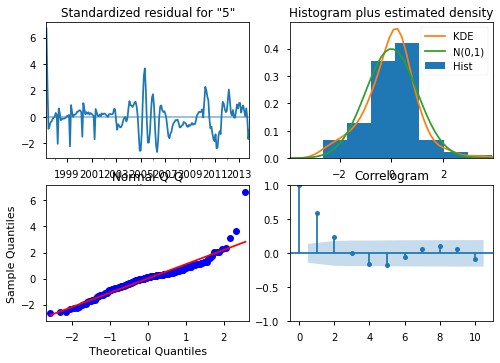

In [112]:
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [113]:
retrieve_forecast(sarimax_model, steps=len(test))

Lower CI    Upper CI    Forecast
2013-12-01 207567.7917 213191.8409 210379.8163
2014-01-01 206411.5918 215588.6523 211000.1220
2014-02-01 206317.7948 218714.7679 212516.2814
2014-03-01 206401.4197 221460.5004 213930.9601
2014-04-01 206965.4675 224230.8894 215598.1785
2014-05-01 207545.3379 226648.1556 217096.7468
2014-06-01 207529.6004 228193.4709 217861.5356
2014-07-01 207233.8379 229256.7014 218245.2697
2014-08-01 207545.2184 230782.0326 219163.6255
2014-09-01 207426.4831 231773.4388 219599.9609
2014-10-01 205941.9761 231324.1459 218633.0610
2014-11-01 204603.7447 230965.8381 217784.7914
2014-12-01 203093.2334 231842.7052 217467.9693
2015-01-01 202170.4400 233610.9862 217890.7131
2015-02-01 201886.9293 236130.5471 219008.7382
2015-03-01 201682.9098 238580.2117 220131.5607
2015-04-01 201946.6036 241292.7666 221619.6851
2015-05-01 202236.2949 243820.6937 223028.4943
2015-06-01 201986.5679 245625.7677 223806.1678
2015-07-01 201491.2852 247034.8555 224263.0704
2015-08-01 201434.1338 248762.7107 225098.4223
2015-09-01 201000.3360 250019.9913 225510.1636
2015-10-01 199482.2248 250118.5105 224800.3676
2015-11-01 197979.2317 250171.9472 224075.5895
2015-12-01 196349.2059 250997.6664 223673.4361
2016-01-01 195228.0333 252526.1419 223877.0876
2016-02-01 194721.7344 254753.4358 224737.5851
2016-03-01 194245.4169 256931.4519 225588.4344
2016-04-01 194196.0808 259411.3945 226803.7376
2016-05-01 194190.4181 261796.1420 227993.2801
2016-06-01 193690.2420 263557.9771 228624.1095
2016-07-01 192968.2761 264987.0806 228977.6783
2016-08-01 192729.7984 266807.2277 229768.5130
2016-09-01 192240.5906 268300.3801 230270.4853
2016-10-01 190829.4681 268808.3299 229818.8990
2016-11-01 189393.2877 269237.7722 229315.5300
2016-12-01 187827.0151 270229.1903 229028.1027
2017-01-01 186741.6819 271851.9852 229296.8335
2017-02-01 186306.6554 274194.4006 230250.5280
2017-03-01 185919.6253 276530.1715 231224.8984
2017-04-01 185886.6354 279127.1739 232506.9046
2017-05-01 185812.5376 281576.1090 233694.3233
2017-06-01 185201.6205 283386.4472 234294.0339
2017-07-01 184372.5090 284888.3655 234630.4373
2017-08-01 184014.6388 286784.4887 235399.5637
2017-09-01 183423.9686 288382.7354 235903.3520
2017-10-01 181952.7132 289045.1346 235498.9239
2017-11-01 180504.6273 289682.9984 235093.8128
2017-12-01 178960.7244 290841.3176 234901.0210
2018-01-01 177936.0336 292656.0766 235296.0551
2018-02-01 177576.9366 295202.9832 236389.9599
2018-03-01 177219.8960 297708.8736 237464.3848
2018-04-01 177196.0734 300469.5442 238832.8088

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

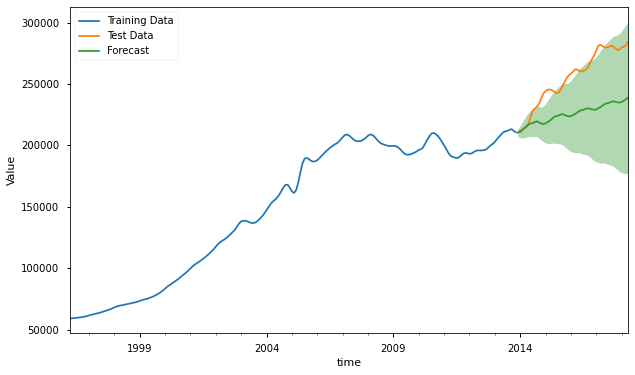

In [114]:
plot_train_test_forecast(train, test, forecast_df['Forecast'], forecast_df, forecast_df['Lower CI'], forecast_df['Upper CI'])

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               56511   No. Observations:                  265
Model:             SARIMAX(3, 1, 1)x(4, 1, [], 12)   Log Likelihood               -2224.461
Date:                             Wed, 30 Jun 2021   AIC                           4466.921
Time:                                     00:00:27   BIC                           4498.686
Sample:                                 04-01-1996   HQIC                          4479.703
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0945      0.167      6.568      0.000       0.768       1.421
ar.L2         -0.1681      0.067     -2.516      0.012      -0.299      -0.037
ar.L3         -0.1125      0.028     -4.090      0.000      -0.166      -0.059
ma.L1         -0.7599      0.174     -4.355      0.000      -1.102      -0.418
ar.S.L12      -0.2729      0.024    -11.197      0.000      -0.321      -0.225
ar.S.L24      -0.2176      0.026     -8.379      0.000      -0.268      -0.167
ar.S.L36      -0.1581      0.026     -5.989      0.000      -0.210      -0.106
ar.S.L48      -0.0608      0.028     -2.170      0.030      -0.116      -0.006
sigma2      2.262e+06   3.48e-08    6.5e+13      0.000    2.26e+06    2.26e+06
===================================================================================
Ljung-Box (L1) (Q):                  65.17   Jarque-Bera (JB):               763.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             1.20
Prob(H) (two-sided):                  0.95   Kurtosis:                        11.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.88e+29. Standard errors may be unstable.
"""

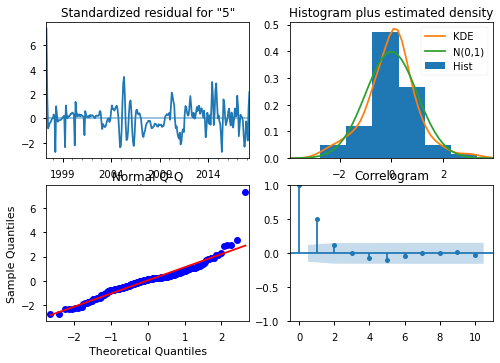

In [115]:
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [116]:
retrieve_forecast(sarimax_model_full, steps=36)

Lower CI    Upper CI    Forecast
2018-05-01 282509.3514 288405.4700 285457.4107
2018-06-01 282138.8233 291971.6958 287055.2595
2018-07-01 282022.2387 295377.1543 288699.6965
2018-08-01 281702.8828 297988.5359 289845.7094
2018-09-01 280662.9620 299373.4921 290018.2271
2018-10-01 279165.9357 299891.5471 289528.7414
2018-11-01 277942.1640 300371.6639 289156.9139
2018-12-01 278073.3624 301977.4719 290025.4171
2019-01-01 279104.8710 304317.8416 291711.3563
2019-02-01 279150.8797 305553.7110 292352.2954
2019-03-01 279777.9700 307284.9010 293531.4355
2019-04-01 281263.1556 309811.4015 295537.2786
2019-05-01 280815.6088 311739.4722 296277.5405
2019-06-01 280777.8553 314441.3418 297609.5985
2019-07-01 280922.8018 317437.8187 299180.3103
2019-08-01 280814.8840 320049.9950 300432.4395
2019-09-01 280169.6672 321922.9675 301046.3174
2019-10-01 279277.5536 323337.9448 301307.7492
2019-11-01 278641.0300 324820.7407 301730.8854
2019-12-01 278933.5251 327076.6869 303005.1060
2020-01-01 279811.2565 329792.9993 304802.1279
2020-02-01 279900.9147 331622.4898 305761.7022
2020-03-01 280244.8610 333627.9562 306936.4086
2020-04-01 280953.1951 335934.7386 308443.9668
2020-05-01 280080.7612 337506.3513 308793.5563
2020-06-01 279682.5180 339778.0168 309730.2674
2020-07-01 279642.3051 342489.1993 311065.7522
2020-08-01 279528.0502 345057.9060 312292.9781
2020-09-01 279062.8732 347153.8916 313108.3824
2020-10-01 278481.6536 348996.6771 313739.1653
2020-11-01 278044.1410 350853.9280 314449.0345
2020-12-01 278360.1823 353351.8912 315856.0368
2021-01-01 279299.2002 356378.0587 317838.6294
2021-02-01 279548.1907 358635.7420 319091.9664
2021-03-01 279746.9753 360778.1435 320262.5594
2021-04-01 280068.9194 362988.9755 321528.9475
2021-05-01 278988.3027 364444.7078 321716.5052
2021-06-01 278455.3784 366621.1822 322538.2803
2021-07-01 278321.5440 369263.4242 323792.4841
2021-08-01 278093.5171 371764.9685 324929.2428
2021-09-01 277483.7576 373794.9461 325639.3518
2021-10-01 276743.1089 375589.1442 326166.1266
2021-11-01 276102.3844 377381.6381 326742.0113
2021-12-01 276279.5713 379901.0797 328090.3255
2022-01-01 277209.6310 383095.1782 330152.4046
2022-02-01 277391.8205 385475.1541 331433.4873
2022-03-01 277470.2408 387695.1590 332582.6999
2022-04-01 277762.2923 390080.4948 333921.3936
2022-05-01 276658.0061 391687.7939 334172.9000
2022-06-01 276094.6947 394006.9258 335050.8102
2022-07-01 275899.6677 396765.5004 336332.5840
2022-08-01 275557.9711 399340.9367 337449.4539
2022-09-01 274723.3260 401344.1689 338033.7474

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

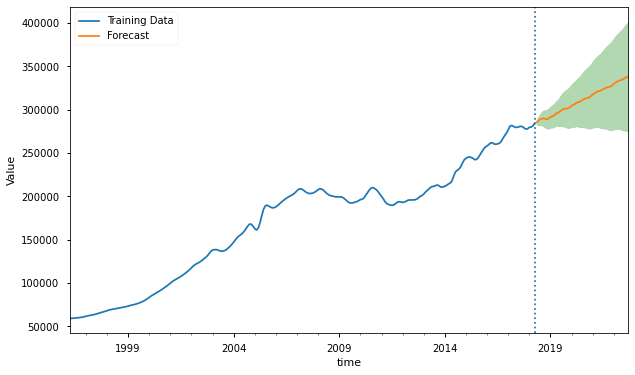

In [117]:
plot_time_series_forecast(ts, forecast_df['Forecast'], forecast_df, forecast_df['Lower CI'], forecast_df['Upper CI'])

Lower CI  Upper CI  Forecast
2018-05-01   -0.0103    0.0103    0.0000
2018-06-01   -0.0116    0.0228    0.0056
2018-07-01   -0.0120    0.0348    0.0114
2018-08-01   -0.0132    0.0439    0.0154
2018-09-01   -0.0168    0.0488    0.0160
2018-10-01   -0.0220    0.0506    0.0143
2018-11-01   -0.0263    0.0522    0.0130
2018-12-01   -0.0259    0.0579    0.0160
2019-01-01   -0.0223    0.0661    0.0219
2019-02-01   -0.0221    0.0704    0.0242
2019-03-01   -0.0199    0.0765    0.0283
2019-04-01   -0.0147    0.0853    0.0353
2019-05-01   -0.0163    0.0921    0.0379
2019-06-01   -0.0164    0.1015    0.0426
2019-07-01   -0.0159    0.1120    0.0481
2019-08-01   -0.0163    0.1212    0.0525
2019-09-01   -0.0185    0.1277    0.0546
2019-10-01   -0.0216    0.1327    0.0555
2019-11-01   -0.0239    0.1379    0.0570
2019-12-01   -0.0229    0.1458    0.0615
2020-01-01   -0.0198    0.1553    0.0678
2020-02-01   -0.0195    0.1617    0.0711
2020-03-01   -0.0183    0.1687    0.0752
2020-04-01   -0.0158    0.1768    0.0805
2020-05-01   -0.0188    0.1823    0.0818
2020-06-01   -0.0202    0.1903    0.0850
2020-07-01   -0.0204    0.1998    0.0897
2020-08-01   -0.0208    0.2088    0.0940
2020-09-01   -0.0224    0.2161    0.0969
2020-10-01   -0.0244    0.2226    0.0991
2020-11-01   -0.0260    0.2291    0.1016
2020-12-01   -0.0249    0.2378    0.1065
2021-01-01   -0.0216    0.2484    0.1134
2021-02-01   -0.0207    0.2564    0.1178
2021-03-01   -0.0200    0.2639    0.1219
2021-04-01   -0.0189    0.2716    0.1264
2021-05-01   -0.0227    0.2767    0.1270
2021-06-01   -0.0245    0.2843    0.1299
2021-07-01   -0.0250    0.2936    0.1343
2021-08-01   -0.0258    0.3023    0.1383
2021-09-01   -0.0279    0.3095    0.1408
2021-10-01   -0.0305    0.3157    0.1426
2021-11-01   -0.0328    0.3220    0.1446
2021-12-01   -0.0322    0.3309    0.1493
2022-01-01   -0.0289    0.3420    0.1566
2022-02-01   -0.0283    0.3504    0.1611
2022-03-01   -0.0280    0.3582    0.1651
2022-04-01   -0.0270    0.3665    0.1698
2022-05-01   -0.0308    0.3721    0.1707
2022-06-01   -0.0328    0.3803    0.1737
2022-07-01   -0.0335    0.3899    0.1782
2022-08-01   -0.0347    0.3990    0.1821
2022-09-01   -0.0376    0.4060    0.1842

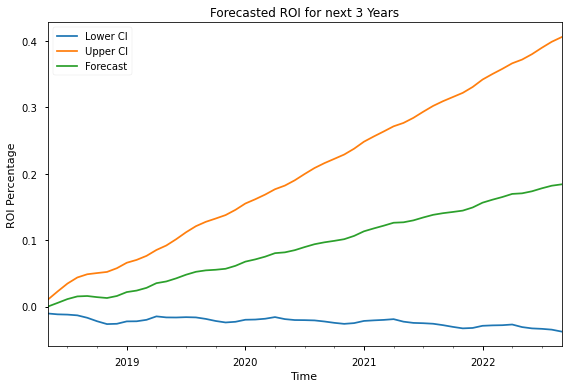

In [118]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 56511 has a predicted ROI of 18.4% after three years. However, the confidence interval ranges from -3.7% to 40.6%

## Zipcode 56443

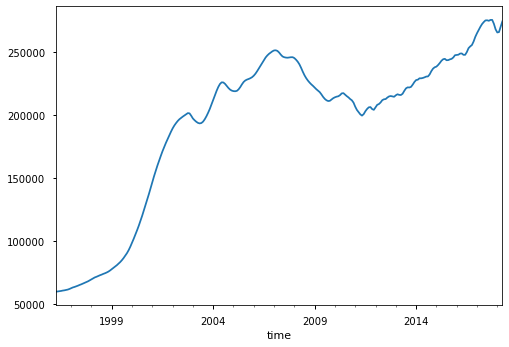

In [119]:
ts = all_time_series_df['56443']
ts.plot();

In [120]:
#Create train test split cutoff
tts_cutoff = round(len(ts)*0.80)
display(tts_cutoff)
    
## Use the tts cutoff to do Train test split and plot
train = ts.iloc[:tts_cutoff]
test = ts.iloc[tts_cutoff:]

212

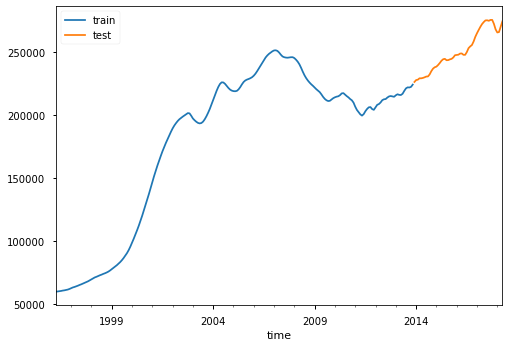

In [121]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.9262           6  ...  False        False

[1 rows x 6 columns]

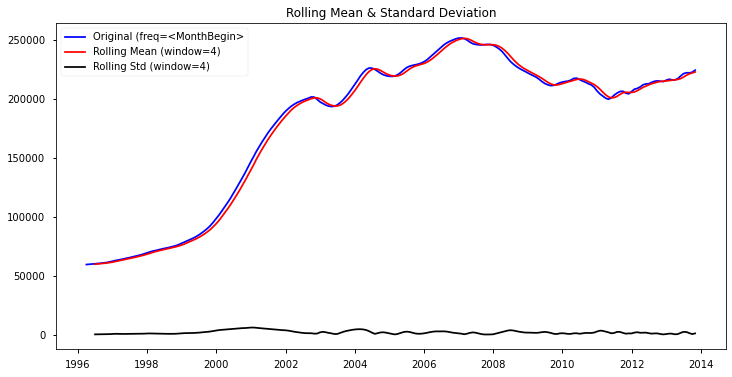

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.9262           6  ...  False        False

[1 rows x 6 columns]

In [122]:
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -3.1535           5  ...   True         True

[1 rows x 6 columns]

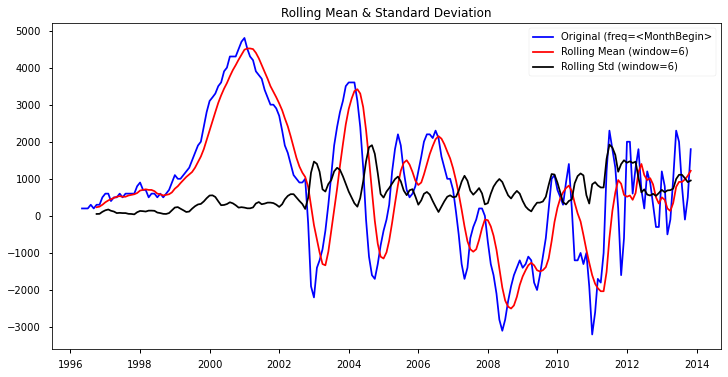

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -3.1535           5  ...   True         True

[1 rows x 6 columns]

In [123]:
stationarity_check(train.diff().dropna(), window=6)

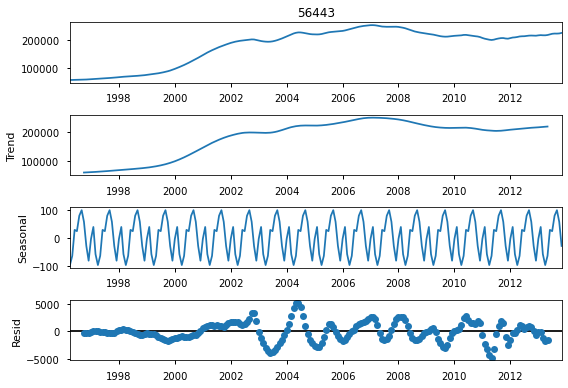

In [124]:
decompose = tsa.seasonal_decompose(train)
decompose.plot();

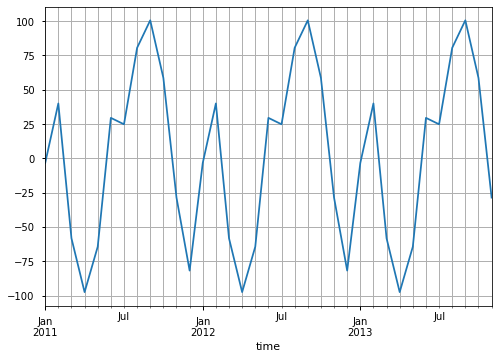

In [125]:
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3274.768, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3264.605, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3261.599, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=3260.721, Time=0.04 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=3261.712, Time=0.11 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=3260.444, Time=0.29 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=3261.729, Time=0.48 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=3261.809, Time=0.58 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=3261.669, Time=0.41 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=3262.196, Time=0.23 sec
 ARIMA(0,2,1)(2,0,2)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=3274.951, Time=0.23 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(0,2,2)(1,0,1)[12]             : AIC=3260.892, Time=0.32 sec
 ARIMA(1,2,0)(1,0,1)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(1, 2, 2)   Log Likelihood               -1625.059
Date:                Wed, 30 Jun 2021   AIC                           3258.119
Time:                        00:00:38   BIC                           3271.507
Sample:                             0   HQIC                          3263.531
                                - 212                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9128      0.041     22.243      0.000       0.832       0.993
ma.L1         -0.7395      0.040    -18.671      0.000      -0.817      -0.662
ma.L2         -0.2275      0.019    -11.848      0.000      -0.265      -0.190
sigma2      2.679e+05   1.81e+04     14.763      0.000    2.32e+05    3.03e+05
===================================================================================
Ljung-Box (L1) (Q):                  17.75   Jarque-Bera (JB):                81.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.61   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

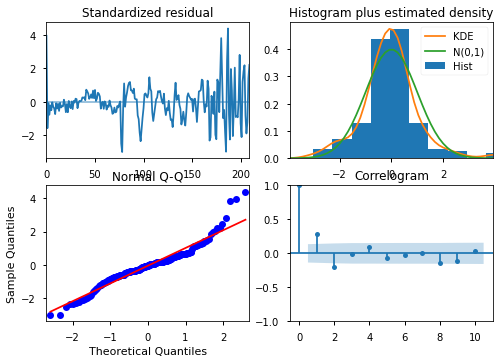

In [126]:
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3615.987, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3526.267, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3557.660, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3534.394, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3524.239, Time=0.54 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=3521.372, Time=1.51 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=3522.111, Time=2.62 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=3.04 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.42 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.46 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=3594.932, Time=0.47 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=3495.473, Time=1.37 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=3497.403, Time=0.74 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=3496.546, Time=3.43 sec
 ARIMA(2,1,0)(3,1,1)[12]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  212
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 12)   Log Likelihood               -1737.545
Date:                            Wed, 30 Jun 2021   AIC                           3489.090
Time:                                    00:01:39   BIC                           3512.144
Sample:                                         0   HQIC                          3498.421
                                            - 212                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3011      0.008     36.966      0.000       0.285       0.317
ar.L2          0.1589      0.012     13.309      0.000       0.136       0.182
ar.L3          0.1109      0.017      6.513      0.000       0.078       0.144
ar.S.L12      -0.1941      0.028     -6.818      0.000      -0.250      -0.138
ar.S.L24      -0.1212      0.038     -3.207      0.001      -0.195      -0.047
ar.S.L36      -0.0744      0.040     -1.859      0.063      -0.153       0.004
sigma2       1.73e+06   1.58e+05     10.926      0.000    1.42e+06    2.04e+06
===================================================================================
Ljung-Box (L1) (Q):                  81.07   Jarque-Bera (JB):               692.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             1.49
Prob(H) (two-sided):                  0.05   Kurtosis:                        11.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.5e+14. Standard errors may be unstable.
"""

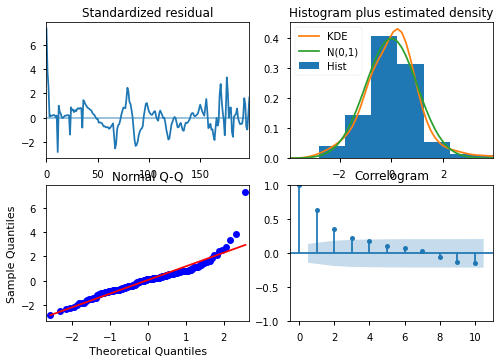

In [127]:
model = pmd.auto_arima(train, 
                       start_p=0, max_p=10,
                       start_P=0, max_P=10,
                       start_q=0, max_q=10,
                       start_Q=0, max_Q=10,
                       d=1, D=1,
                       m=12, 
                       trace=True)
display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              56443   No. Observations:                  212
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 12)   Log Likelihood               -1737.545
Date:                            Wed, 30 Jun 2021   AIC                           3489.090
Time:                                    00:01:41   BIC                           3512.144
Sample:                                04-01-1996   HQIC                          3498.421
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3011      0.008     36.966      0.000       0.285       0.317
ar.L2          0.1589      0.012     13.309      0.000       0.136       0.182
ar.L3          0.1109      0.017      6.513      0.000       0.078       0.144
ar.S.L12      -0.1941      0.028     -6.818      0.000      -0.250      -0.138
ar.S.L24      -0.1212      0.038     -3.207      0.001      -0.195      -0.047
ar.S.L36      -0.0744      0.040     -1.859      0.063      -0.153       0.004
sigma2       1.73e+06   1.58e+05     10.926      0.000    1.42e+06    2.04e+06
===================================================================================
Ljung-Box (L1) (Q):                  81.07   Jarque-Bera (JB):               692.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             1.49
Prob(H) (two-sided):                  0.05   Kurtosis:                        11.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.5e+14. Standard errors may be unstable.
"""

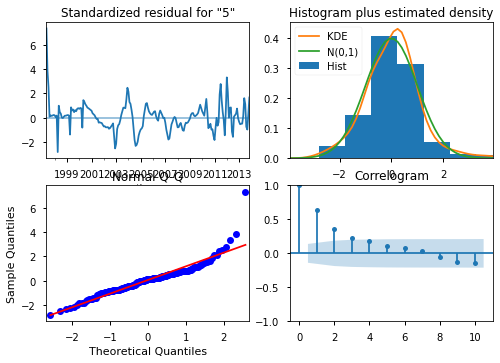

In [128]:
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [129]:
retrieve_forecast(sarimax_model, steps=len(test))

Lower CI    Upper CI    Forecast
2013-12-01 222125.4189 227280.8330 224703.1260
2014-01-01 222038.3668 230498.3854 226268.3761
2014-02-01 221651.0937 233290.7904 227470.9420
2014-03-01 219939.1255 234775.7729 227357.4492
2014-04-01 218656.1756 236514.7037 227585.4396
2014-05-01 218395.1923 239110.1979 228752.6951
2014-06-01 219143.2001 242558.3058 230850.7529
2014-07-01 219604.8658 245566.1483 232585.5070
2014-08-01 219195.2954 247561.4390 233378.3672
2014-09-01 218076.2990 248718.6166 233397.4578
2014-10-01 217368.8237 250170.5557 233769.6897
2014-11-01 217646.5822 252502.4761 235074.5292
2014-12-01 215968.5059 254323.4183 235145.9621
2015-01-01 215325.6896 257402.0461 236363.8679
2015-02-01 214345.4324 260257.2014 237301.3169
2015-03-01 212167.6673 261996.6367 237082.1520
2015-04-01 210348.1642 264033.3115 237190.7379
2015-05-01 209495.5199 266940.4213 238217.9706
2015-06-01 209656.0462 270746.4443 240201.2453
2015-07-01 209622.6087 274232.4792 241927.5440
2015-08-01 208814.7100 276818.0237 242816.3668
2015-09-01 207327.0448 278601.6915 242964.3682
2015-10-01 206115.6089 280545.3731 243330.4910
2015-11-01 205642.8573 283118.6530 244380.7552
2015-12-01 203653.3277 285150.9643 244402.1460
2016-01-01 202862.7467 288543.2679 245703.0073
2016-02-01 201755.0108 291710.2037 246732.6073
2016-03-01 199419.5368 293718.6573 246569.0970
2016-04-01 197460.0596 296070.6806 246765.3701
2016-05-01 196430.1135 299288.0967 247859.1051
2016-06-01 196259.1324 303281.1938 249770.1631
2016-07-01 195851.9779 306940.7956 251396.3868
2016-08-01 194770.3749 309824.1076 252297.2413
2016-09-01 193022.0884 311938.3275 252480.2079
2016-10-01 191509.0611 314187.2202 252848.1407
2016-11-01 190680.1112 317023.1111 253851.6111
2016-12-01 188472.8255 319259.0461 253865.9358
2017-01-01 187484.1456 322847.1161 255165.6308
2017-02-01 186169.7011 326189.3707 256179.5359
2017-03-01 183620.0079 328358.5561 255989.2820
2017-04-01 181439.9889 330877.2340 256158.6114
2017-05-01 180200.0486 334287.8920 257243.9703
2017-06-01 179861.8529 338534.1076 259197.9803
2017-07-01 179276.1262 342452.6426 260864.3844
2017-08-01 177954.4838 345549.1258 261751.8048
2017-09-01 175941.3976 347865.6070 261903.5023
2017-10-01 174198.7792 350363.8803 262281.3297
2017-11-01 173202.1168 353521.0312 263361.5740
2017-12-01 170801.5035 355999.6404 263400.5720
2018-01-01 169611.0318 359821.5271 264716.2794
2018-02-01 168088.2338 363395.3357 265741.7847
2018-03-01 165322.0954 365793.5787 265557.8370
2018-04-01 162917.4092 368543.8921 265730.6507

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

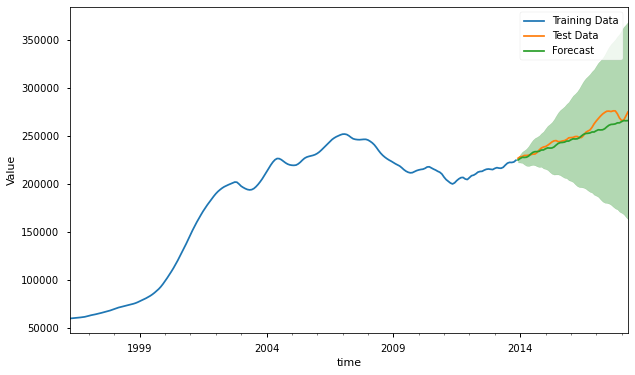

In [130]:
plot_train_test_forecast(train, test, forecast_df['Forecast'], forecast_df, forecast_df['Lower CI'], forecast_df['Upper CI'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              56443   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 12)   Log Likelihood               -2212.004
Date:                            Wed, 30 Jun 2021   AIC                           4438.008
Time:                                    00:01:44   BIC                           4462.714
Sample:                                04-01-1996   HQIC                          4447.949
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3487      0.008     42.908      0.000       0.333       0.365
ar.L2          0.1223      0.016      7.566      0.000       0.091       0.154
ar.L3          0.0801      0.023      3.553      0.000       0.036       0.124
ar.S.L12      -0.2316      0.027     -8.644      0.000      -0.284      -0.179
ar.S.L24      -0.1456      0.035     -4.109      0.000      -0.215      -0.076
ar.S.L36      -0.0666      0.044     -1.512      0.130      -0.153       0.020
sigma2      2.018e+06   1.41e+05     14.298      0.000    1.74e+06     2.3e+06
===================================================================================
Ljung-Box (L1) (Q):                  74.73   Jarque-Bera (JB):              1291.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             1.22
Prob(H) (two-sided):                  0.35   Kurtosis:                        13.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

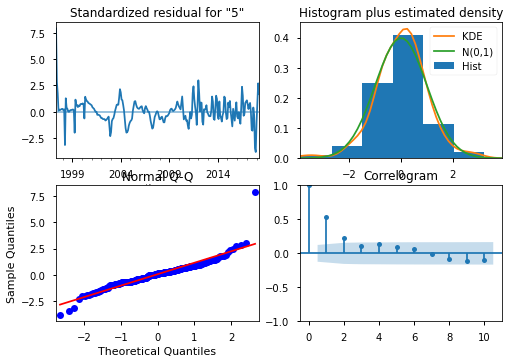

In [131]:
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [132]:
retrieve_forecast(sarimax_model_full, steps=36)

Lower CI    Upper CI    Forecast
2018-05-01 274120.1637 279689.2396 276904.7017
2018-06-01 274079.5409 283429.8833 278754.7121
2018-07-01 273120.4749 286008.1398 279564.3073
2018-08-01 271753.2253 288081.7292 279917.4773
2018-09-01 271222.7149 290773.0378 280997.8764
2018-10-01 270205.2609 292763.6962 281484.4785
2018-11-01 267005.9344 292377.3745 279691.6544
2018-12-01 262930.9106 290935.6209 276933.2658
2019-01-01 260133.8184 290610.9282 275372.3733
2019-02-01 259568.1672 292374.8889 275971.5281
2019-03-01 262116.1999 297125.9822 279621.0911
2019-04-01 264712.3568 301813.1041 283262.7305
2019-05-01 264779.5677 305423.7056 285101.6366
2019-06-01 264415.2741 308914.2820 286664.7780
2019-07-01 263174.7241 311630.8890 287402.8065
2019-08-01 261669.8888 314122.2956 287896.0922
2019-09-01 260755.3365 317125.2663 288940.3014
2019-10-01 259345.7338 319514.3258 289430.0298
2019-11-01 256165.1317 319998.8679 288081.9998
2019-12-01 252317.4547 319677.6115 285997.5331
2020-01-01 249450.8277 320202.0050 284826.4164
2020-02-01 248524.9606 322538.7499 285531.8552
2020-03-01 250376.8771 327533.2766 288955.0768
2020-04-01 252209.7631 332397.6222 292303.6926
2020-05-01 251866.2775 336052.7809 293959.5292
2020-06-01 251221.6854 339623.3372 295422.5113
2020-07-01 249863.0582 342564.4880 296213.7731
2020-08-01 248277.2178 345319.1356 296798.1767
2020-09-01 247172.7430 348511.3523 297842.0476
2020-10-01 245555.2694 351111.7409 298333.5051
2020-11-01 242246.0455 351924.3989 297085.2222
2020-12-01 238297.8973 351992.7228 295145.3101
2021-01-01 235305.0789 352908.8401 294106.9595
2021-02-01 234194.0404 355600.8918 294897.4661
2021-03-01 235786.1022 360893.9022 298340.0022
2021-04-01 237356.7301 366068.1488 301712.4394
2021-05-01 236863.9636 369983.3439 303423.6537
2021-06-01 236057.1426 373772.7832 304914.9629
2021-07-01 234460.3294 376853.7565 305657.0429
2021-08-01 232591.7566 379707.7657 306149.7611
2021-09-01 231267.9449 383079.3285 307173.6367
2021-10-01 229408.1484 385855.4887 307631.8186
2021-11-01 225705.3721 386711.7693 306208.5707
2021-12-01 221288.8075 386766.5281 304027.6678
2022-01-01 217910.7411 387767.7406 302839.2408
2022-02-01 216502.8493 390646.4278 303574.6386
2022-03-01 217912.8779 396251.7958 307082.3369
2022-04-01 219312.9024 401758.6855 310535.7939
2022-05-01 218631.6459 405938.7854 312285.2156
2022-06-01 217627.3425 409979.9852 313803.6639
2022-07-01 215812.1581 413296.1401 314554.1491
2022-08-01 213712.1023 416378.8873 315045.4948
2022-09-01 212159.9945 419992.9280 316076.4613

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

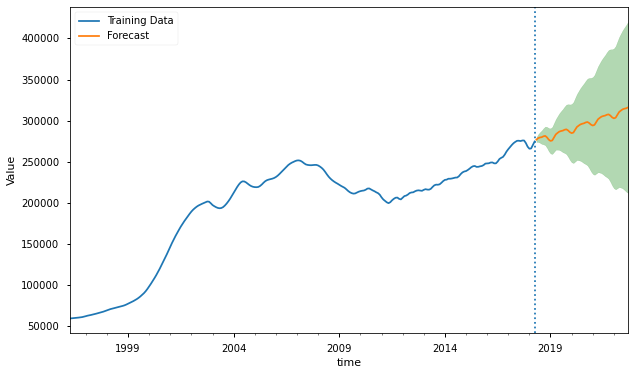

In [133]:
plot_time_series_forecast(ts, forecast_df['Forecast'], forecast_df, forecast_df['Lower CI'], forecast_df['Upper CI'])

Lower CI  Upper CI  Forecast
2018-05-01   -0.0101    0.0101    0.0000
2018-06-01   -0.0102    0.0236    0.0067
2018-07-01   -0.0137    0.0329    0.0096
2018-08-01   -0.0186    0.0404    0.0109
2018-09-01   -0.0205    0.0501    0.0148
2018-10-01   -0.0242    0.0573    0.0165
2018-11-01   -0.0357    0.0559    0.0101
2018-12-01   -0.0505    0.0507    0.0001
2019-01-01   -0.0606    0.0495   -0.0055
2019-02-01   -0.0626    0.0559   -0.0034
2019-03-01   -0.0534    0.0730    0.0098
2019-04-01   -0.0440    0.0900    0.0230
2019-05-01   -0.0438    0.1030    0.0296
2019-06-01   -0.0451    0.1156    0.0352
2019-07-01   -0.0496    0.1254    0.0379
2019-08-01   -0.0550    0.1344    0.0397
2019-09-01   -0.0583    0.1453    0.0435
2019-10-01   -0.0634    0.1539    0.0452
2019-11-01   -0.0749    0.1556    0.0404
2019-12-01   -0.0888    0.1545    0.0328
2020-01-01   -0.0991    0.1564    0.0286
2020-02-01   -0.1025    0.1648    0.0312
2020-03-01   -0.0958    0.1828    0.0435
2020-04-01   -0.0892    0.2004    0.0556
2020-05-01   -0.0904    0.2136    0.0616
2020-06-01   -0.0928    0.2265    0.0669
2020-07-01   -0.0977    0.2371    0.0697
2020-08-01   -0.1034    0.2471    0.0718
2020-09-01   -0.1074    0.2586    0.0756
2020-10-01   -0.1132    0.2680    0.0774
2020-11-01   -0.1252    0.2709    0.0729
2020-12-01   -0.1394    0.2712    0.0659
2021-01-01   -0.1502    0.2745    0.0621
2021-02-01   -0.1542    0.2842    0.0650
2021-03-01   -0.1485    0.3033    0.0774
2021-04-01   -0.1428    0.3220    0.0896
2021-05-01   -0.1446    0.3361    0.0958
2021-06-01   -0.1475    0.3498    0.1012
2021-07-01   -0.1533    0.3610    0.1038
2021-08-01   -0.1600    0.3713    0.1056
2021-09-01   -0.1648    0.3834    0.1093
2021-10-01   -0.1715    0.3935    0.1110
2021-11-01   -0.1849    0.3966    0.1058
2021-12-01   -0.2008    0.3967    0.0980
2022-01-01   -0.2130    0.4004    0.0937
2022-02-01   -0.2181    0.4108    0.0963
2022-03-01   -0.2130    0.4310    0.1090
2022-04-01   -0.2080    0.4509    0.1215
2022-05-01   -0.2104    0.4660    0.1278
2022-06-01   -0.2141    0.4806    0.1333
2022-07-01   -0.2206    0.4926    0.1360
2022-08-01   -0.2282    0.5037    0.1377
2022-09-01   -0.2338    0.5167    0.1415

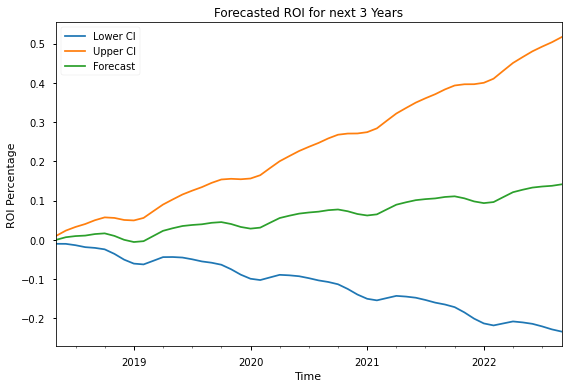

In [134]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 56443 has a predicted ROI of 14.1% after three years. However, the confidence interval ranges from -23.4% to 51.7%

## Zipcode 56570

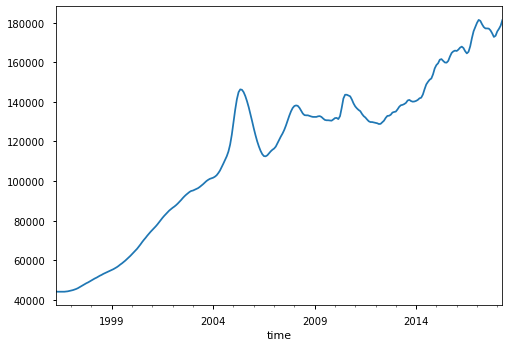

In [135]:
ts = all_time_series_df['56570']
ts.plot();

In [136]:
#Create train test split cutoff
tts_cutoff = round(len(ts)*0.80)
display(tts_cutoff)
    
## Use the tts cutoff to do Train test split and plot
train = ts.iloc[:tts_cutoff]
test = ts.iloc[tts_cutoff:]

212

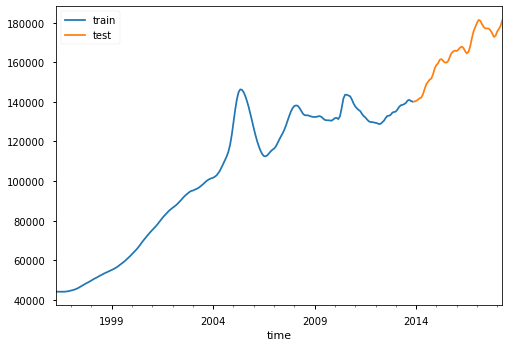

In [137]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.5946           9  ...  False        False

[1 rows x 6 columns]

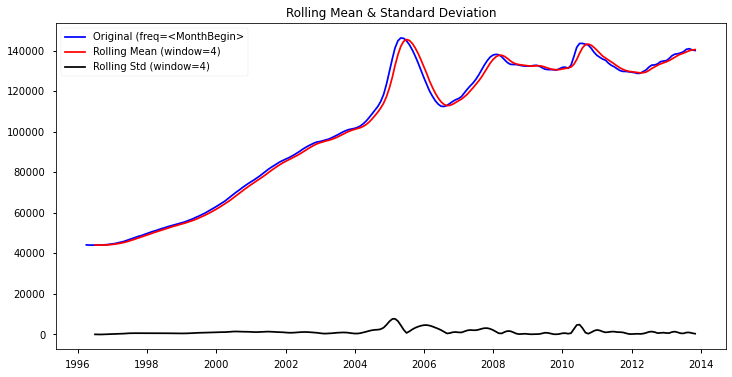

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.5946           9  ...  False        False

[1 rows x 6 columns]

In [138]:
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -4.6690          15  ...   True         True

[1 rows x 6 columns]

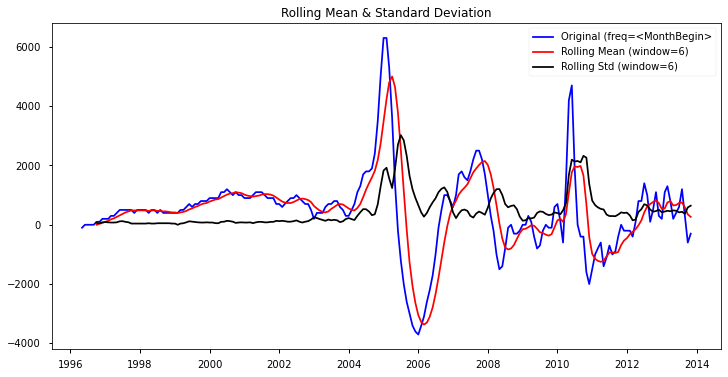

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -4.6690          15  ...   True         True

[1 rows x 6 columns]

In [139]:
stationarity_check(train.diff().dropna(), window=6)

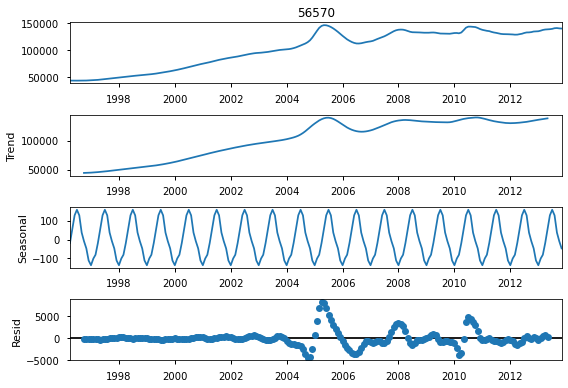

In [140]:
decompose = tsa.seasonal_decompose(train)
decompose.plot();

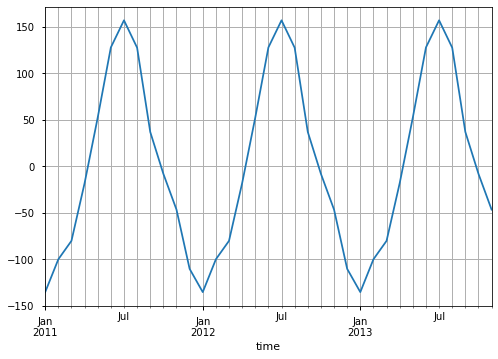

In [141]:
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3656.349, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3562.711, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3592.836, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3675.831, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3569.329, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3563.439, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3567.691, Time=0.44 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3561.541, Time=0.33 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3565.292, Time=0.48 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3565.524, Time=0.77 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3647.340, Time=0.05 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=3552.722, Time=0.37 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=3559.598, Time=0.11 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=3556.099, Time=0.40 sec
 ARIMA(2,1,0)(0,0,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  212
Model:             SARIMAX(2, 1, 0)x(0, 0, [1], 12)   Log Likelihood               -1771.361
Date:                              Wed, 30 Jun 2021   AIC                           3552.722
Time:                                      00:01:54   BIC                           3569.482
Sample:                                           0   HQIC                          3559.497
                                              - 212                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    203.9193     59.902      3.404      0.001      86.513     321.326
ar.L1          0.3151      0.007     48.069      0.000       0.302       0.328
ar.L2          0.1475      0.013     11.464      0.000       0.122       0.173
ma.S.L12      -0.1206      0.024     -5.028      0.000      -0.168      -0.074
sigma2      7.012e+05      4e+04     17.514      0.000    6.23e+05     7.8e+05
===================================================================================
Ljung-Box (L1) (Q):                  96.58   Jarque-Bera (JB):              1926.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -1.18
Prob(H) (two-sided):                  0.14   Kurtosis:                        17.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

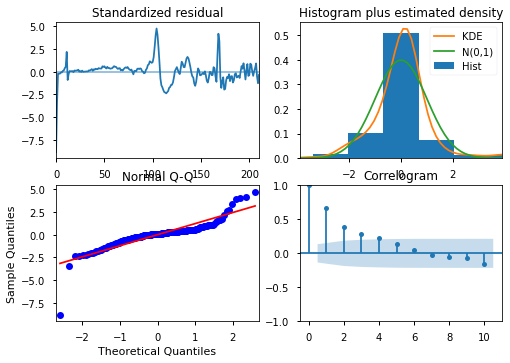

In [142]:
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3659.434, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3461.710, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3528.715, Time=0.27 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3488.814, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3456.739, Time=0.60 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=3458.052, Time=1.58 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=3457.198, Time=1.12 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=3455.200, Time=0.40 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=3455.021, Time=0.28 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=3455.211, Time=0.70 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=3460.039, Time=0.39 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3586.992, Time=0.16 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=3442.360, Time=0.34 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=3478.395, Time=0.12 sec
 ARIMA(2,1,0)(1,1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  212
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1715.975
Date:                              Wed, 30 Jun 2021   AIC                           3441.950
Time:                                      00:02:13   BIC                           3458.417
Sample:                                           0   HQIC                          3448.615
                                              - 212                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4970      0.009     54.338      0.000       0.479       0.515
ar.L2          0.1950      0.016     11.935      0.000       0.163       0.227
ar.S.L12       0.2376      0.073      3.246      0.001       0.094       0.381
ma.S.L12      -0.5970      0.096     -6.233      0.000      -0.785      -0.409
sigma2      1.169e+06    8.2e+04     14.264      0.000    1.01e+06    1.33e+06
===================================================================================
Ljung-Box (L1) (Q):                  46.49   Jarque-Bera (JB):              2965.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                             2.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

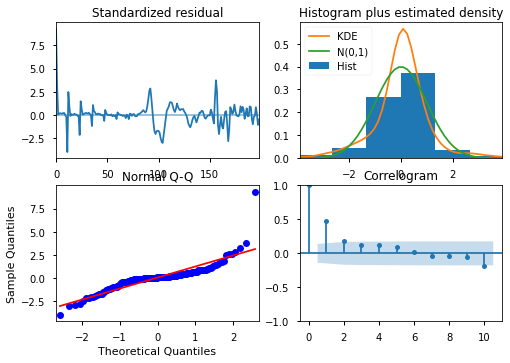

In [143]:
model = pmd.auto_arima(train, 
                       start_p=0, max_p=10,
                       start_P=0, max_P=10,
                       start_q=0, max_q=10,
                       start_Q=0, max_Q=10,
                       d=1, D=1,
                       m=12, 
                       trace=True)
display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                56570   No. Observations:                  212
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1715.975
Date:                              Wed, 30 Jun 2021   AIC                           3441.950
Time:                                      00:02:14   BIC                           3458.417
Sample:                                  04-01-1996   HQIC                          3448.615
                                       - 11-01-2013                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4970      0.009     54.338      0.000       0.479       0.515
ar.L2          0.1950      0.016     11.935      0.000       0.163       0.227
ar.S.L12       0.2376      0.073      3.246      0.001       0.094       0.381
ma.S.L12      -0.5970      0.096     -6.233      0.000      -0.785      -0.409
sigma2      1.169e+06    8.2e+04     14.264      0.000    1.01e+06    1.33e+06
===================================================================================
Ljung-Box (L1) (Q):                  46.49   Jarque-Bera (JB):              2965.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                             2.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

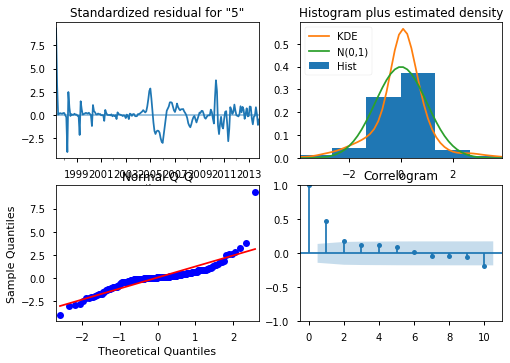

In [144]:
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [145]:
retrieve_forecast(sarimax_model, steps=len(test))

Lower CI    Upper CI    Forecast
2013-12-01 137419.4731 141658.2309 139538.8520
2014-01-01 135275.7267 142906.8447 139091.2857
2014-02-01 133740.9224 144956.5648 139348.7436
2014-03-01 132410.7107 147148.7748 139779.7427
2014-04-01 131059.0950 149209.5398 140134.3174
2014-05-01 129584.7919 151001.6968 140293.2443
2014-06-01 128392.7665 152920.4329 140656.5997
2014-07-01 127430.7192 154913.5555 141172.1373
2014-08-01 126802.8834 157091.6124 141947.2479
2014-09-01 125555.4634 158509.9783 142032.7208
2014-10-01 123903.7892 159394.3601 141649.0746
2014-11-01 122570.2852 160477.7525 141524.0189
2014-12-01 120502.8323 161704.5686 141103.7004
2015-01-01 118376.1117 163169.7699 140772.9408
2015-02-01 116735.3320 165328.8320 141032.0820
2015-03-01 115183.9291 167635.4818 141409.7054
2015-04-01 113626.9605 169920.8621 141773.9113
2015-05-01 111974.9365 172045.7370 142010.3367
2015-06-01 110553.1617 174308.5830 142430.8724
2015-07-01 109309.1338 176643.0687 142976.1012
2015-08-01 108287.2877 179088.3532 143687.8204
2015-09-01 106672.3605 180829.0286 143750.6945
2015-10-01 104738.0702 182141.7269 143439.8986
2015-11-01 103099.2801 183645.9307 143372.6054
2015-12-01 100872.4442 185123.5156 142997.9799
2016-01-01  98628.2153 186780.2080 142704.2116
2016-02-01  96871.3546 189070.0970 142970.7258
2016-03-01  95192.6734 191489.1883 143340.9308
2016-04-01  93514.3470 193908.4580 143711.4025
2016-05-01  91742.3654 196196.1318 143969.2486
2016-06-01  90179.5362 198631.7461 144405.6411
2016-07-01  88772.0524 201147.2257 144959.6391
2016-08-01  87550.1456 203765.0291 145657.5874
2016-09-01  85732.1252 205700.0108 145716.0680
2016-10-01  83606.5207 207240.1242 145423.3224
2016-11-01  81763.6560 208976.9711 145370.3136
2016-12-01  79382.4858 210631.4494 145006.9676
2017-01-01  76997.4882 212447.1278 144722.3080
2017-02-01  75102.5127 214879.1160 144990.8143
2017-03-01  73282.4445 217436.4309 145359.4377
2017-04-01  71461.8276 220001.2430 145731.5353
2017-05-01  69544.3666 222444.7840 145994.5753
2017-06-01  67826.8972 225042.7314 146434.8143
2017-07-01  66255.0793 227726.8308 146990.9551
2017-08-01  64855.8314 230515.5193 147685.6753
2017-09-01  62855.6798 232630.6114 147743.1456
2017-10-01  60547.0122 234362.4177 147454.7150
2017-11-01  58514.7053 236295.5344 147405.1199
2017-12-01  55970.4648 238118.4730 147044.4689
2018-01-01  53430.1815 240093.7882 146761.9849
2018-02-01  51383.6446 242678.3011 147030.9729
2018-03-01  49411.6735 245386.7797 147399.2266
2018-04-01  47437.9775 248105.4533 147771.7154

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

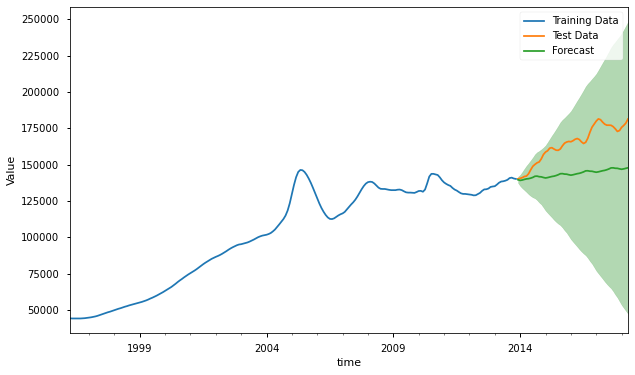

In [146]:
plot_train_test_forecast(train, test, forecast_df['Forecast'], forecast_df, forecast_df['Lower CI'], forecast_df['Upper CI'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                56570   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -2171.863
Date:                              Wed, 30 Jun 2021   AIC                           4353.725
Time:                                      00:02:16   BIC                           4371.373
Sample:                                  04-01-1996   HQIC                          4360.826
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5515      0.011     50.270      0.000       0.530       0.573
ar.L2          0.1198      0.024      4.979      0.000       0.073       0.167
ar.S.L12       0.2903      0.044      6.622      0.000       0.204       0.376
ma.S.L12      -0.7198      0.062    -11.644      0.000      -0.841      -0.599
sigma2      1.213e+06   8.69e+04     13.957      0.000    1.04e+06    1.38e+06
===================================================================================
Ljung-Box (L1) (Q):                  39.47   Jarque-Bera (JB):              3988.92
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             2.07
Prob(H) (two-sided):                  0.01   Kurtosis:                        22.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

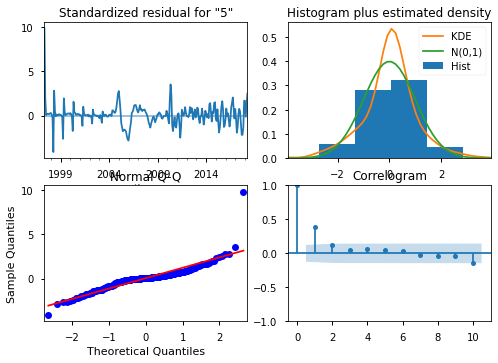

In [147]:
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [148]:
retrieve_forecast(sarimax_model_full, steps=36)

Lower CI    Upper CI    Forecast
2018-05-01 180513.8132 184830.8859 182672.3495
2018-06-01 179906.0888 187874.8873 183890.4880
2018-07-01 179303.7004 190975.7627 185139.7316
2018-08-01 178618.1563 193873.7636 186245.9600
2018-09-01 177600.3363 196266.8578 186933.5970
2018-10-01 176240.1687 198126.3532 187183.2610
2018-11-01 174638.6534 199554.5469 187096.6001
2018-12-01 174250.5141 202016.5191 188133.5166
2019-01-01 174676.6011 205127.3426 189901.9719
2019-02-01 174613.5072 207598.8992 191106.2032
2019-03-01 174610.7550 209995.6429 192303.1989
2019-04-01 175046.5151 212709.6350 193878.0750
2019-05-01 174187.1433 214888.3078 194537.7255
2019-06-01 173149.6172 217195.3233 195172.4703
2019-07-01 172199.0225 219748.3630 195973.6928
2019-08-01 171303.3710 222389.4111 196846.3911
2019-09-01 170283.6012 224868.2195 197575.9103
2019-10-01 169030.2816 227034.7464 198032.5140
2019-11-01 167564.5071 228889.6157 198227.0614
2019-12-01 166966.4159 231504.5739 199235.4949
2020-01-01 166945.8958 234588.2422 200767.0690
2020-02-01 166543.1267 237183.5589 201863.3428
2020-03-01 166117.1002 239654.4065 202885.7534
2020-04-01 165894.1345 242232.9873 204063.5609
2020-05-01 164700.1320 244273.0161 204486.5741
2020-06-01 163439.0592 246422.1267 204930.5930
2020-07-01 162341.1418 248831.6696 205586.4057
2020-08-01 161368.5193 251392.0587 206380.2890
2020-09-01 160345.0814 253883.0389 207114.0601
2020-10-01 159122.2159 256127.9194 207625.0676
2020-11-01 157692.0551 258102.3107 207897.1829
2020-12-01 157023.0631 260765.7676 208894.4153
2021-01-01 156855.5477 263854.6639 210355.1058
2021-02-01 156329.1617 266507.8822 211418.5220
2021-03-01 155747.8041 269030.5071 212389.1556
2021-04-01 155294.1917 271607.5973 213450.8945
2021-05-01 153965.7302 273643.5495 213804.6399
2021-06-01 152601.6046 275784.1537 214192.8792
2021-07-01 151421.7426 278190.6238 214806.1832
2021-08-01 150385.9406 280768.0092 215576.9749
2021-09-01 149318.2268 283305.4359 216311.8314
2021-10-01 148058.0059 285619.0496 216838.5277
2021-11-01 146588.6106 287677.5648 217133.0877
2021-12-01 145845.9054 290408.1199 218127.0126
2022-01-01 145579.0276 293555.1372 219567.0824
2022-02-01 144956.6292 296285.2305 220620.9299
2022-03-01 144266.8073 298886.2120 221576.5097
2022-04-01 143679.8548 301529.2121 222604.5335
2022-05-01 142253.6029 303622.7100 222938.1564
2022-06-01 140803.3057 305817.0795 223310.1926
2022-07-01 139544.3321 308277.9655 223911.1488
2022-08-01 138434.3596 310916.1044 224675.2320
2022-09-01 137296.5769 313524.2246 225410.4008

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

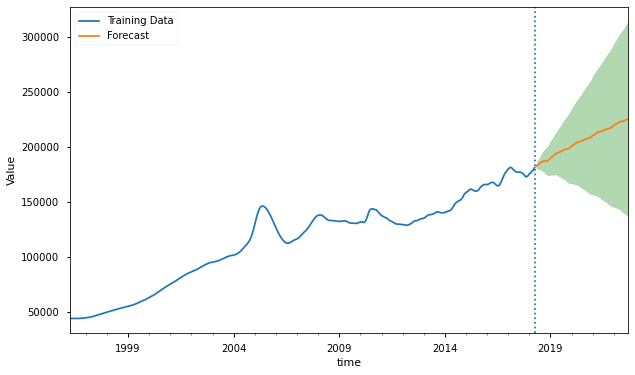

In [149]:
plot_time_series_forecast(ts, forecast_df['Forecast'], forecast_df, forecast_df['Lower CI'], forecast_df['Upper CI'])

Lower CI  Upper CI  Forecast
2018-05-01   -0.0118    0.0118    0.0000
2018-06-01   -0.0151    0.0285    0.0067
2018-07-01   -0.0184    0.0455    0.0135
2018-08-01   -0.0222    0.0613    0.0196
2018-09-01   -0.0278    0.0744    0.0233
2018-10-01   -0.0352    0.0846    0.0247
2018-11-01   -0.0440    0.0924    0.0242
2018-12-01   -0.0461    0.1059    0.0299
2019-01-01   -0.0438    0.1229    0.0396
2019-02-01   -0.0441    0.1365    0.0462
2019-03-01   -0.0441    0.1496    0.0527
2019-04-01   -0.0417    0.1644    0.0613
2019-05-01   -0.0465    0.1764    0.0650
2019-06-01   -0.0521    0.1890    0.0684
2019-07-01   -0.0573    0.2030    0.0728
2019-08-01   -0.0622    0.2174    0.0776
2019-09-01   -0.0678    0.2310    0.0816
2019-10-01   -0.0747    0.2429    0.0841
2019-11-01   -0.0827    0.2530    0.0852
2019-12-01   -0.0860    0.2673    0.0907
2020-01-01   -0.0861    0.2842    0.0991
2020-02-01   -0.0883    0.2984    0.1051
2020-03-01   -0.0906    0.3119    0.1107
2020-04-01   -0.0918    0.3261    0.1171
2020-05-01   -0.0984    0.3372    0.1194
2020-06-01   -0.1053    0.3490    0.1218
2020-07-01   -0.1113    0.3622    0.1254
2020-08-01   -0.1166    0.3762    0.1298
2020-09-01   -0.1222    0.3898    0.1338
2020-10-01   -0.1289    0.4021    0.1366
2020-11-01   -0.1367    0.4129    0.1381
2020-12-01   -0.1404    0.4275    0.1435
2021-01-01   -0.1413    0.4444    0.1515
2021-02-01   -0.1442    0.4589    0.1574
2021-03-01   -0.1474    0.4727    0.1627
2021-04-01   -0.1499    0.4869    0.1685
2021-05-01   -0.1571    0.4980    0.1704
2021-06-01   -0.1646    0.5097    0.1726
2021-07-01   -0.1711    0.5229    0.1759
2021-08-01   -0.1767    0.5370    0.1801
2021-09-01   -0.1826    0.5509    0.1842
2021-10-01   -0.1895    0.5636    0.1870
2021-11-01   -0.1975    0.5748    0.1886
2021-12-01   -0.2016    0.5898    0.1941
2022-01-01   -0.2031    0.6070    0.2020
2022-02-01   -0.2065    0.6219    0.2077
2022-03-01   -0.2102    0.6362    0.2130
2022-04-01   -0.2135    0.6507    0.2186
2022-05-01   -0.2213    0.6621    0.2204
2022-06-01   -0.2292    0.6741    0.2225
2022-07-01   -0.2361    0.6876    0.2258
2022-08-01   -0.2422    0.7020    0.2299
2022-09-01   -0.2484    0.7163    0.2340

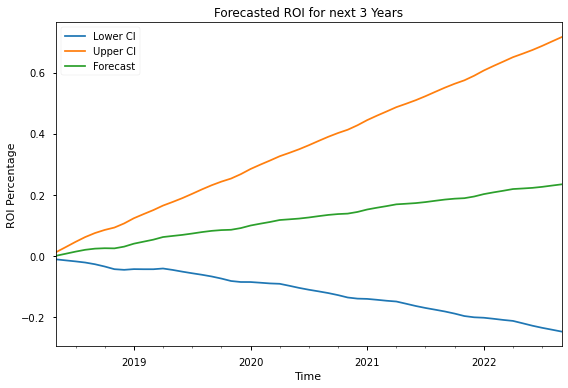

In [150]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 56570 has a predicted ROI of 23.4% after three years. However, the confidence interval ranges from -24.8% to 71.6%

## Zipcode 56314

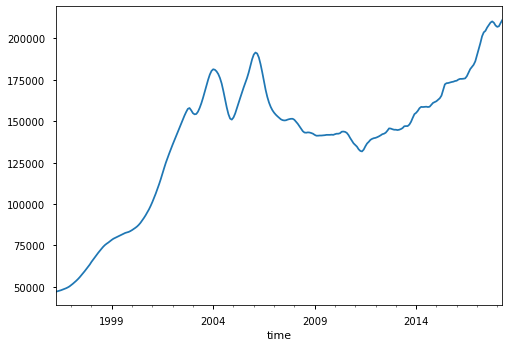

In [151]:
ts = all_time_series_df['56314']
ts.plot();

In [152]:
#Create train test split cutoff
tts_cutoff = round(len(ts)*0.80)
display(tts_cutoff)
    
## Use the tts cutoff to do Train test split and plot
train = ts.iloc[:tts_cutoff]
test = ts.iloc[tts_cutoff:]

212

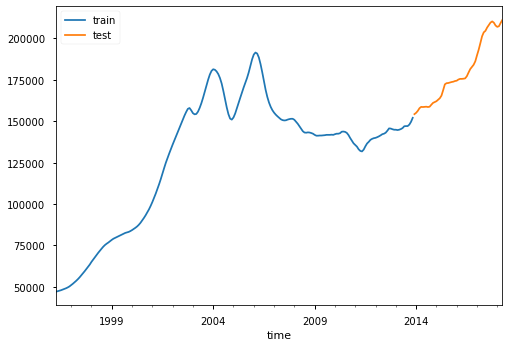

In [153]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.9909          15  ...  False        False

[1 rows x 6 columns]

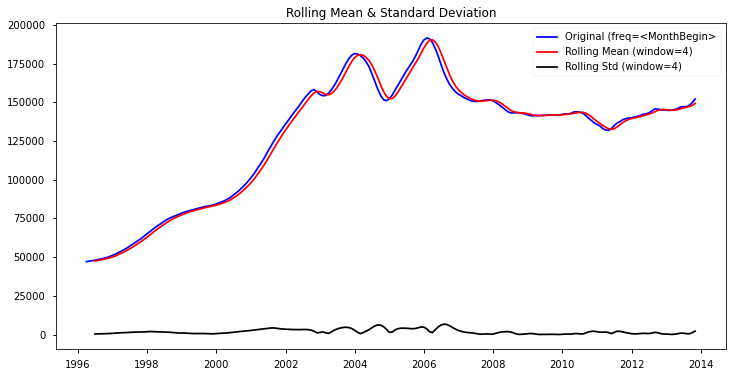

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.9909          15  ...  False        False

[1 rows x 6 columns]

In [154]:
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.8711          15  ...  False        False

[1 rows x 6 columns]

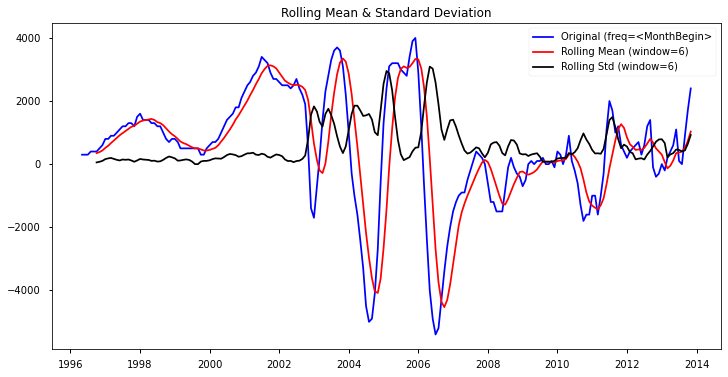

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.8711          15  ...  False        False

[1 rows x 6 columns]

In [155]:
stationarity_check(train.diff().dropna(), window=6)

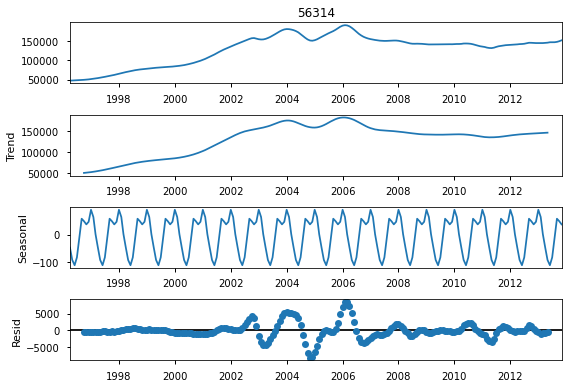

In [156]:
decompose = tsa.seasonal_decompose(train)
decompose.plot();

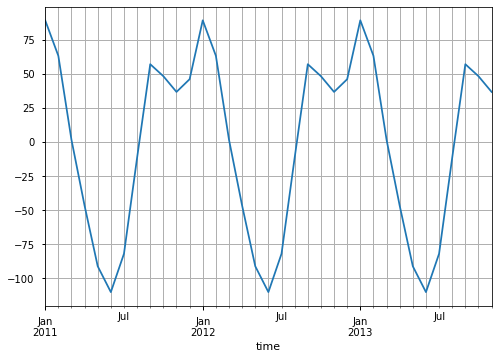

In [157]:
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3261.952, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3185.421, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3203.820, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=3187.660, Time=0.02 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=3187.288, Time=0.08 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=3184.893, Time=0.13 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=3185.492, Time=0.04 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=3186.826, Time=0.27 sec
 ARIMA(1,2,0)(1,0,2)[12]             : AIC=3186.808, Time=0.30 sec
 ARIMA(1,2,0)(0,0,2)[12]             : AIC=3187.491, Time=0.11 sec
 ARIMA(1,2,0)(2,0,2)[12]             : AIC=3182.438, Time=0.81 sec
 ARIMA(0,2,0)(2,0,2)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(2,2,0)(2,0,2)[12]             : AIC=3184.125, Time=0.90 sec
 ARIMA(1,2,1)(2,0,2)[12]             : AIC=3184.195, Time=1.04 sec
 ARIMA(0,2,1)(2,0,2)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  212
Model:             SARIMAX(1, 2, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -1585.219
Date:                                 Wed, 30 Jun 2021   AIC                           3182.438
Time:                                         00:02:26   BIC                           3202.521
Sample:                                              0   HQIC                          3190.557
                                                 - 212                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4604      0.013     35.719      0.000       0.435       0.486
ar.S.L12      -0.0821      0.310     -0.265      0.791      -0.689       0.525
ar.S.L24       0.6166      0.187      3.305      0.001       0.251       0.982
ma.S.L12      -0.0857      0.316     -0.271      0.786      -0.705       0.534
ma.S.L24      -0.6695      0.240     -2.793      0.005      -1.139      -0.200
sigma2      1.516e+05   1.26e+04     12.065      0.000    1.27e+05    1.76e+05
===================================================================================
Ljung-Box (L1) (Q):                  17.28   Jarque-Bera (JB):               207.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                             0.42
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

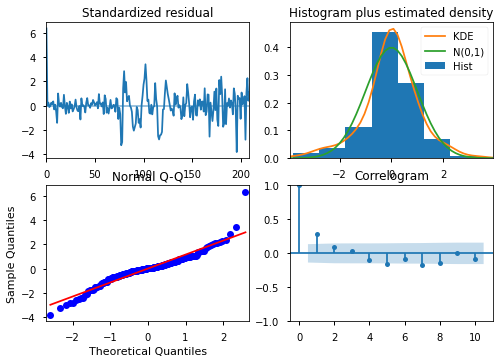

In [158]:
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3741.968, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3510.226, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3598.146, Time=0.27 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3550.558, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3512.062, Time=0.61 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=3511.847, Time=0.48 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=3510.199, Time=0.31 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=3517.664, Time=0.43 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=3512.370, Time=1.48 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3661.792, Time=0.17 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=3488.947, Time=0.42 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=3531.476, Time=0.16 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=3490.922, Time=0.54 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=3490.937, Time=0.86 sec
 ARIMA(2,1,0)(1,1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  212
Model:             SARIMAX(6, 1, 1)x(0, 1, [1, 2, 3], 12)   Log Likelihood               -1712.115
Date:                                    Wed, 30 Jun 2021   AIC                           3446.230
Time:                                            00:04:33   BIC                           3482.456
Sample:                                                 0   HQIC                          3460.891
                                                    - 212                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1067      0.085     13.003      0.000       0.940       1.273
ar.L2         -0.0744      0.048     -1.536      0.124      -0.169       0.021
ar.L3         -0.0571      0.042     -1.345      0.179      -0.140       0.026
ar.L4         -0.0187      0.088     -0.213      0.832      -0.191       0.154
ar.L5         -0.0400      0.125     -0.321      0.748      -0.284       0.204
ar.L6         -0.1053      0.065     -1.624      0.104      -0.232       0.022
ma.L1         -0.6430      0.097     -6.656      0.000      -0.832      -0.454
ma.S.L12      -0.2080      0.037     -5.599      0.000      -0.281      -0.135
ma.S.L24      -0.1339      0.032     -4.122      0.000      -0.198      -0.070
ma.S.L36      -0.0763      0.034     -2.255      0.024      -0.143      -0.010
sigma2      1.062e+06   5.61e-08   1.89e+13      0.000    1.06e+06    1.06e+06
===================================================================================
Ljung-Box (L1) (Q):                  65.20   Jarque-Bera (JB):              5848.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                             3.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.02e+29. Standard errors may be unstable.
"""

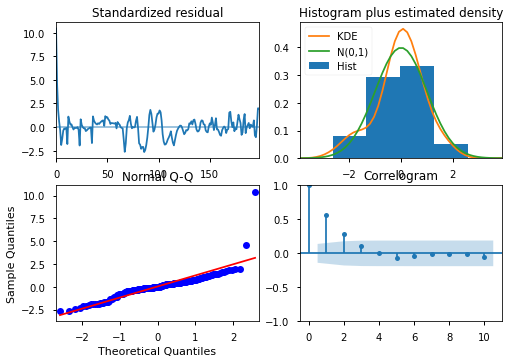

In [159]:
model = pmd.auto_arima(train, 
                       start_p=0, max_p=10,
                       start_P=0, max_P=10,
                       start_q=0, max_q=10,
                       start_Q=0, max_Q=10,
                       d=1, D=1,
                       m=12, 
                       trace=True)
display(model.summary())
model.plot_diagnostics();

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                      56314   No. Observations:                  212
Model:             SARIMAX(6, 1, 1)x(0, 1, [1, 2, 3], 12)   Log Likelihood               -1712.115
Date:                                    Wed, 30 Jun 2021   AIC                           3446.230
Time:                                            00:04:38   BIC                           3482.456
Sample:                                        04-01-1996   HQIC                          3460.891
                                             - 11-01-2013                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1067      0.085     13.003      0.000       0.940       1.273
ar.L2         -0.0744      0.048     -1.536      0.124      -0.169       0.021
ar.L3         -0.0571      0.042     -1.345      0.179      -0.140       0.026
ar.L4         -0.0187      0.088     -0.213      0.832      -0.191       0.154
ar.L5         -0.0400      0.125     -0.321      0.748      -0.284       0.204
ar.L6         -0.1053      0.065     -1.624      0.104      -0.232       0.022
ma.L1         -0.6430      0.097     -6.656      0.000      -0.832      -0.454
ma.S.L12      -0.2080      0.037     -5.599      0.000      -0.281      -0.135
ma.S.L24      -0.1339      0.032     -4.122      0.000      -0.198      -0.070
ma.S.L36      -0.0763      0.034     -2.255      0.024      -0.143      -0.010
sigma2      1.062e+06   5.61e-08   1.89e+13      0.000    1.06e+06    1.06e+06
===================================================================================
Ljung-Box (L1) (Q):                  65.20   Jarque-Bera (JB):              5848.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                             3.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.02e+29. Standard errors may be unstable.
"""

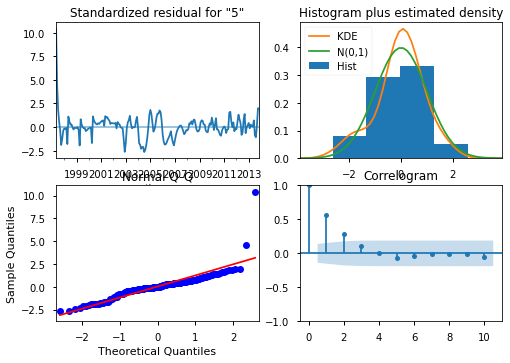

In [160]:
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [161]:
retrieve_forecast(sarimax_model, steps=len(test))

Lower CI    Upper CI    Forecast
2013-12-01 151345.1612 155384.7537 153364.9574
2014-01-01 151261.9110 158422.7390 154842.3250
2014-02-01 150856.4670 161360.4041 156108.4356
2014-03-01 150496.8817 164510.2335 157503.5576
2014-04-01 149884.3542 167529.1265 158706.7403
2014-05-01 149019.2393 170305.3583 159662.2988
2014-06-01 148310.8387 172988.2506 160649.5447
2014-07-01 146693.5151 174427.4357 160560.4754
2014-08-01 144908.7946 175312.6999 160110.7473
2014-09-01 143756.4820 176423.3110 160089.8965
2014-10-01 143224.6304 177749.7740 160487.2022
2014-11-01 143367.6632 179373.0593 161370.3612
2014-12-01 142324.2880 180399.0148 161361.6514
2015-01-01 141552.3742 181731.6494 161642.0118
2015-02-01 140714.4045 183032.2440 161873.3243
2015-03-01 140096.9393 184585.0022 162340.9708
2015-04-01 139539.2766 186249.3945 162894.3356
2015-05-01 139013.5226 187996.2085 163504.8656
2015-06-01 138791.1864 190017.7568 164404.4716
2015-07-01 137947.9446 191361.9342 164654.9394
2015-08-01 136986.4351 192508.8004 164747.6177
2015-09-01 136478.5765 194013.2042 165245.8904
2015-10-01 136384.7834 195821.2286 166103.0060
2015-11-01 136724.5020 197943.7777 167334.1399
2015-12-01 136016.6006 199561.7289 167789.1647
2016-01-01 135421.9902 201456.5415 168439.2658
2016-02-01 134638.1988 203303.9418 168971.0703
2016-03-01 133906.8323 205314.8332 169610.8328
2016-04-01 133123.7733 207366.6990 170245.2361
2016-05-01 132288.3351 209423.8403 170856.0877
2016-06-01 131619.3970 211613.8433 171616.6201
2016-07-01 130374.3457 213145.8120 171760.0789
2016-08-01 129029.7832 214458.8629 171744.3230
2016-09-01 128078.1501 216019.6544 172048.9022
2016-10-01 127405.9672 217698.2710 172552.1191
2016-11-01 127127.6652 219603.3896 173365.5274
2016-12-01 126011.2553 221021.3006 173516.2780
2017-01-01 125096.7441 222703.6144 173900.1792
2017-02-01 124079.2554 224340.1078 174209.6816
2017-03-01 123201.5464 226164.4370 174682.9917
2017-04-01 122367.5919 228081.6059 175224.5989
2017-05-01 121567.5604 230070.3783 175818.9693
2017-06-01 120987.2178 232261.8162 176624.5170
2017-07-01 119863.1683 233865.5327 176864.3505
2017-08-01 118653.0137 235316.2615 176984.6376
2017-09-01 117831.8760 237071.2627 177451.5694
2017-10-01 117270.0587 238986.7636 178128.4112
2017-11-01 117068.8678 241155.6127 179112.2403
2017-12-01 116011.7792 242824.7275 179418.2534
2018-01-01 115115.3745 244750.1271 179932.7508
2018-02-01 114070.7733 246612.0741 180341.4237
2018-03-01 113120.4055 248636.9305 180878.6680
2018-04-01 112171.8619 250724.5134 181448.1877

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

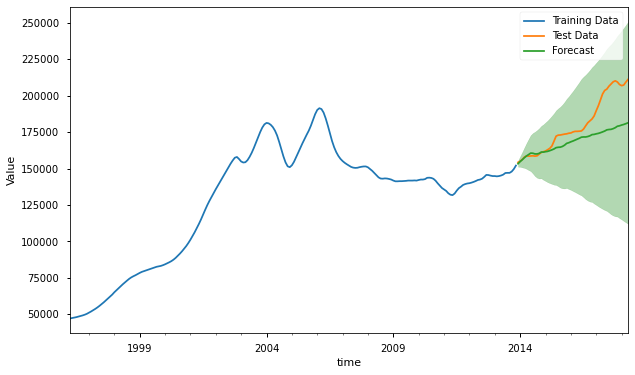

In [162]:
plot_train_test_forecast(train, test, forecast_df['Forecast'], forecast_df, forecast_df['Lower CI'], forecast_df['Upper CI'])

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                      56314   No. Observations:                  265
Model:             SARIMAX(6, 1, 1)x(0, 1, [1, 2, 3], 12)   Log Likelihood               -2157.414
Date:                                    Wed, 30 Jun 2021   AIC                           4336.828
Time:                                            00:04:44   BIC                           4375.652
Sample:                                        04-01-1996   HQIC                          4352.450
                                             - 04-01-2018                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1909      0.080     14.829      0.000       1.034       1.348
ar.L2         -0.1785      0.051     -3.471      0.001      -0.279      -0.078
ar.L3         -0.0540      0.047     -1.139      0.255      -0.147       0.039
ar.L4         -0.0073      0.093     -0.079      0.937      -0.190       0.176
ar.L5         -0.0279      0.131     -0.213      0.831      -0.284       0.228
ar.L6         -0.0981      0.071     -1.378      0.168      -0.238       0.041
ma.L1         -0.6672      0.092     -7.277      0.000      -0.847      -0.488
ma.S.L12      -0.2569      0.031     -8.373      0.000      -0.317      -0.197
ma.S.L24      -0.1293      0.029     -4.435      0.000      -0.187      -0.072
ma.S.L36      -0.0800      0.031     -2.585      0.010      -0.141      -0.019
sigma2      1.034e+06   6.56e-08   1.58e+13      0.000    1.03e+06    1.03e+06
===================================================================================
Ljung-Box (L1) (Q):                  57.97   Jarque-Bera (JB):              9832.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                             3.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.07e+28. Standard errors may be unstable.
"""

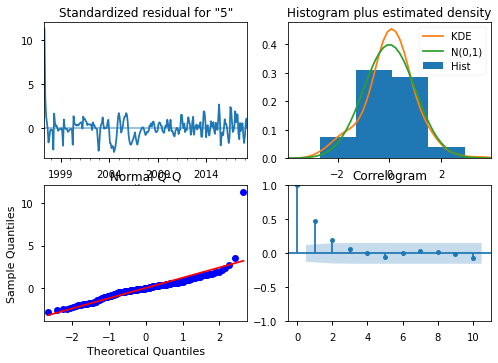

In [163]:
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [164]:
retrieve_forecast(sarimax_model_full, steps=36)

Lower CI    Upper CI    Forecast
2018-05-01 210125.0797 214111.0843 212118.0820
2018-06-01 208905.2754 216169.9721 212537.6238
2018-07-01 208985.9150 219680.3331 214333.1240
2018-08-01 209090.7363 223311.8756 216201.3060
2018-09-01 209469.9715 227286.2579 218378.1147
2018-10-01 209492.8796 230892.9968 220192.9382
2018-11-01 208650.4676 233386.3011 221018.3844
2018-12-01 207340.1640 235064.7648 221202.4644
2019-01-01 206872.9807 237193.2280 222033.1044
2019-02-01 207388.3118 239899.8992 223644.1055
2019-03-01 209128.3640 243437.4387 226282.9013
2019-04-01 210701.1378 246443.5902 228572.3640
2019-05-01 211124.4807 248820.0443 229972.2625
2019-06-01 210840.1334 250566.2026 230703.1680
2019-07-01 211229.9891 253014.7220 232122.3555
2019-08-01 211435.2912 255293.1185 233364.2049
2019-09-01 211755.2732 257717.8034 234736.5383
2019-10-01 211649.4844 259755.5845 235702.5345
2019-11-01 210691.1471 260914.9930 235803.0700
2019-12-01 209261.7410 261545.7053 235403.7232
2020-01-01 208472.3454 262738.6007 235605.4731
2020-02-01 208515.2645 264673.1033 236594.1839
2020-03-01 209584.7590 267533.4191 238559.0890
2020-04-01 210538.8082 270171.1383 240354.9733
2020-05-01 210643.6100 272451.9320 241547.7710
2020-06-01 210215.9791 274390.5884 242303.2838
2020-07-01 210445.4600 277122.1278 243783.7939
2020-08-01 210608.1185 279883.4468 245245.7827
2020-09-01 210918.2233 282868.2503 246893.2368
2020-10-01 210841.9662 285514.7647 248178.3654
2020-11-01 210036.2902 287400.6113 248718.4507
2020-12-01 208867.0265 288841.6384 248854.3325
2021-01-01 208328.5657 290797.7418 249563.1537
2021-02-01 208494.8534 293321.2216 250908.0375
2021-03-01 209565.1665 296598.7988 253081.9827
2021-04-01 210503.4702 299590.6079 255047.0390
2021-05-01 210598.5718 302049.1792 256323.8755
2021-06-01 210120.2463 304017.2187 257068.7325
2021-07-01 210253.0199 306649.3949 258451.2074
2021-08-01 210285.1865 309218.4043 259751.7954
2021-09-01 210446.1241 311952.4062 261199.2652
2021-10-01 210207.1510 314315.7825 262261.4667
2021-11-01 209226.0319 315920.4547 262573.2433
2021-12-01 207875.0545 317110.4983 262492.7764
2022-01-01 207156.7663 318867.8621 263012.3142
2022-02-01 207152.3540 321259.1730 264205.7635
2022-03-01 208066.3922 324478.2829 266272.3376
2022-04-01 208866.6537 327486.5366 268176.5951
2022-05-01 208865.5901 330010.7793 269438.1847
2022-06-01 208317.8844 332100.4083 270209.1464
2022-07-01 208402.5724 334902.0151 271652.2938
2022-08-01 208402.4006 337676.7962 273039.5984
2022-09-01 208541.4198 340639.4667 274590.4432

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

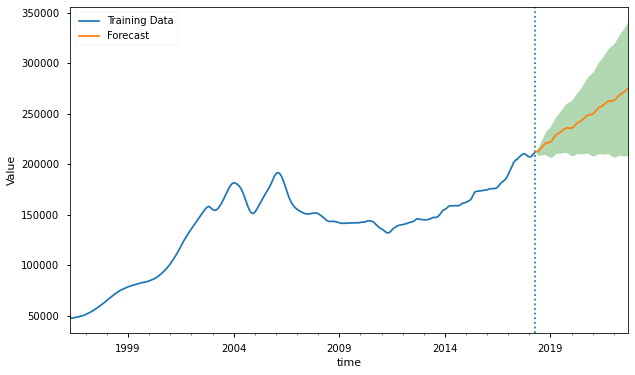

In [165]:
plot_time_series_forecast(ts, forecast_df['Forecast'], forecast_df, forecast_df['Lower CI'], forecast_df['Upper CI'])

Lower CI  Upper CI  Forecast
2018-05-01   -0.0094    0.0094    0.0000
2018-06-01   -0.0151    0.0191    0.0020
2018-07-01   -0.0148    0.0357    0.0104
2018-08-01   -0.0143    0.0528    0.0192
2018-09-01   -0.0125    0.0715    0.0295
2018-10-01   -0.0124    0.0885    0.0381
2018-11-01   -0.0163    0.1003    0.0420
2018-12-01   -0.0225    0.1082    0.0428
2019-01-01   -0.0247    0.1182    0.0467
2019-02-01   -0.0223    0.1310    0.0543
2019-03-01   -0.0141    0.1477    0.0668
2019-04-01   -0.0067    0.1618    0.0776
2019-05-01   -0.0047    0.1730    0.0842
2019-06-01   -0.0060    0.1813    0.0876
2019-07-01   -0.0042    0.1928    0.0943
2019-08-01   -0.0032    0.2035    0.1002
2019-09-01   -0.0017    0.2150    0.1066
2019-10-01   -0.0022    0.2246    0.1112
2019-11-01   -0.0067    0.2300    0.1117
2019-12-01   -0.0135    0.2330    0.1098
2020-01-01   -0.0172    0.2386    0.1107
2020-02-01   -0.0170    0.2478    0.1154
2020-03-01   -0.0119    0.2612    0.1247
2020-04-01   -0.0074    0.2737    0.1331
2020-05-01   -0.0070    0.2844    0.1387
2020-06-01   -0.0090    0.2936    0.1423
2020-07-01   -0.0079    0.3065    0.1493
2020-08-01   -0.0071    0.3195    0.1562
2020-09-01   -0.0057    0.3335    0.1639
2020-10-01   -0.0060    0.3460    0.1700
2020-11-01   -0.0098    0.3549    0.1725
2020-12-01   -0.0153    0.3617    0.1732
2021-01-01   -0.0179    0.3709    0.1765
2021-02-01   -0.0171    0.3828    0.1829
2021-03-01   -0.0120    0.3983    0.1931
2021-04-01   -0.0076    0.4124    0.2024
2021-05-01   -0.0072    0.4240    0.2084
2021-06-01   -0.0094    0.4332    0.2119
2021-07-01   -0.0088    0.4457    0.2184
2021-08-01   -0.0086    0.4578    0.2246
2021-09-01   -0.0079    0.4707    0.2314
2021-10-01   -0.0090    0.4818    0.2364
2021-11-01   -0.0136    0.4894    0.2379
2021-12-01   -0.0200    0.4950    0.2375
2022-01-01   -0.0234    0.5033    0.2399
2022-02-01   -0.0234    0.5145    0.2456
2022-03-01   -0.0191    0.5297    0.2553
2022-04-01   -0.0153    0.5439    0.2643
2022-05-01   -0.0153    0.5558    0.2702
2022-06-01   -0.0179    0.5656    0.2739
2022-07-01   -0.0175    0.5788    0.2807
2022-08-01   -0.0175    0.5919    0.2872
2022-09-01   -0.0169    0.6059    0.2945

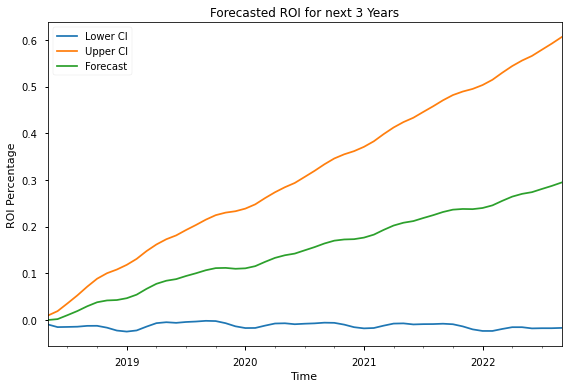

In [166]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 56314 has a predicted ROI of 29.5% after three years. However, the confidence interval ranges from -1.7% to 60.6%

## Zipcode 56578

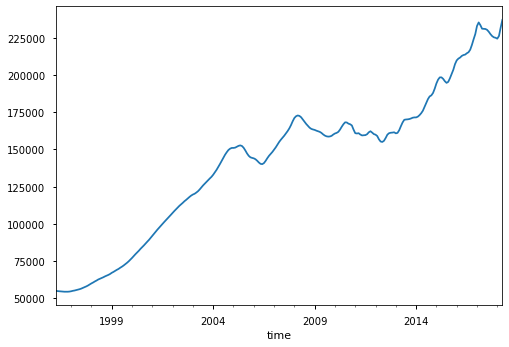

In [167]:
ts = all_time_series_df['56578']
ts.plot();

In [168]:
#Create train test split cutoff
tts_cutoff = round(len(ts)*0.80)
display(tts_cutoff)
    
## Use the tts cutoff to do Train test split and plot
train = ts.iloc[:tts_cutoff]
test = ts.iloc[tts_cutoff:]

212

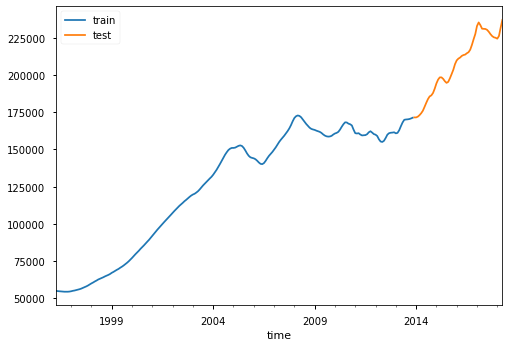

In [169]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.7535          13  ...  False        False

[1 rows x 6 columns]

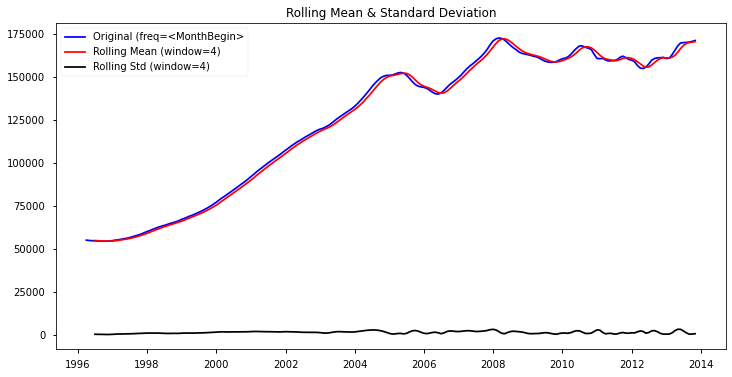

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.7535          13  ...  False        False

[1 rows x 6 columns]

In [170]:
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -3.9991          15  ...   True         True

[1 rows x 6 columns]

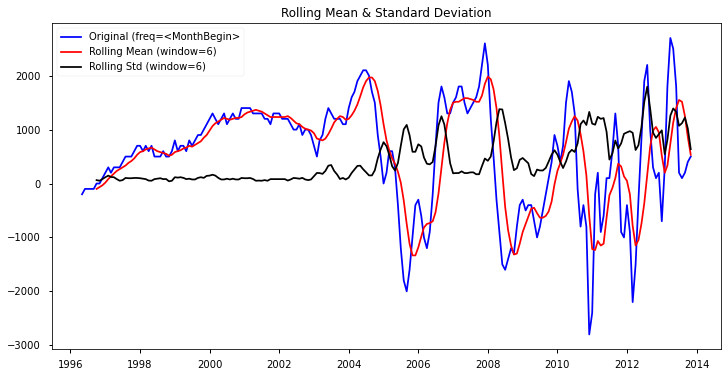

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -3.9991          15  ...   True         True

[1 rows x 6 columns]

In [171]:
stationarity_check(train.diff().dropna(), window=6)

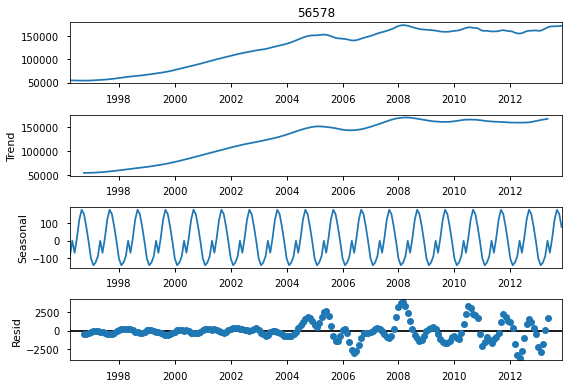

In [172]:
decompose = tsa.seasonal_decompose(train)
decompose.plot();

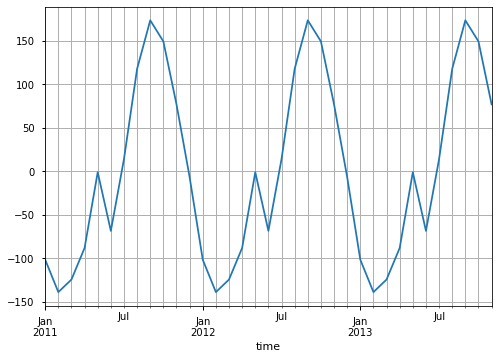

In [173]:
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3517.291, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3477.889, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3489.607, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3571.403, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3476.552, Time=0.09 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3478.208, Time=0.21 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3479.951, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=3469.445, Time=0.12 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=3470.800, Time=0.24 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=3470.305, Time=0.22 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=3471.771, Time=0.44 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=3468.173, Time=0.14 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=3469.620, Time=0.28 sec
 ARIMA(3,1,0)(0,0,1)[12] intercept   : AIC=3469.394, Time=0.30 sec
 ARIMA(3,1,0)(1,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -1729.087
Date:                Wed, 30 Jun 2021   AIC                           3468.173
Time:                        00:04:51   BIC                           3484.933
Sample:                             0   HQIC                          3474.948
                                - 212                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    286.7622     57.544      4.983      0.000     173.979     399.546
ar.L1          0.2013      0.007     30.250      0.000       0.188       0.214
ar.L2          0.0884      0.013      6.833      0.000       0.063       0.114
ar.L3          0.0553      0.019      2.955      0.003       0.019       0.092
sigma2      5.686e+05   5.22e+04     10.897      0.000    4.66e+05    6.71e+05
===================================================================================
Ljung-Box (L1) (Q):                 113.78   Jarque-Bera (JB):               459.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -1.62
Prob(H) (two-sided):                  0.10   Kurtosis:                         9.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

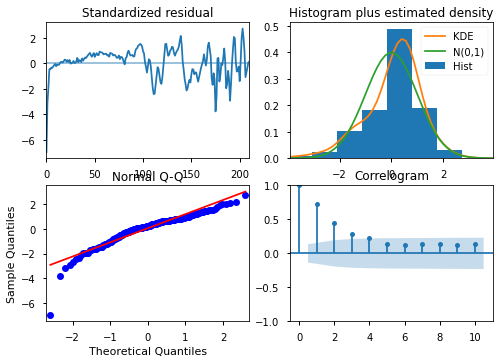

In [174]:
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3462.530, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3390.083, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3406.451, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3398.903, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3380.902, Time=0.53 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=3382.796, Time=1.04 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=3382.715, Time=1.30 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=3383.623, Time=0.50 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.44 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3442.567, Time=0.13 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=3372.306, Time=0.62 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=3379.546, Time=0.28 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=3374.291, Time=1.29 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=3374.275, Time=1.24 sec
 ARIMA(2,1,0)(1,1,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  212
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1680.095
Date:                            Wed, 30 Jun 2021   AIC                           3372.190
Time:                                    00:05:20   BIC                           3391.950
Sample:                                         0   HQIC                          3380.187
                                            - 212                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2792      0.007     40.264      0.000       0.266       0.293
ar.L2          0.1037      0.017      5.975      0.000       0.070       0.138
ar.L3          0.0575      0.026      2.243      0.025       0.007       0.108
ar.S.L12      -0.2031      0.017    -11.626      0.000      -0.237      -0.169
ar.S.L24      -0.1172      0.017     -6.731      0.000      -0.151      -0.083
sigma2       9.28e+05   7.43e+04     12.489      0.000    7.82e+05    1.07e+06
===================================================================================
Ljung-Box (L1) (Q):                  69.50   Jarque-Bera (JB):               419.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             0.85
Prob(H) (two-sided):                  0.19   Kurtosis:                         9.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

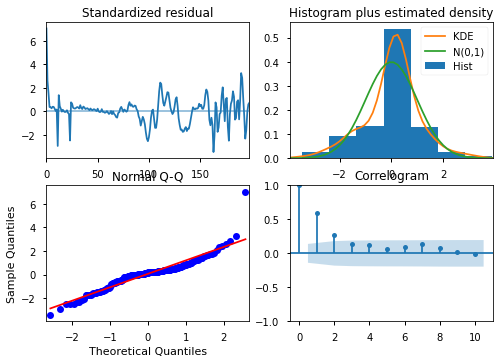

In [175]:
model = pmd.auto_arima(train, 
                       start_p=0, max_p=10,
                       start_P=0, max_P=10,
                       start_q=0, max_q=10,
                       start_Q=0, max_Q=10,
                       d=1, D=1,
                       m=12, 
                       trace=True)
display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              56578   No. Observations:                  212
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1680.095
Date:                            Wed, 30 Jun 2021   AIC                           3372.190
Time:                                    00:05:21   BIC                           3391.950
Sample:                                04-01-1996   HQIC                          3380.187
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2792      0.007     40.264      0.000       0.266       0.293
ar.L2          0.1037      0.017      5.975      0.000       0.070       0.138
ar.L3          0.0575      0.026      2.243      0.025       0.007       0.108
ar.S.L12      -0.2031      0.017    -11.626      0.000      -0.237      -0.169
ar.S.L24      -0.1172      0.017     -6.731      0.000      -0.151      -0.083
sigma2       9.28e+05   7.43e+04     12.489      0.000    7.82e+05    1.07e+06
===================================================================================
Ljung-Box (L1) (Q):                  69.50   Jarque-Bera (JB):               419.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             0.85
Prob(H) (two-sided):                  0.19   Kurtosis:                         9.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

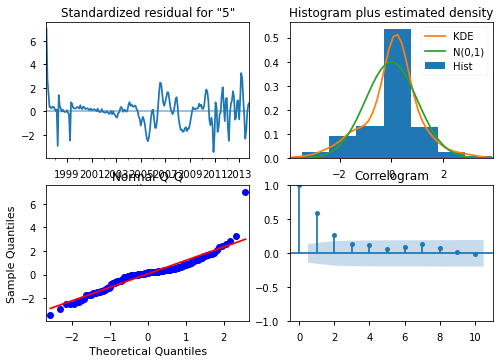

In [176]:
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [177]:
retrieve_forecast(sarimax_model, steps=len(test))

Lower CI    Upper CI    Forecast
2013-12-01 169302.2903 173078.5023 171190.3963
2014-01-01 167361.6461 173493.0055 170427.3258
2014-02-01 166521.6126 174769.2031 170645.4078
2014-03-01 166846.3865 177065.7259 171956.0562
2014-04-01 167894.1137 179904.8820 173899.4978
2014-05-01 168987.9913 182635.7220 175811.8567
2014-06-01 169759.3477 184913.4756 177336.4116
2014-07-01 169402.2902 185951.3212 177676.8057
2014-08-01 169094.8043 186944.3313 178019.5678
2014-09-01 168884.5515 187954.2636 178419.4075
2014-10-01 168736.7333 188957.8164 178847.2748
2014-11-01 168493.1416 189806.1883 179149.6649
2014-12-01 167244.4413 190681.2770 178962.8592
2015-01-01 165388.4392 191107.6442 178248.0417
2015-02-01 164328.1978 192356.5240 178342.3609
2015-03-01 164125.6662 194442.1699 179283.9181
2015-04-01 164627.5616 197150.5935 180889.0776
2015-05-01 165274.9949 199910.6588 182592.8268
2015-06-01 165729.0696 202383.3491 184056.2093
2015-07-01 165275.6998 203858.8135 184567.2567
2015-08-01 164892.1463 205321.3167 185106.7315
2015-09-01 164459.7583 206659.6452 185559.7017
2015-10-01 164019.0193 207921.3725 185970.1959
2015-11-01 163494.3488 209037.3929 186265.8709
2015-12-01 162180.9734 210081.0676 186131.0205
2016-01-01 160225.0670 210602.5134 185413.7902
2016-02-01 159099.1447 211986.5528 185542.8488
2016-03-01 158919.8582 214313.5712 186616.7147
2016-04-01 159454.8789 217303.5772 188379.2281
2016-05-01 160075.2636 220313.1353 190194.1995
2016-06-01 160424.0494 222980.5068 191702.2781
2016-07-01 159760.1961 224564.2244 192162.2102
2016-08-01 159141.6640 226124.9026 192633.2833
2016-09-01 158503.1004 227600.9967 193052.0485
2016-10-01 157886.7228 229038.8918 193462.8073
2016-11-01 157207.8906 230358.1032 193782.9969
2016-12-01 155748.2447 231545.0281 193646.6364
2017-01-01 153643.4823 232205.0042 192924.2433
2017-02-01 152377.3879 233744.0996 193060.7438
2017-03-01 152061.6542 236240.2889 194150.9715
2017-04-01 152445.0795 239397.2195 195921.1495
2017-05-01 152902.2161 242573.7151 197737.9656
2017-06-01 153079.1357 245409.1260 199244.1308
2017-07-01 152231.8496 247157.0593 199694.4544
2017-08-01 151427.3949 248885.3605 200156.3777
2017-09-01 150610.6268 250541.1078 200575.8673
2017-10-01 149815.8045 252161.4106 200988.6076
2017-11-01 148951.3943 253657.8132 201304.6038
2017-12-01 147339.1612 254985.7655 201162.4634
2018-01-01 145094.7272 255788.0762 200441.4017
2018-02-01 143683.1382 257461.5031 200572.3206
2018-03-01 143207.9325 260079.5159 201643.7242
2018-04-01 143427.8224 263359.9991 203393.9108

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

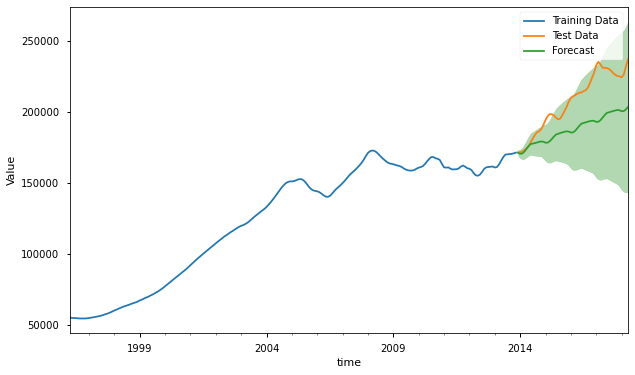

In [178]:
plot_train_test_forecast(train, test, forecast_df['Forecast'], forecast_df, forecast_df['Lower CI'], forecast_df['Upper CI'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              56578   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2186.209
Date:                            Wed, 30 Jun 2021   AIC                           4384.418
Time:                                    00:05:23   BIC                           4405.595
Sample:                                04-01-1996   HQIC                          4392.939
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3391      0.007     46.072      0.000       0.325       0.354
ar.L2          0.0673      0.030      2.249      0.024       0.009       0.126
ar.L3         -0.0009      0.045     -0.020      0.984      -0.089       0.088
ar.S.L12      -0.2380      0.017    -14.167      0.000      -0.271      -0.205
ar.S.L24      -0.1149      0.018     -6.410      0.000      -0.150      -0.080
sigma2      1.639e+06   9.38e+04     17.478      0.000    1.46e+06    1.82e+06
===================================================================================
Ljung-Box (L1) (Q):                  61.82   Jarque-Bera (JB):              1347.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.83   Skew:                             1.45
Prob(H) (two-sided):                  0.01   Kurtosis:                        13.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

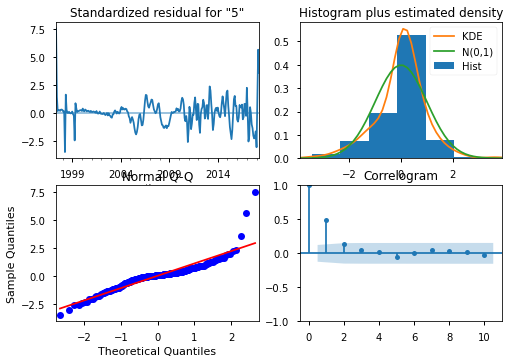

In [179]:
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [180]:
retrieve_forecast(sarimax_model_full, steps=36)

Lower CI    Upper CI    Forecast
2018-05-01 237163.0587 242181.8823 239672.4705
2018-06-01 236659.4136 245047.2359 240853.3248
2018-07-01 235366.9397 246709.6352 241038.2875
2018-08-01 233573.2452 247485.5770 240529.4111
2018-09-01 231855.8320 248034.6504 239945.2412
2018-10-01 230637.6326 248846.2290 239741.9308
2018-11-01 229941.1052 249994.0441 239967.5747
2018-12-01 229747.9272 251497.7603 240622.8437
2019-01-01 229461.9811 252789.3380 241125.6596
2019-02-01 230531.0699 255337.5124 242934.2911
2019-03-01 233960.2590 260163.1877 247061.7234
2019-04-01 237091.0213 264620.0308 250855.5260
2019-05-01 237879.8667 268017.8091 252948.8379
2019-06-01 237346.3833 270395.4854 253870.9343
2019-07-01 236044.3280 272038.6216 254041.4748
2019-08-01 234156.5108 272991.7121 253574.1114
2019-09-01 232359.0495 273895.5674 253127.3085
2019-10-01 231131.4187 275228.5487 253179.9837
2019-11-01 230425.9395 276954.0810 253690.0103
2019-12-01 230132.8151 278976.1722 254554.4937
2020-01-01 229956.1764 281012.1745 255484.1755
2020-02-01 230770.8373 283948.5463 257359.6918
2020-03-01 233378.2011 288596.6409 260987.4210
2020-04-01 235649.4337 292836.0492 264242.7415
2020-05-01 236117.4958 296193.2436 266155.3697
2020-06-01 235395.1778 298588.6130 266991.8954
2020-07-01 233896.6706 300254.6858 267075.6782
2020-08-01 231774.8802 301240.1877 266507.5339
2020-09-01 229671.3139 302151.3135 265911.3137
2020-10-01 228080.6362 303473.4516 265777.0439
2020-11-01 226998.6387 305204.4184 266101.5286
2020-12-01 226343.9647 307268.9349 266806.4498
2021-01-01 225729.0347 309286.5747 267507.8047
2021-02-01 226311.1537 312421.6610 269366.4074
2021-03-01 228987.1238 317577.4486 273282.2862
2021-04-01 231325.9749 322328.7487 276827.3618
2021-05-01 231720.9958 325978.0963 278849.5460
2021-06-01 230871.1301 328601.2151 279736.1726
2021-07-01 229212.2256 330472.3046 279842.2651
2021-08-01 226917.9324 331668.7515 279293.3419
2021-09-01 224633.6792 332800.1352 278716.9072
2021-10-01 222850.3064 334345.1482 278597.7273
2021-11-01 221566.3219 336301.0881 278933.7050
2021-12-01 220707.8624 338597.2808 279652.5716
2022-01-01 219877.4519 340841.0150 280359.2334
2022-02-01 220233.0261 344195.3288 282214.1774
2022-03-01 222673.5923 349564.1625 286118.8774
2022-04-01 224780.3754 354533.3198 289656.8476
2022-05-01 224991.3731 358356.0515 291673.7123
2022-06-01 223972.7351 361143.7535 292558.2443
2022-07-01 222153.6370 363184.3516 292668.9943
2022-08-01 219697.8510 364556.2993 292127.0751
2022-09-01 217252.5270 365873.6695 291563.0983

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

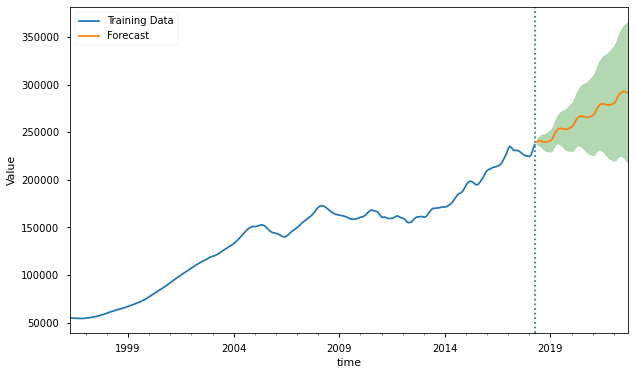

In [181]:
plot_time_series_forecast(ts, forecast_df['Forecast'], forecast_df, forecast_df['Lower CI'], forecast_df['Upper CI'])

Lower CI  Upper CI  Forecast
2018-05-01   -0.0105    0.0105    0.0000
2018-06-01   -0.0126    0.0224    0.0049
2018-07-01   -0.0180    0.0294    0.0057
2018-08-01   -0.0254    0.0326    0.0036
2018-09-01   -0.0326    0.0349    0.0011
2018-10-01   -0.0377    0.0383    0.0003
2018-11-01   -0.0406    0.0431    0.0012
2018-12-01   -0.0414    0.0493    0.0040
2019-01-01   -0.0426    0.0547    0.0061
2019-02-01   -0.0381    0.0654    0.0136
2019-03-01   -0.0238    0.0855    0.0308
2019-04-01   -0.0108    0.1041    0.0467
2019-05-01   -0.0075    0.1183    0.0554
2019-06-01   -0.0097    0.1282    0.0592
2019-07-01   -0.0151    0.1350    0.0600
2019-08-01   -0.0230    0.1390    0.0580
2019-09-01   -0.0305    0.1428    0.0561
2019-10-01   -0.0356    0.1484    0.0564
2019-11-01   -0.0386    0.1556    0.0585
2019-12-01   -0.0398    0.1640    0.0621
2020-01-01   -0.0405    0.1725    0.0660
2020-02-01   -0.0371    0.1847    0.0738
2020-03-01   -0.0263    0.2041    0.0889
2020-04-01   -0.0168    0.2218    0.1025
2020-05-01   -0.0148    0.2358    0.1105
2020-06-01   -0.0178    0.2458    0.1140
2020-07-01   -0.0241    0.2528    0.1143
2020-08-01   -0.0330    0.2569    0.1120
2020-09-01   -0.0417    0.2607    0.1095
2020-10-01   -0.0484    0.2662    0.1089
2020-11-01   -0.0529    0.2734    0.1103
2020-12-01   -0.0556    0.2820    0.1132
2021-01-01   -0.0582    0.2905    0.1161
2021-02-01   -0.0557    0.3035    0.1239
2021-03-01   -0.0446    0.3250    0.1402
2021-04-01   -0.0348    0.3449    0.1550
2021-05-01   -0.0332    0.3601    0.1635
2021-06-01   -0.0367    0.3710    0.1672
2021-07-01   -0.0436    0.3788    0.1676
2021-08-01   -0.0532    0.3838    0.1653
2021-09-01   -0.0627    0.3886    0.1629
2021-10-01   -0.0702    0.3950    0.1624
2021-11-01   -0.0755    0.4032    0.1638
2021-12-01   -0.0791    0.4127    0.1668
2022-01-01   -0.0826    0.4221    0.1698
2022-02-01   -0.0811    0.4361    0.1775
2022-03-01   -0.0709    0.4585    0.1938
2022-04-01   -0.0621    0.4792    0.2086
2022-05-01   -0.0613    0.4952    0.2170
2022-06-01   -0.0655    0.5068    0.2207
2022-07-01   -0.0731    0.5153    0.2211
2022-08-01   -0.0833    0.5211    0.2189
2022-09-01   -0.0935    0.5266    0.2165

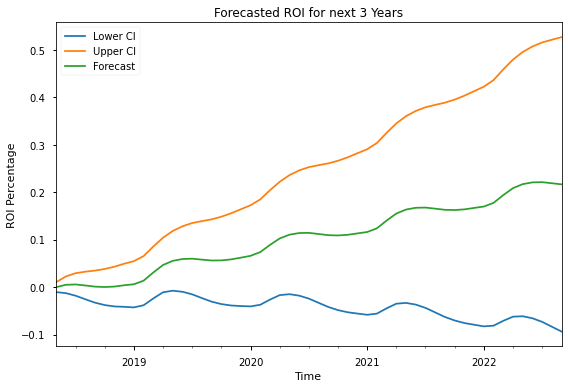

In [182]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 56578 has a predicted ROI of 21.7% after three years. However, the confidence interval ranges from -9.3% to 52.7%

# Interpreting Results

Based on the forecasted ROI percentages calculated from the SARIMA model forecasts, I would provide the following recommendations to the real estate investment firm as they look to invest in Minnesota:

- **Zip Code 55415** Zip code 55415 had a forecasted ROI of 45.8% after three years, with a lower confidence interval of 12.8% and an upper confidence interval of 78.7%. The firm should invest in this zip code.

- **Zip Code 56314** Zip code 56314 had a forecasted ROI of 29.5% after three years, with a lower confidence interval of -1.7% and an upper confidence interval of 52.7%. The firm should invest in this zip code.

- **Zip Code 56570** Zip code 56570 had a forecasted ROI of 23.4% after three years, with a lower confidence interval of -24.8% and an upper confidence interval of 71.6%. The firm should invest in this zip code.

- **Zip Code 56578** Zip code 56578 had a forecasted ROI of 21.7% after three years, with a lower confidence interval of -9.3% and an upper confidence interval of 52.7%. The firm should invest in this zip code.

- **Zip Code 55449** Zip code 55449 had a forecasted ROI of 21.4% after three years, with a lower confidence interval of -8.6% and an upper confidence interval of 51.3%. The firm should invest in this zip code.

However, the SARIMA models and analysis are not complete solutions, nor are they perfect. The time series struggle to perfectly meet the assumption of stationarity, and as such the models will not be completely accurate.

I could improve this analysis in the future by further transforming the data to achieve stationarity, further tweaking the hyperparameters of the models, or by experimenting with other models like recurrent neural networks, Prophet, and Greykite.